**This notebook contains followings:**
* Data Merging
* Feature Extraction
* Results on All Datasets


In [168]:
#importing necessary libraries
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
import random
import statistics
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn import preprocessing
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import plotly.express as px
import plotly.graph_objects as go
import optuna
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
import fitter
from distfit import distfit
from lifelines.datasets import load_rossi
import re
import math
import plotly.figure_factory as ff

# Merging Data

In [20]:
#Data paths XJTU Kaggle

# Root Mean Squared Sum
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

# extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

# extract shannon entropy (cut signals to 500 bins)
def calculate_entropy(df):
    ent = []
    for col in df:
        ent.append(entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(ent)
# extract clearence factor
def calculate_clearence(df):
    result = []
    for col in df:
        r = ((np.sqrt(df[col].abs())).sum() / len(df[col]))**2
        result.append(r)
    return result

def time_features(dataset_path, bootstrap= 0):
    features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p', 'crest', 'clearence', 'shape', 'impulse', 
                "freq_band_1" , "freq_band_2" , "freq_band_3" , "freq_band_4" , "freq_band_5", "Event", "Survival_time"]
    cols2 = ['B1', 'B2']

    if bootstrap > 8:
        raise Exception("Too much bootstrapping, max is 8")
    
    data_total= []

    #From the specs of XJTU dataset 25.6 kHz
    Fsamp = 25600

    Ts = 1/Fsamp
    
    # initialize
    columns = [c+'_'+tf for c in cols2 for tf in features]
    data = pd.DataFrame(columns=columns)
     
    for filename in os.listdir(dataset_path):
    
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep=',')

        timeline= int(re.sub('.csv*', '', filename))

        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
        crest = max_abs/rms
        clearence = np.array(calculate_clearence(raw_data))
        shape = rms / mean_abs
        impulse = max_abs / mean_abs

        h_signal = np.abs(hilbert(raw_data))
        N = len(h_signal)
        fft = np.abs(np.fft.fft(h_signal) /len (h_signal))
        fft= 2 * fft [0:int(N/2+1)]
        fft[0]= fft[0] / 2
        # Excluding continuous representation
        start_freq_interested = [9, 31, 68, 104, 168]
        end_freq_interested = [18, 39, 76, 112, 176]
        fft_n = [None] * 5
        i = 0
        for index_s in start_freq_interested:
            index_e= end_freq_interested[i]
            temp_mean = fft [index_s : index_e]
            fft_n [i]= np.mean(temp_mean, axis= 0) 
            i += 1

        mean_abs = pd.DataFrame(mean_abs.reshape(1,2), columns=[c+'_mean' for c in cols2])
        std = pd.DataFrame(std.reshape(1,2), columns=[c+'_std' for c in cols2])
        skew = pd.DataFrame(skew.reshape(1,2), columns=[c+'_skew' for c in cols2])
        kurtosis = pd.DataFrame(kurtosis.reshape(1,2), columns=[c+'_kurtosis' for c in cols2])
        entropy = pd.DataFrame(entropy.reshape(1,2), columns=[c+'_entropy' for c in cols2])
        rms = pd.DataFrame(rms.reshape(1,2), columns=[c+'_rms' for c in cols2])
        max_abs = pd.DataFrame(max_abs.reshape(1,2), columns=[c+'_max' for c in cols2])
        p2p = pd.DataFrame(p2p.reshape(1,2), columns=[c+'_p2p' for c in cols2])
        crest = pd.DataFrame(crest.reshape(1,2), columns=[c+'_crest' for c in cols2])
        clearence = pd.DataFrame(clearence.reshape(1,2), columns=[c+'_clearence' for c in cols2])
        shape = pd.DataFrame(shape.reshape(1,2), columns=[c+'_shape' for c in cols2])
        impulse = pd.DataFrame(impulse.reshape(1,2), columns=[c+'_impulse' for c in cols2])
        fft_1 = pd.DataFrame(fft_n [0].reshape(1,2), columns=[c+'_freq_band_1' for c in cols2])
        fft_2 = pd.DataFrame(fft_n [1].reshape(1,2), columns=[c+'_freq_band_2' for c in cols2])
        fft_3 = pd.DataFrame(fft_n [2].reshape(1,2), columns=[c+'_freq_band_3' for c in cols2])
        fft_4 = pd.DataFrame(fft_n [3].reshape(1,2), columns=[c+'_freq_band_4' for c in cols2])
        fft_5 = pd.DataFrame(fft_n [4].reshape(1,2), columns=[c+'_freq_band_5' for c in cols2])
        event = pd.DataFrame(np.array([False, False]).reshape(1,2), columns=[c+'_Event' for c in cols2])
        survt = pd.DataFrame(np.array([0, 0]).reshape(1,2), columns=[c+'_Survival_time' for c in cols2])

        mean_abs.index = [timeline]
        std.index = [timeline]
        skew.index = [timeline]
        kurtosis.index = [timeline]
        entropy.index = [timeline]
        rms.index = [timeline]
        max_abs.index = [timeline]
        p2p.index = [timeline]
        crest.index = [timeline]
        clearence.index = [timeline]
        shape.index = [timeline]
        impulse.index = [timeline]
        fft_1.index = [timeline]
        fft_2.index = [timeline]
        fft_3.index = [timeline] 
        fft_4.index = [timeline]
        fft_5.index = [timeline]
        event.index = [timeline]
        survt.index = [timeline]      
        
        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearence, shape, impulse, 
                        fft_1, fft_2, fft_3, fft_4, fft_5, event, survt], axis=1)
        data = pd.concat([data,merge])

    cols = [c+'_'+tf for c in cols2 for tf in features]
    data = data[cols]
    data.sort_index(inplace= True)
    data.reset_index(inplace= True, drop=True)  

    rng_bootstrap = np.random.permutation([-4, -3, -2, -1, 1, 2, 3, 4])
    rng_bootstrap = rng_bootstrap[:bootstrap]

    data_boot= data

    for boot_num in range (0, bootstrap + 2 , 1):
        
        if boot_num == 0:
            # data.iat[-1, 17]= False
            # data.iat[-1, -2]= False
            data_boot.reset_index(inplace= True, drop=True)
            data_total.append(data_boot)
        elif boot_num > 0 and boot_num < bootstrap + 1:
            if (rng_bootstrap [boot_num - 1] < 0):
                data_boot= data
                data_boot= data_boot.iloc[-(rng_bootstrap[boot_num - 1]) : , :]
            else:
                data_boot= data
                data_aux = pd.DataFrame(data_boot[-1:].values, columns= data.columns)          
                for boot_adder in range (0, rng_bootstrap[boot_num - 1], 1):
                    data_boot = data_boot.append(data_aux)
            data_boot.reset_index(inplace= True, drop=True)
            data_total.append(data_boot)
        elif boot_num == bootstrap + 1:
            data_boot= data
            rng_bootstrap= np.append(rng_bootstrap, random.randint(-4, -1))
            data_boot= data_boot.iloc[-(rng_bootstrap[boot_num - 1]) : , :]
            data_boot.reset_index(inplace= True, drop=True)            
            data_total.append(data_boot)

    rng_bootstrap = pd.DataFrame(rng_bootstrap, columns= ["Bootstrap values"])  

    return data_total, rng_bootstrap


In [21]:
#max bootno= 8
bootno = 2
bearings = 5
j = 1

for bearing in range (1, bearings + 1 , 1):

    dataset_path = "./data/XJTU-SY/35Hz12kN/Bearing1_" + str(bearing)
    datasets, bootstrap_val = time_features(dataset_path, bootstrap= bootno)
    i = 1
    for dataset in datasets:
        dataset.columns= ['B' + str(j) + '_mean' , 'B' + str(j) + '_std', 'B' + str(j) + '_skew', 'B' + str(j) + '_kurtosis', 'B' + str(j) + '_entropy', 
                          'B' + str(j) + '_rms','B' + str(j) + '_max', 'B' + str(j) + '_p2p', 'B' + str(j) + '_crest', 'B' + str(j) + '_clearence', 
                          'B' + str(j) + '_shape', 'B' + str(j) + '_impulse', 'B' + str(j) + '_freq_band_1', 'B' + str(j) + '_freq_band_2', 'B' + str(j) + '_freq_band_3', 
                          'B' + str(j) + '_freq_band_4', 'B' + str(j) + '_freq_band_5', 'B' + str(j) + '_Event', 'B' + str(j) + '_Survival_time',
                          'B' + str(j + 1) + '_mean', 'B' + str(j + 1) + '_std', 'B' + str(j + 1) + '_skew', 'B' + str(j + 1) + '_kurtosis', 'B' + str(j + 1) + '_entropy', 
                          'B' + str(j + 1) +'_rms', 'B' + str(j + 1) + '_max', 'B' + str(j + 1) + '_p2p', 'B' + str(j + 1) + '_crest' , 'B' + str(j + 1) + '_clearence', 
                          'B' + str(j + 1) + '_shape','B' + str(j + 1) + '_impulse', 'B' + str(j + 1) + '_freq_band_1' , 'B' + str(j + 1) + '_freq_band_2', 'B' + str(j + 1) + '_freq_band_3', 
                          'B' + str(j + 1) + '_freq_band_4' , 'B' + str(j + 1) + '_freq_band_5', 'B' + str(j + 1) + '_Event', 'B' + str(j + 1) + '_Survival_time']
            
        dataname= "./data/XJTU-SY/csv/Bearing1_" + str(bearing) + "_" + str(i) + "_timefeature.csv"
        dataset.to_csv(dataname, index= False)
        i += 1
        j += 2

    dataname= "./data/XJTU-SY/csv/Bearing1_" + str(bearing) + "_bootstrap.csv"
    bootstrap_val.to_csv(dataname, index= False)   

KeyboardInterrupt: 

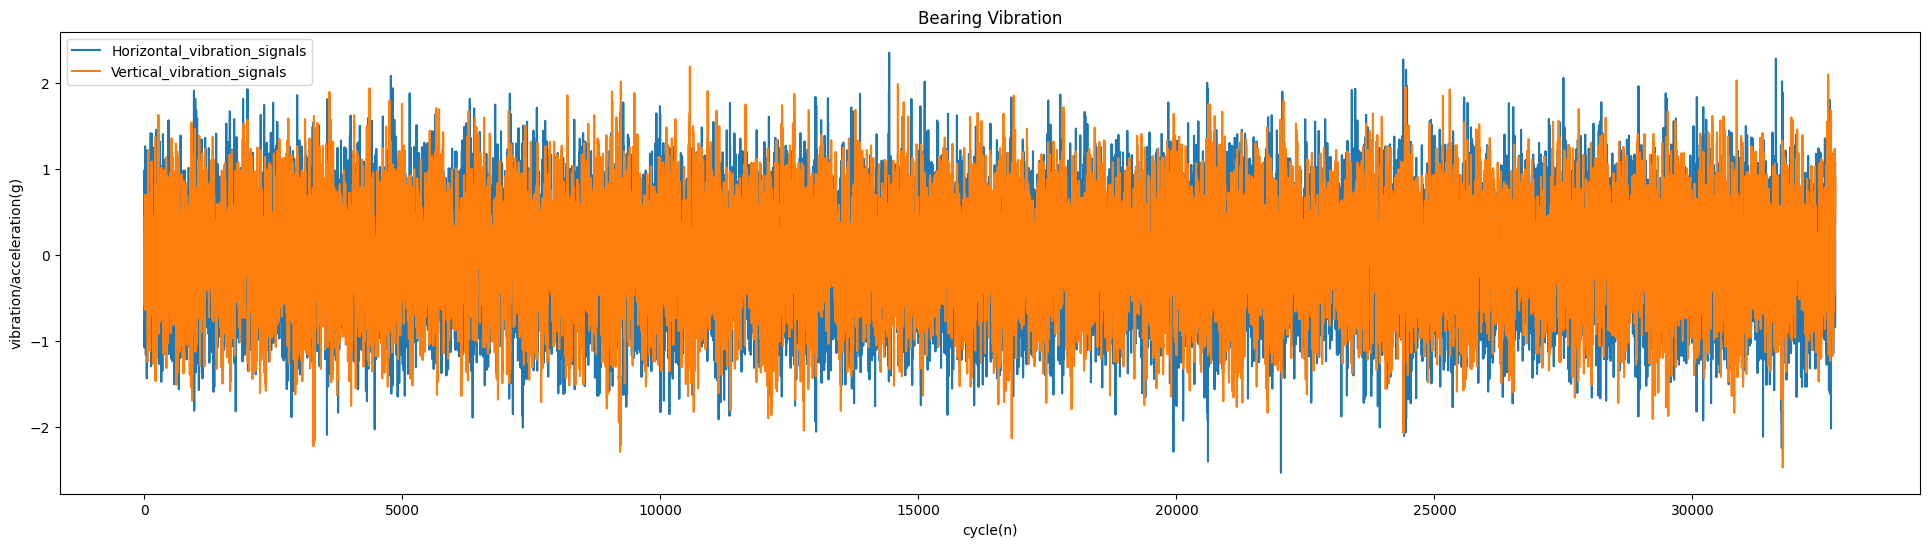

In [ ]:
# Test for the first fil
dataset_path = "./data/XJTU-SY/35Hz12kN/Bearing1_1/"
dataset = pd.read_csv(dataset_path + '1.csv')

ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

# Feature Extraction #

In [ ]:
# # Root Mean Squared Sum
# def calculate_rms(df):
#     result = []
#     for col in df:
#         r = np.sqrt((df[col]**2).sum() / len(df[col]))
#         result.append(r)
#     return result

# # extract peak-to-peak features
# def calculate_p2p(df):
#     return np.array(df.max().abs() + df.min().abs())

# # extract shannon entropy (cut signals to 500 bins)
# def calculate_entropy(df):
#     ent = []
#     for col in df:
#         ent.append(entropy(pd.cut(df[col], 500).value_counts()))
#     return np.array(ent)
# # extract clearence factor
# def calculate_clearence(df):
#     result = []
#     for col in df:
#         r = ((np.sqrt(df[col].abs())).sum() / len(df[col]))**2
#         result.append(r)
#     return result

# def time_features(dataset_path, id_set=None):
#     features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p', 'crest', 'clearence', 'shape', 'impulse', 
#                 "freq_band_1" , "freq_band_2" , "freq_band_3" , "freq_band_4" , "freq_band_5"]
#     cols1 = ['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
#     cols2 = ['B1','B2','B3','B4']

#     #From the specs of Kaggle NASA dataset
#     Fsamp = 20000
#     Ts = 1/Fsamp
    
#     # initialize
#     if id_set == 1:
#         columns = [c+'_'+tf for c in cols1 for tf in features]
#         data = pd.DataFrame(columns=columns)
#     else:
#         columns = [c+'_'+tf for c in cols2 for tf in features]
#         data = pd.DataFrame(columns=columns)
        
        
#     for filename in os.listdir(dataset_path):
#         # read dataset
#         raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        
#         # time features
#         mean_abs = np.array(raw_data.abs().mean())
#         std = np.array(raw_data.std())
#         skew = np.array(raw_data.skew())
#         kurtosis = np.array(raw_data.kurtosis())
#         entropy = calculate_entropy(raw_data)
#         rms = np.array(calculate_rms(raw_data))
#         max_abs = np.array(raw_data.abs().max())
#         p2p = calculate_p2p(raw_data)
#         crest = max_abs/rms
#         clearence = np.array(calculate_clearence(raw_data))
#         shape = rms / mean_abs
#         impulse = max_abs / mean_abs

#         h_signal = np.abs(hilbert(raw_data))
#         N = len(h_signal)
#         fft = np.abs(np.fft.fft(h_signal) /len (h_signal))
#         fft= 2 * fft [0:int(N/2+1)]
#         fft[0]= fft[0] / 2
#         # Excluding continuous representation
#         start_freq_interested = [9, 26, 230, 272, 291]
#         end_freq_interested = [21, 40, 242, 284, 305]
#         fft_n = [None] * 5
#         i = 0
#         for index_s in start_freq_interested:
#             index_e= end_freq_interested[i]
#             temp_mean = fft [index_s : index_e]
#             fft_n [i]= np.mean(temp_mean, axis= 0) 
#             i += 1

#         if id_set == 1:
#             mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
#             std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
#             skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
#             kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
#             entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
#             rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
#             max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
#             p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
#             crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
#             clearence = pd.DataFrame(clearence.reshape(1,8), columns=[c+'_clearence' for c in cols1])
#             shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
#             impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_impulse' for c in cols1])
#             fft_1 = pd.DataFrame(fft_n [0].reshape(1,8), columns=[c+'_freq_band_1' for c in cols1])
#             fft_2 = pd.DataFrame(fft_n [1].reshape(1,8), columns=[c+'_freq_band_2' for c in cols1])
#             fft_3 = pd.DataFrame(fft_n [2].reshape(1,8), columns=[c+'_freq_band_3' for c in cols1])
#             fft_4 = pd.DataFrame(fft_n [3].reshape(1,8), columns=[c+'_freq_band_4' for c in cols1])
#             fft_5 = pd.DataFrame(fft_n [4].reshape(1,8), columns=[c+'_freq_band_5' for c in cols1])

            
#         else:
#             mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
#             std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
#             skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
#             kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
#             entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
#             rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
#             max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
#             p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
#             crest = pd.DataFrame(crest.reshape(1,4), columns=[c+'_crest' for c in cols2])
#             clearence = pd.DataFrame(clearence.reshape(1,4), columns=[c+'_clearence' for c in cols2])
#             shape = pd.DataFrame(shape.reshape(1,4), columns=[c+'_shape' for c in cols2])
#             impulse = pd.DataFrame(impulse.reshape(1,4), columns=[c+'_impulse' for c in cols2])
#             fft_1 = pd.DataFrame(fft_n [0].reshape(1,4), columns=[c+'_freq_band_1' for c in cols2])
#             fft_2 = pd.DataFrame(fft_n [1].reshape(1,4), columns=[c+'_freq_band_2' for c in cols2])
#             fft_3 = pd.DataFrame(fft_n [2].reshape(1,4), columns=[c+'_freq_band_3' for c in cols2])
#             fft_4 = pd.DataFrame(fft_n [3].reshape(1,4), columns=[c+'_freq_band_4' for c in cols2])
#             fft_5 = pd.DataFrame(fft_n [4].reshape(1,4), columns=[c+'_freq_band_5' for c in cols2])

#         mean_abs.index = [filename]
#         std.index = [filename]
#         skew.index = [filename]
#         kurtosis.index = [filename]
#         entropy.index = [filename]
#         rms.index = [filename]
#         max_abs.index = [filename]
#         p2p.index = [filename]
#         crest.index = [filename]
#         clearence.index = [filename]
#         shape.index = [filename]
#         impulse.index = [filename]
#         fft_1.index = [filename]
#         fft_2.index = [filename]
#         fft_3.index = [filename] 
#         fft_4.index = [filename]
#         fft_5.index = [filename]    
        
#         # concat
#         merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearence, shape, impulse, 
#                            fft_1, fft_2, fft_3, fft_4, fft_5], axis=1)
#         data = pd.concat([data,merge])
        
#     if id_set == 1:
#         cols = [c+'_'+tf for c in cols1 for tf in features]
#         data = data[cols]
#     else:
#         cols = [c+'_'+tf for c in cols2 for tf in features]
#         data = data[cols]
        
#     data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
#     data = data.sort_index()
#     return data                                  

Reading Data again

In [ ]:
data_sample = pd.read_csv("./data/XJTU-SY/csv/Bearing1_1_1_timefeature.csv")
print (data_sample)

      B1_mean    B1_std   B1_skew  B1_kurtosis  B1_entropy    B1_rms  \
0    0.449234  0.563851 -0.001797     0.071546    5.466980  0.563890   
1    0.469337  0.589035 -0.014992     0.138146    5.177755  0.589078   
2    0.469207  0.589543  0.022944     0.246480    5.222381  0.589536   
3    0.473610  0.597245  0.013574     0.248411    5.421274  0.597274   
4    0.479684  0.604529  0.036587     0.394161    5.084863  0.604645   
..        ...       ...       ...          ...         ...       ...   
118  2.598606  3.631924 -0.326276     2.178601    5.135965  3.632455   
119  2.760711  3.819661 -0.216943     1.819169    5.209615  3.819631   
120  2.900586  3.987385 -0.232640     1.754787    5.082078  3.987478   
121  3.172205  4.339416 -0.278732     1.564076    5.309246  4.339480   
122  5.390425  7.268389 -0.274637     1.509480    5.385543  7.268278   

        B1_max     B1_p2p  B1_crest  B1_clearence  ...  B2_clearence  \
0     2.529883   4.884219  4.486485      0.380476  ...      0.3

In [44]:
data_sample.describe()

B1_mean      B1_std     B1_skew  B1_kurtosis  B1_entropy  \
count  123.000000  123.000000  123.000000   123.000000  123.000000   
mean     1.243809    1.679279   -0.085540     1.951249    4.955486   
std      0.935740    1.298216    0.115704     0.816020    0.188040   
min      0.449234    0.563851   -0.326276     0.071546    4.536899   
25%      0.583761    0.758614   -0.219310     1.639394    4.802533   
50%      0.616189    0.806464   -0.022078     1.819169    4.957494   
75%      2.157352    2.939949    0.004519     2.277306    5.094439   
max      5.390425    7.268389    0.110733     5.767132    5.466980   

           B1_rms      B1_max      B1_p2p    B1_crest  B1_clearence  ...  \
count  123.000000  123.000000  123.000000  123.000000    123.000000  ...   
mean     1.679512   11.636979   21.722968    7.740255      1.013152  ...   
std      1.298084    7.131382   13.548598    1.800652      0.747354  ...   
min      0.563890    2.529883    4.884219    4.486485      0.380476  ...   
25%      0.758763    6.340992   11.532718    6.323334      0.488022  ...   
50%      0.806864    7.571578   13.770378    7.506153      0.509677  ...   
75%      2.939927   19.137877   36.178726    8.893275      1.743910  ...   
max      7.268278   35.597789   65.352583   15.334709      4.402638  ...   

         B2_crest  B2_clearence    B2_shape  B2_impulse  B2_freq_band_1  \
count  123.000000    123.000000  123.000000  123.000000      123.000000   
mean     5.196278      0.844917    1.257925    6.542198        0.000058   
std      0.850127      0.601891    0.011951    1.107851        0.000059   
min      3.726763      0.379752    1.235628    4.617639        0.000009   
25%      4.620176      0.425307    1.248873    5.805984        0.000024   
50%      5.036348      0.433780    1.258616    6.344232        0.000032   
75%      5.659649      1.448925    1.263909    7.113353        0.000076   
max      7.758677      3.697840    1.304160    9.764087        0.000356   

       B2_freq_band_2  B2_freq_band_3  B2_freq_band_4  B2_freq_band_5  \
count      123.000000      123.000000      123.000000      123.000000   
mean         0.000053        0.000060        0.000057        0.000057   
std          0.000048        0.000061        0.000062        0.000053   
min          0.000014        0.000013        0.000009        0.000015   
25%          0.000024        0.000024        0.000025        0.000025   
50%          0.000031        0.000034        0.000033        0.000032   
75%          0.000071        0.000074        0.000067        0.000071   
max          0.000245        0.000350        0.000474        0.000283   

       B2_Survival_time  
count             123.0  
mean                0.0  
std                 0.0  
min                 0.0  
25%                 0.0  
50%                 0.0  
75%                 0.0  
max                 0.0  

[8 rows x 36 columns]

In [ ]:
set_visual= data_sample [["B1_freq_band_1", "B1_freq_band_2", "B1_freq_band_3", "B1_freq_band_4", "B1_freq_band_5"]]
set_visual.describe()

B1_freq_band_1  B1_freq_band_2  B1_freq_band_3  B1_freq_band_4  \
count      123.000000      123.000000      123.000000      123.000000   
mean         0.000138        0.000127        0.000139        0.000130   
std          0.000128        0.000102        0.000124        0.000116   
min          0.000029        0.000039        0.000033        0.000033   
25%          0.000058        0.000056        0.000058        0.000058   
50%          0.000078        0.000070        0.000078        0.000076   
75%          0.000182        0.000177        0.000191        0.000173   
max          0.000579        0.000496        0.000623        0.000765   

       B1_freq_band_5  
count      123.000000  
mean         0.000130  
std          0.000113  
min          0.000040  
25%          0.000059  
50%          0.000076  
75%          0.000162  
max          0.000690

Plotting features of all bearings in both x and y axis

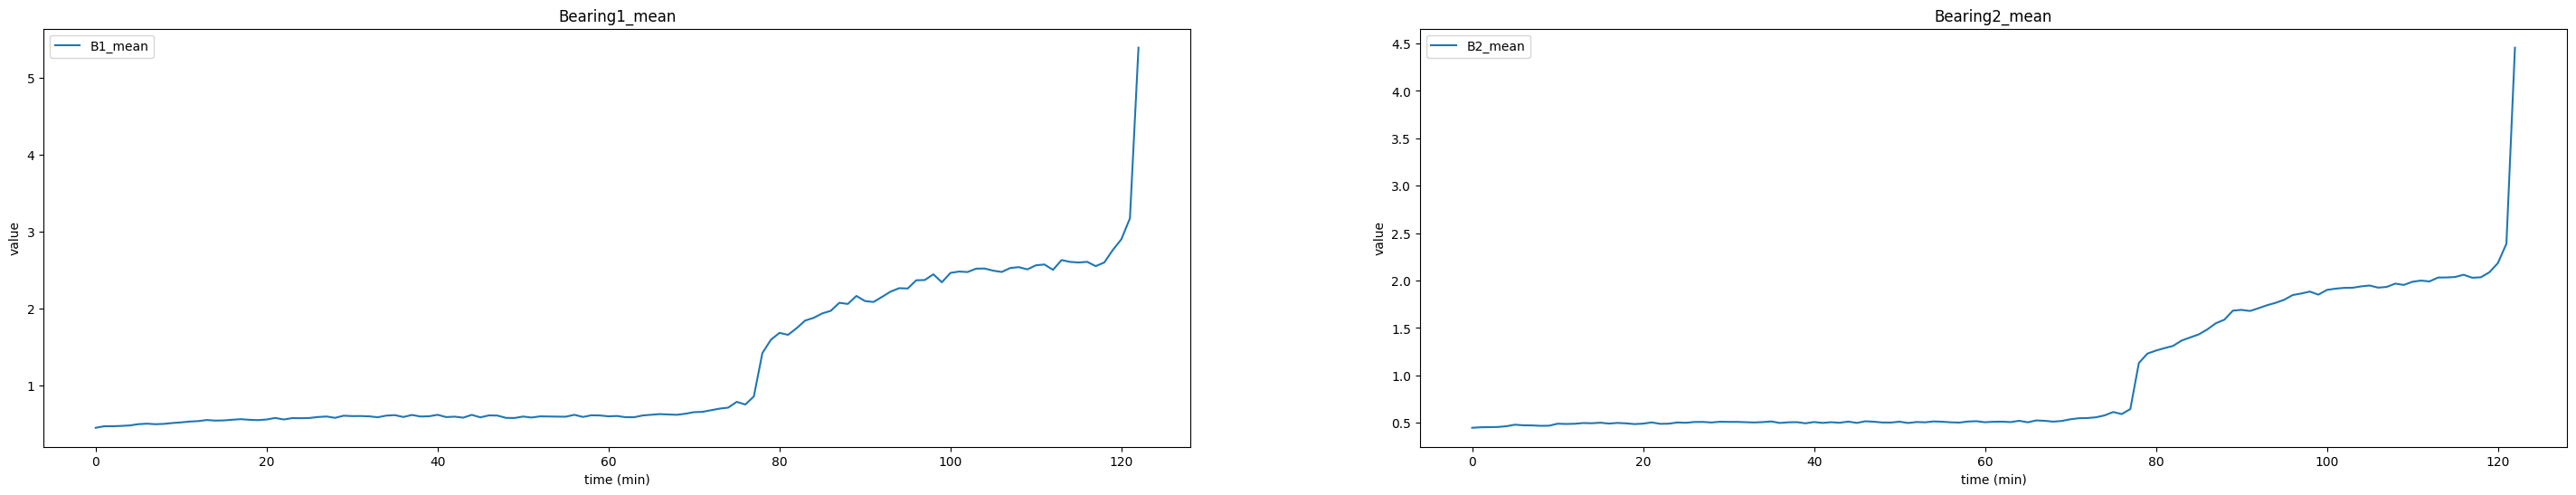

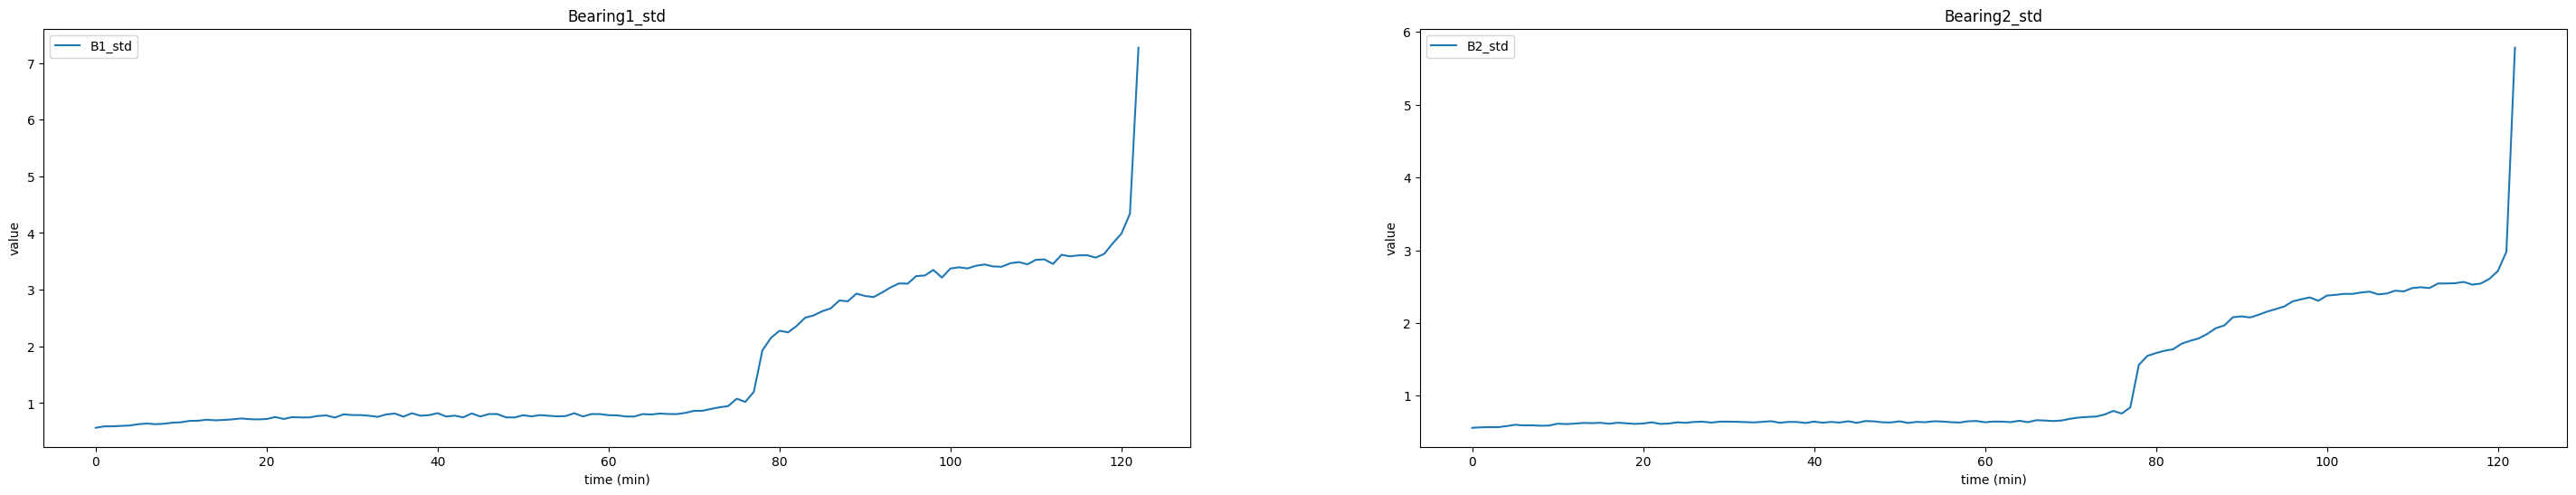

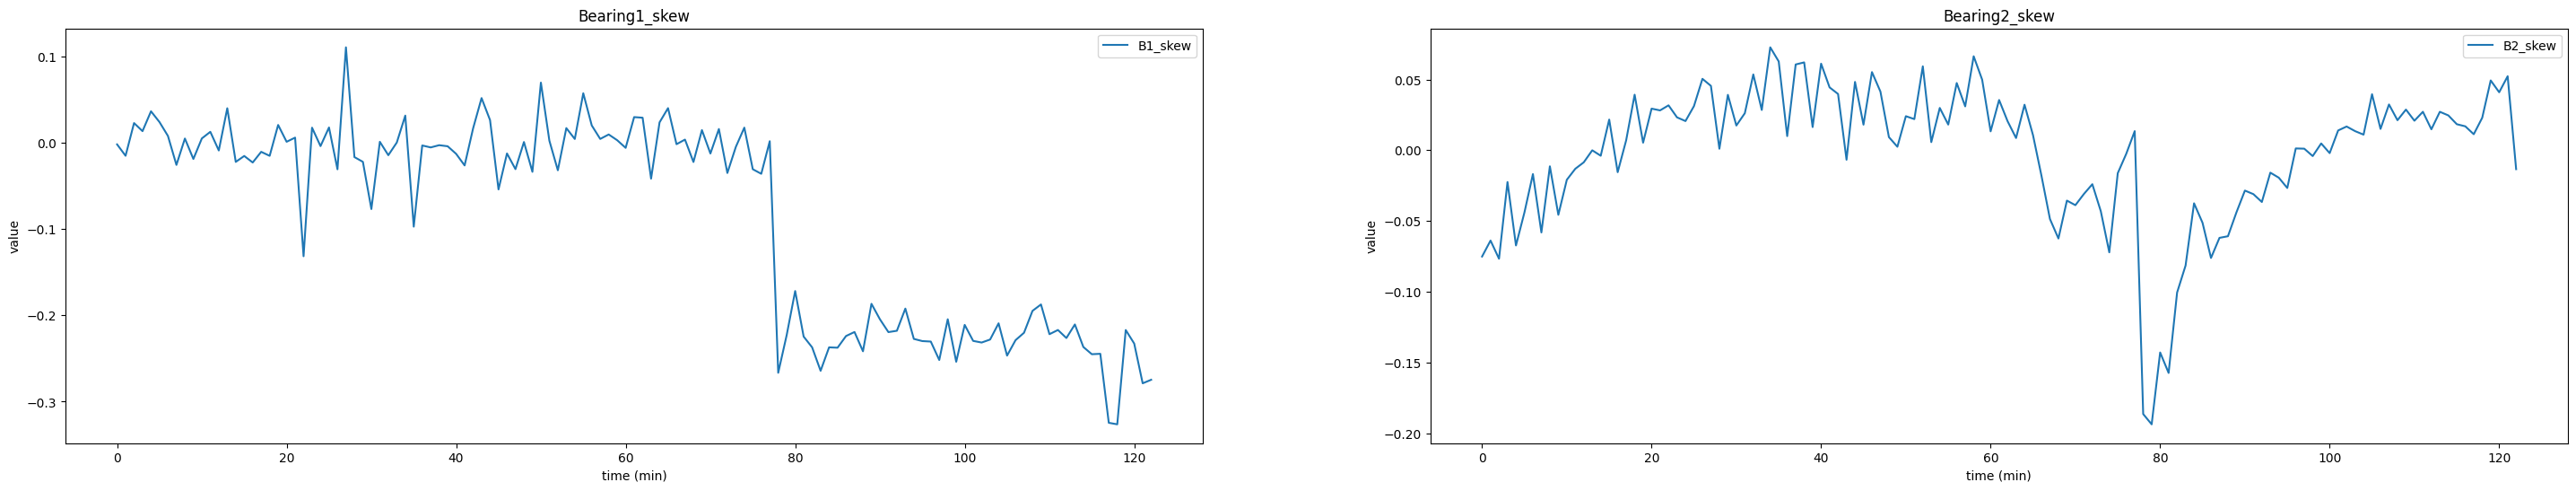

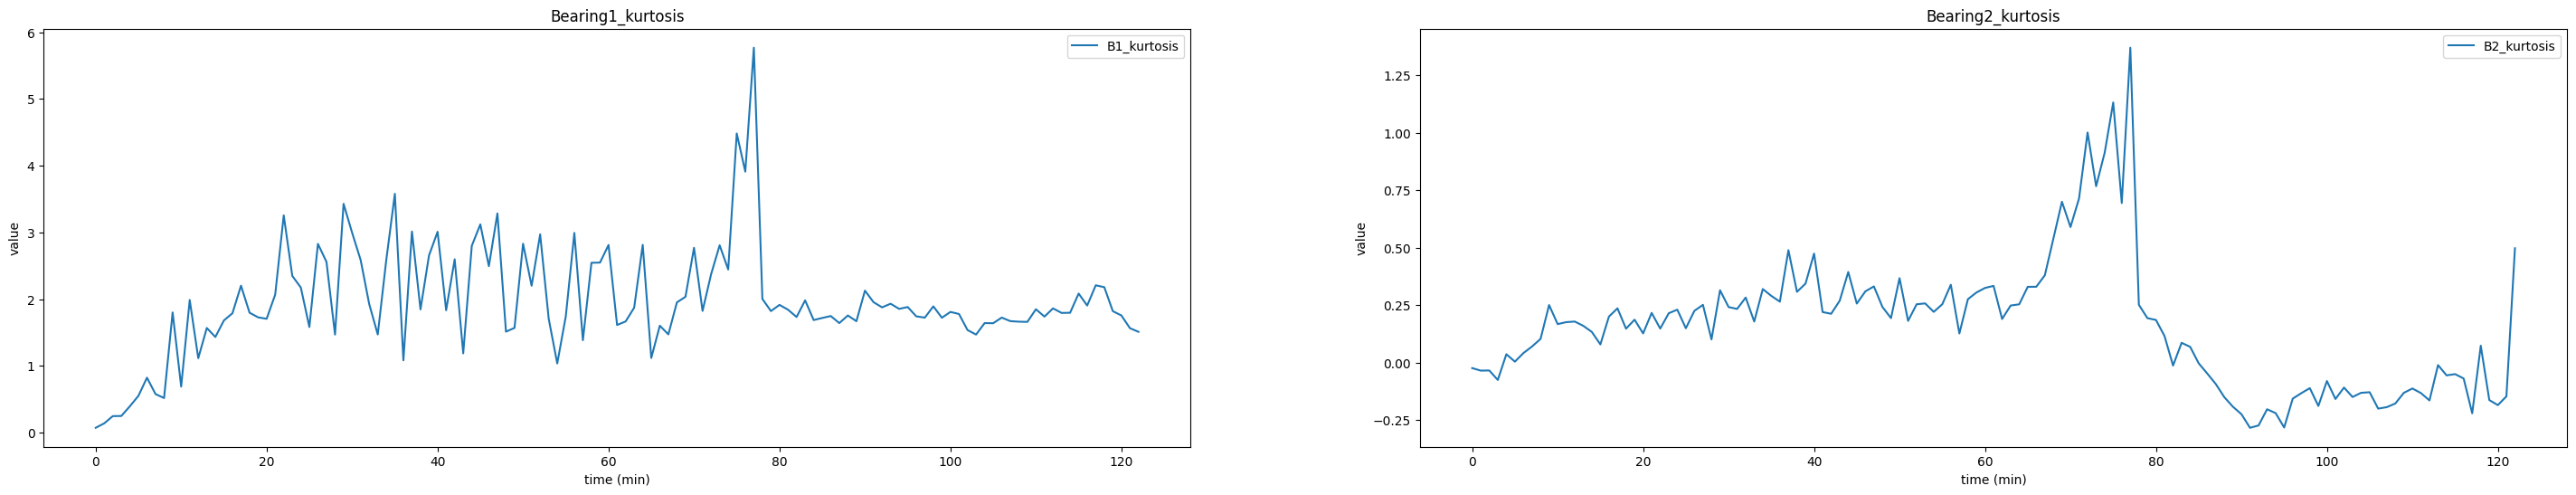

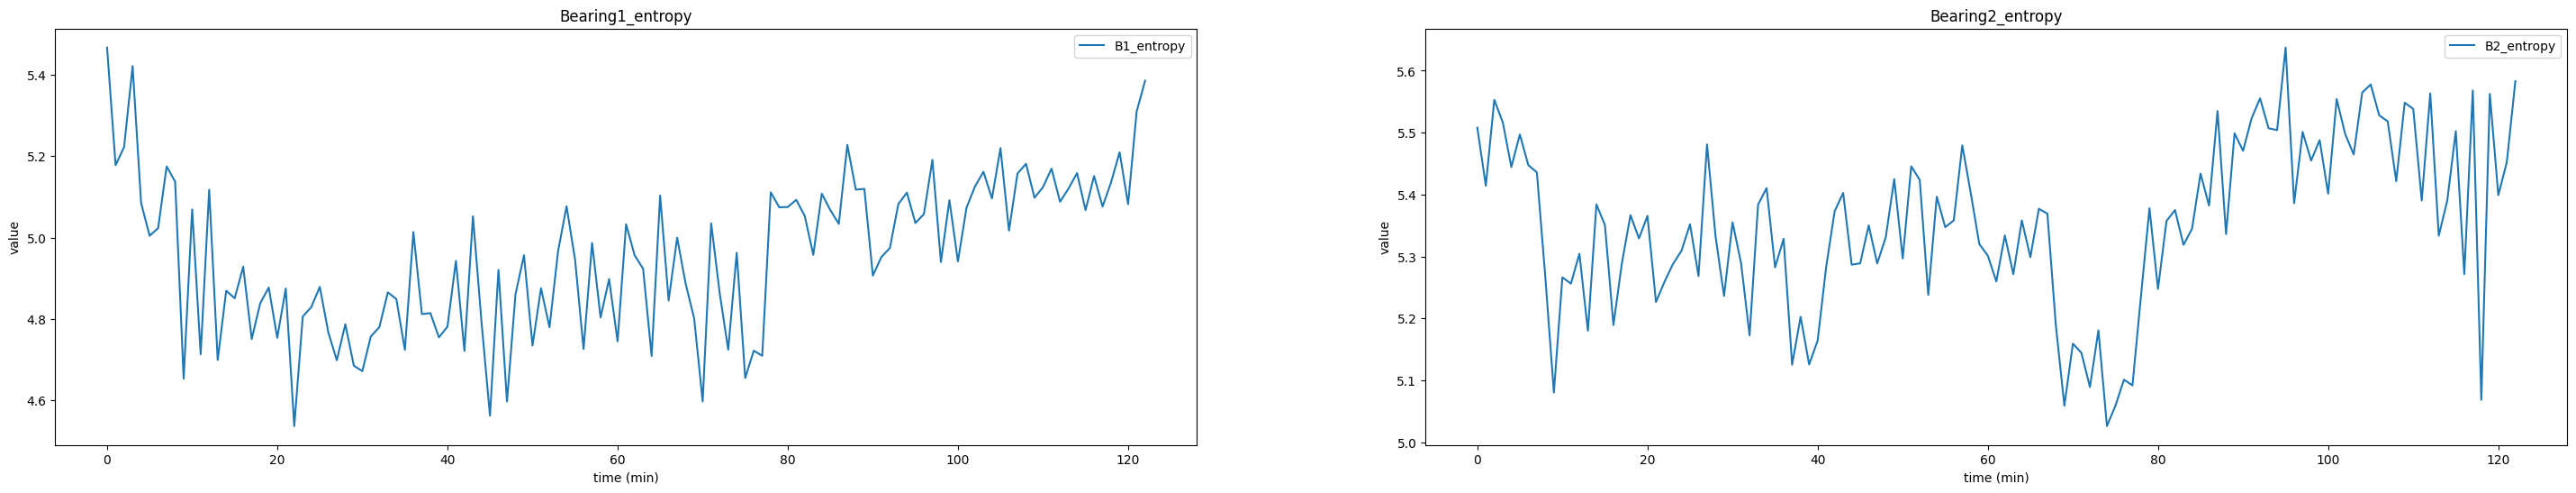

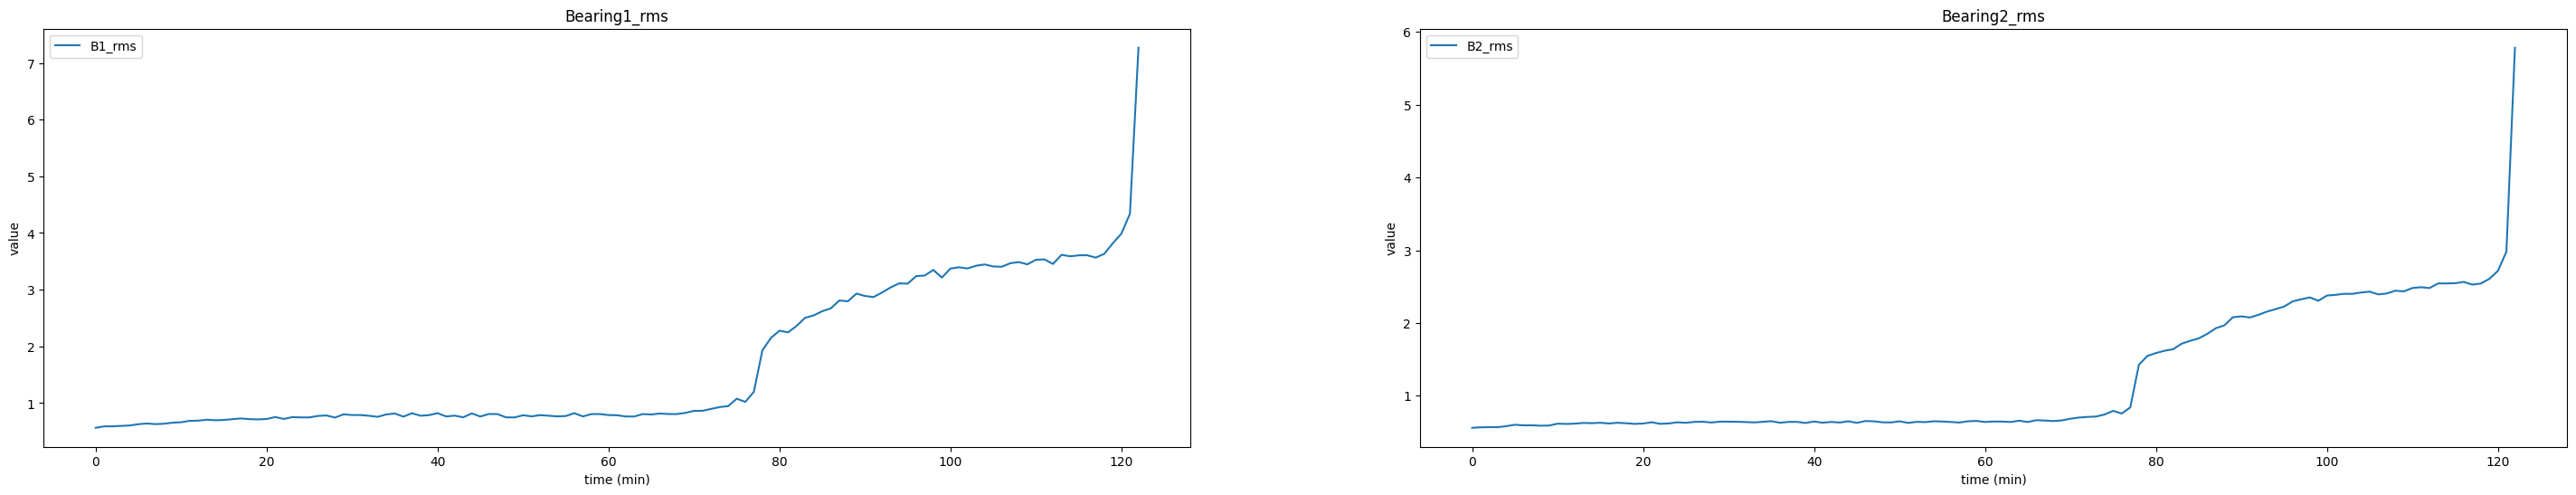

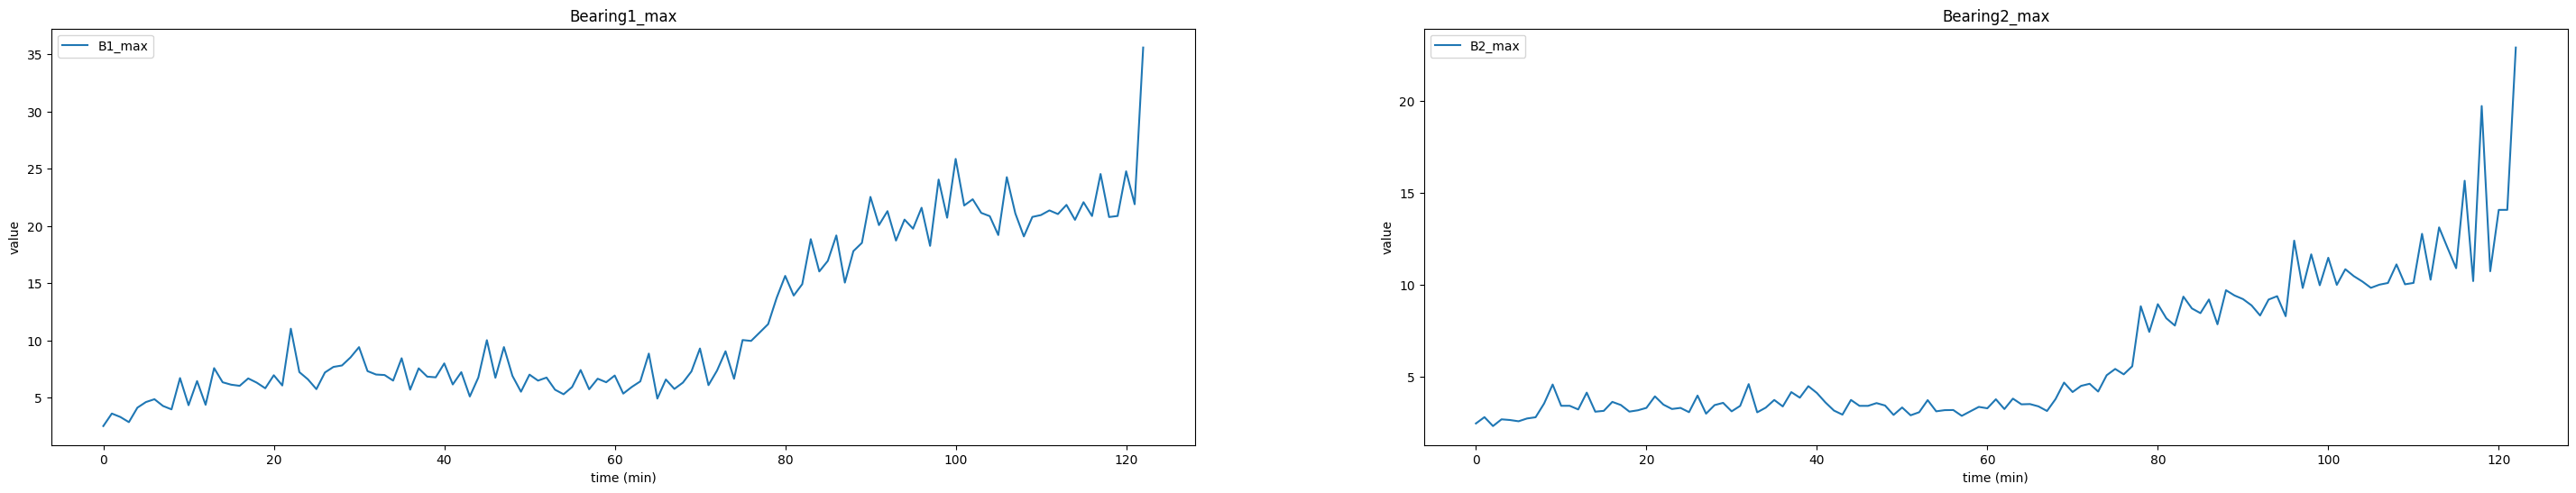

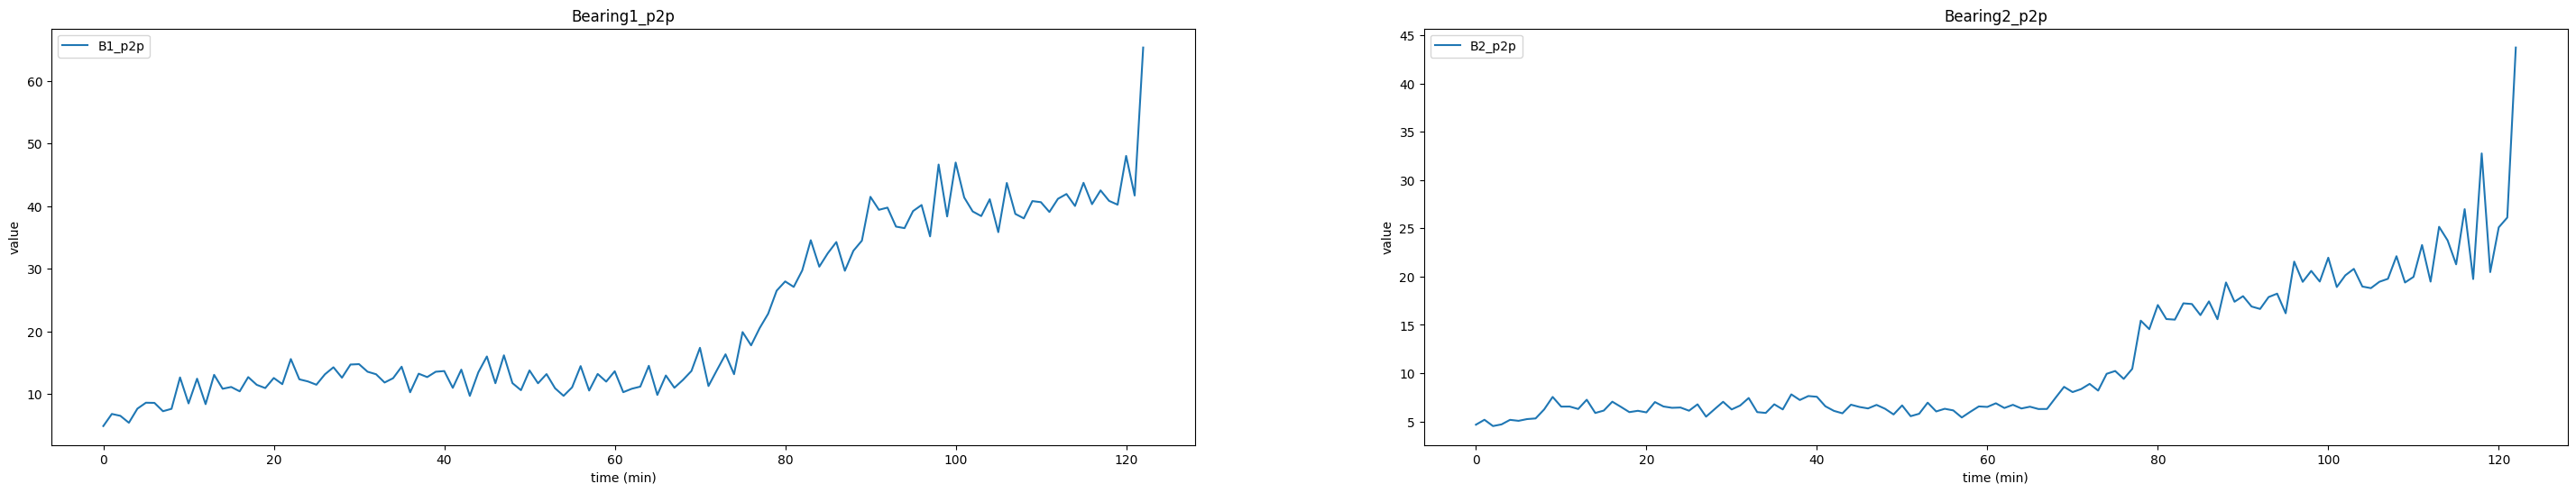

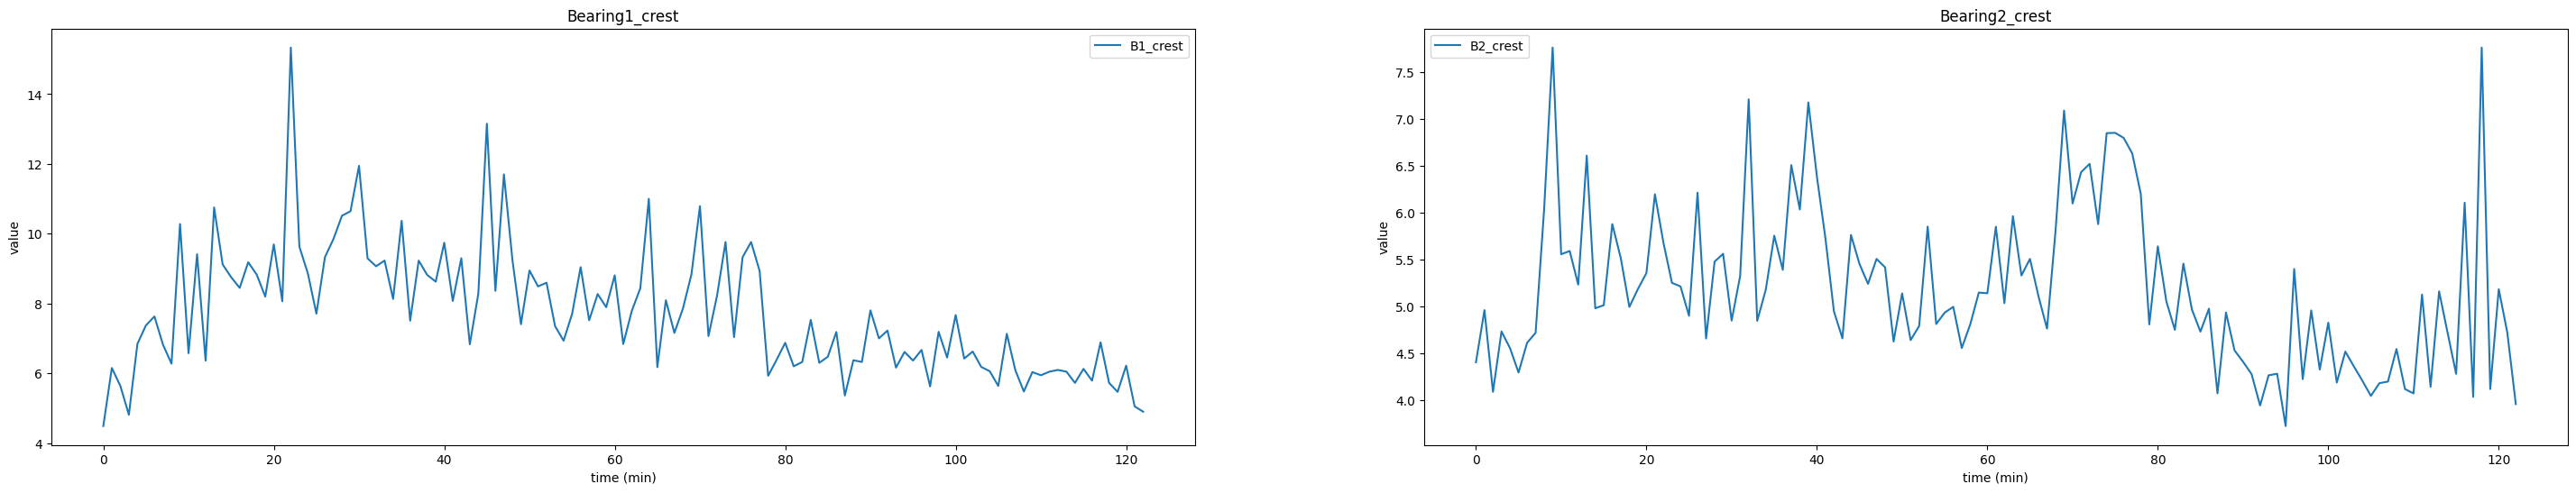

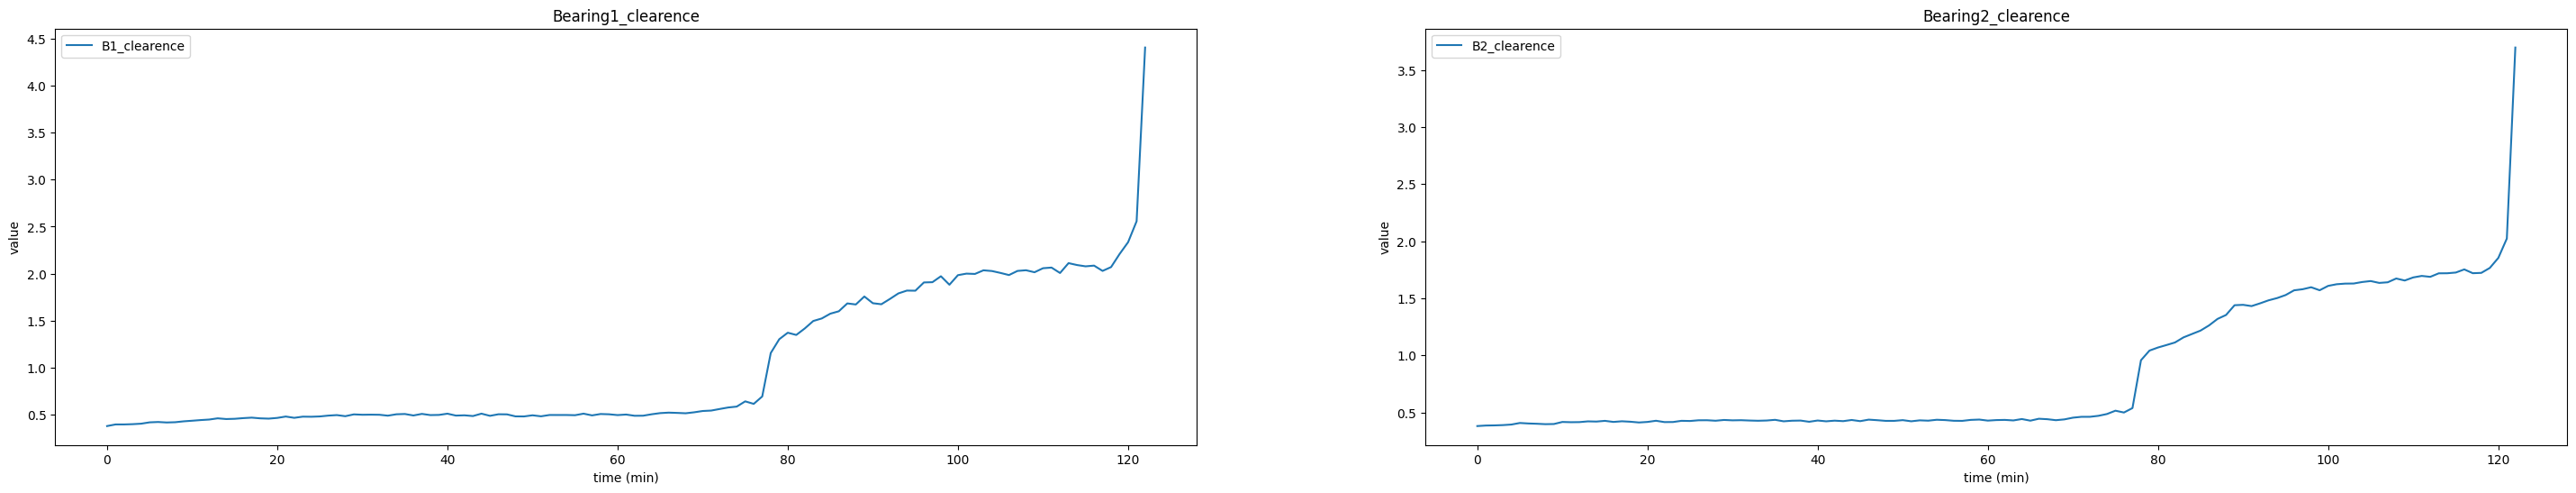

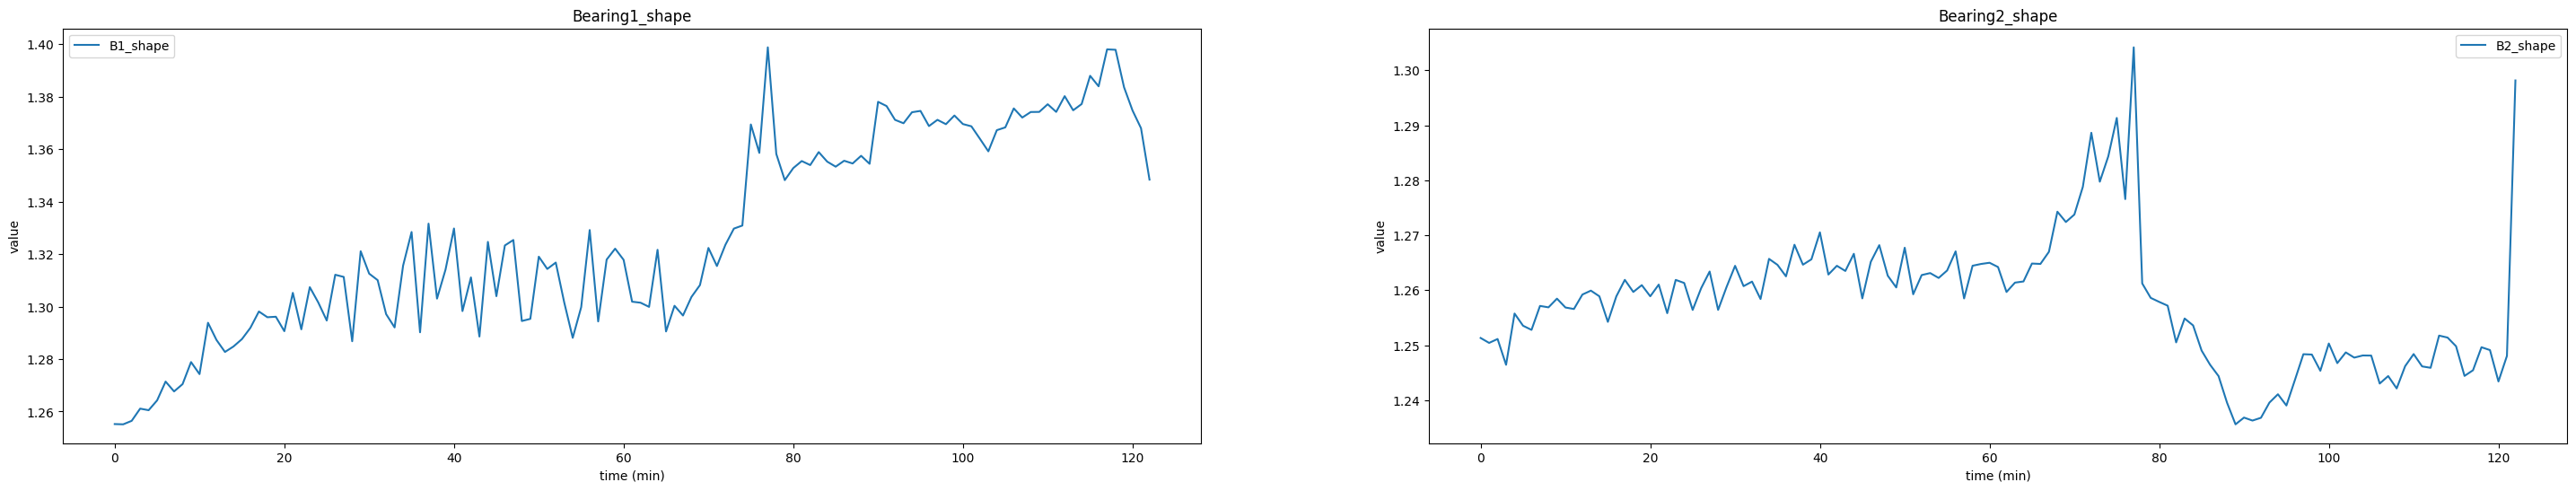

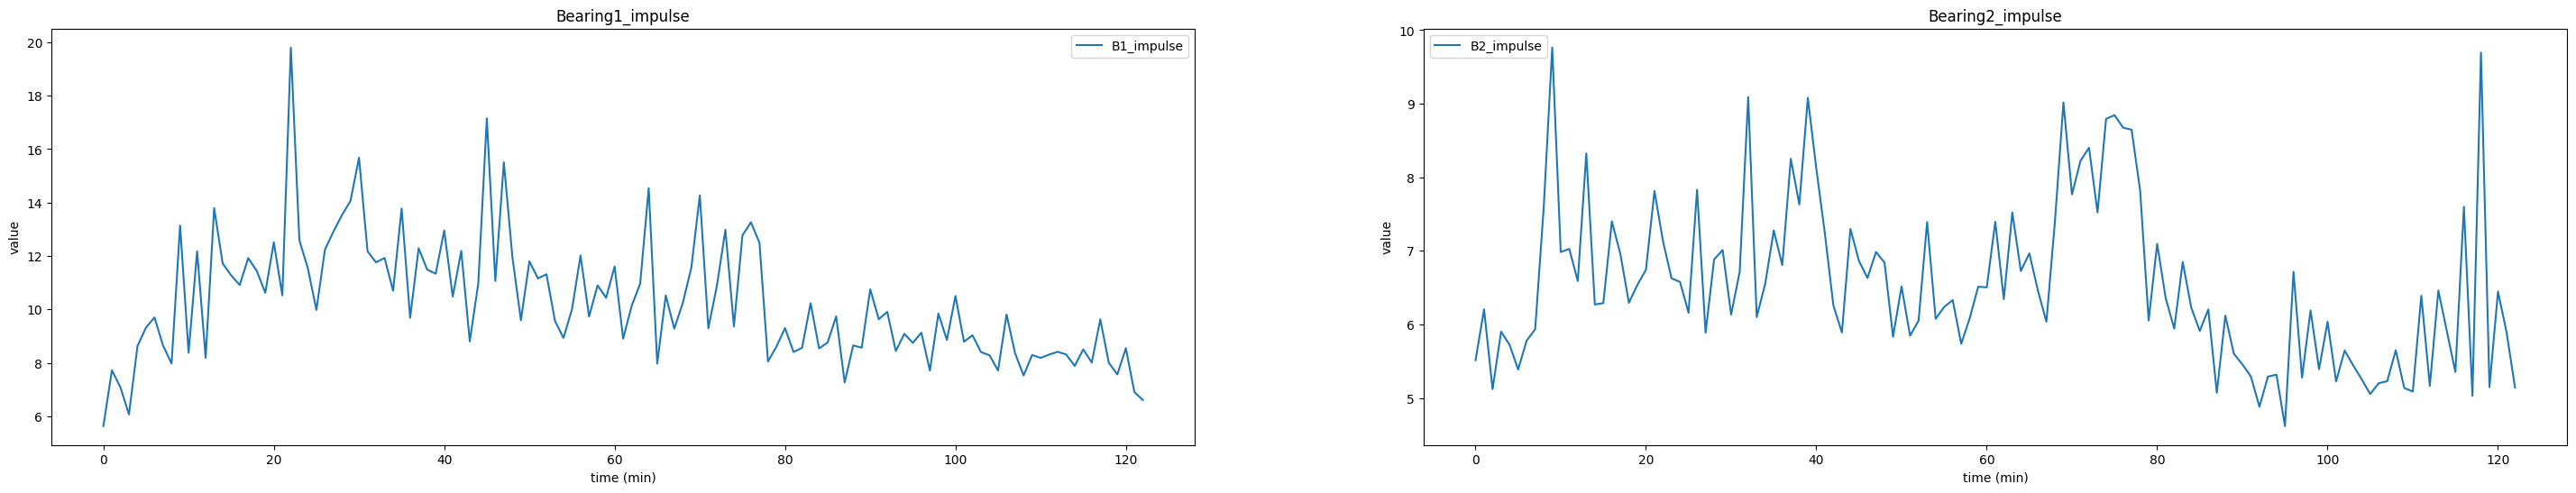

In [ ]:
time_features_list = ["mean","std","skew","kurtosis","entropy","rms","max","p2p", "crest", "clearence", "shape", "impulse"]
bearings_xy = [["B"+str(n)+"_" for n in range(1,3)] for o in ['x','y'] ] 

for tf in time_features_list:
    fig = plt.figure()
    # Divide the figure into a 1x4 grid, and give me the first section
    ax1 = fig.add_subplot(121)
    # Divide the figure into a 1x4 grid, and give me the second section
    ax2 = fig.add_subplot(122)
    #...so on
    # ax3 = fig.add_subplot(143)
    # ax4 = fig.add_subplot(144)
    # axes = [ax1,ax2,ax3, ax4]
    axes = [ax1,ax2]
        
    for i in range(2):
        col = bearings_xy[0][i]+tf
        data_sample[col].plot(figsize = (36,6), title="Bearing{}_".format(i+1)+tf , legend = True, ax=axes[i])
        # col = bearings_xy[1][i]+tf
        # set1[col].plot(figsize = (36,6) , legend = True, ax=axes[i])
        axes[i].set(xlabel="time (min)", ylabel="value")
        
    
    

[Text(0.5, 0, 'time (10 min)'), Text(0, 0.5, 'impulse(x)')]

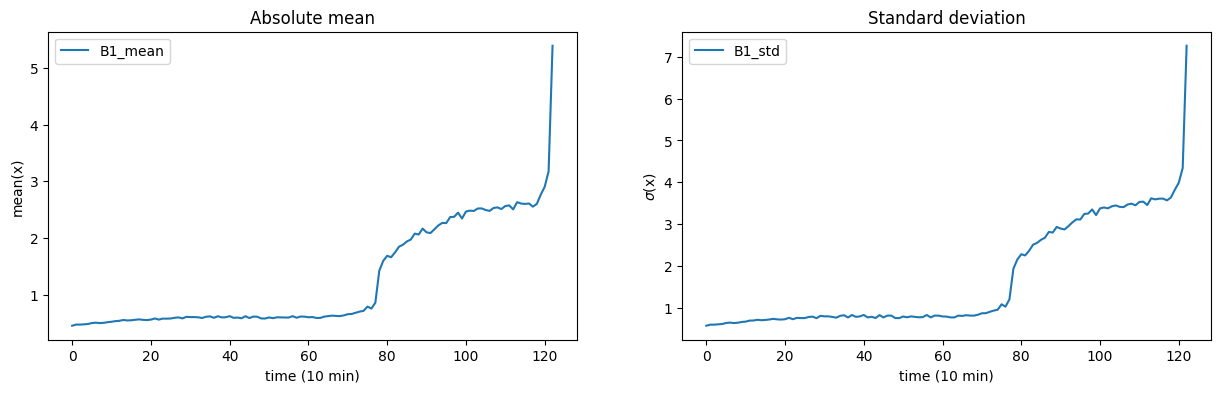

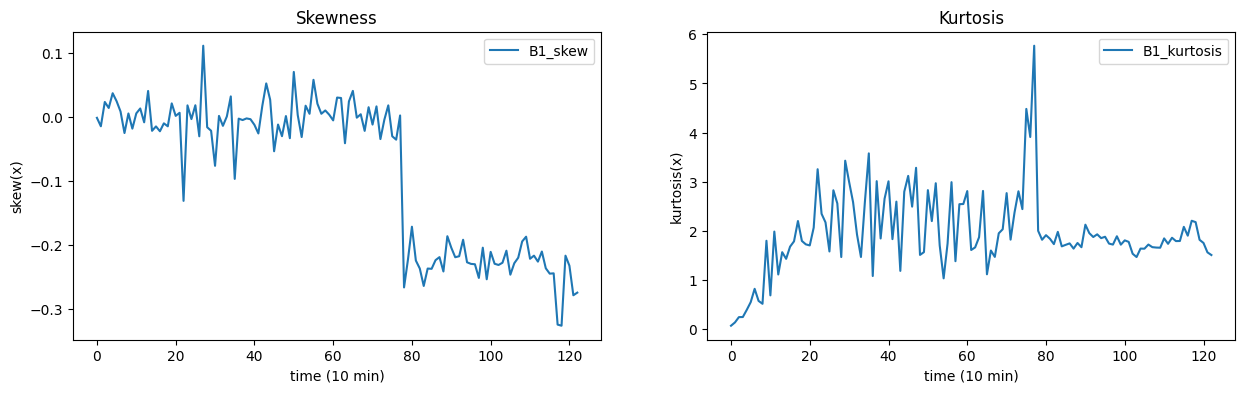

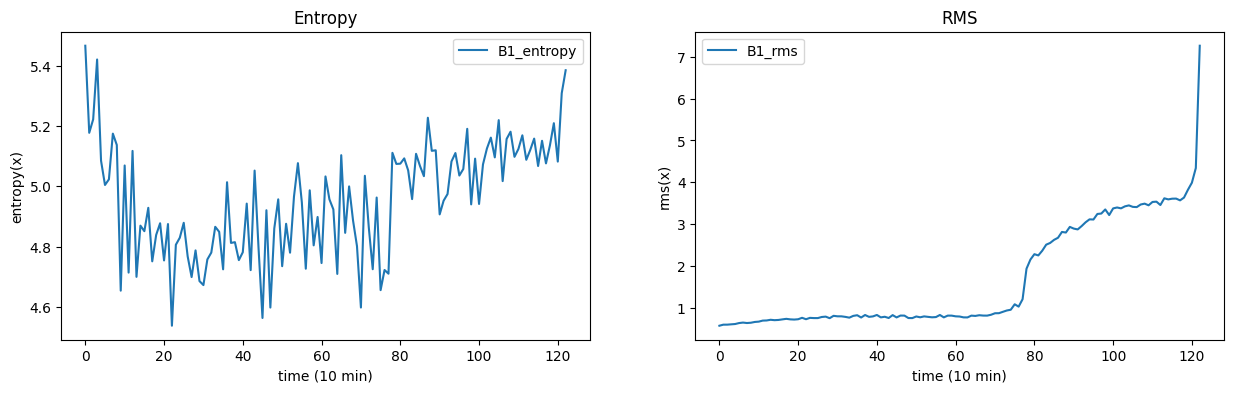

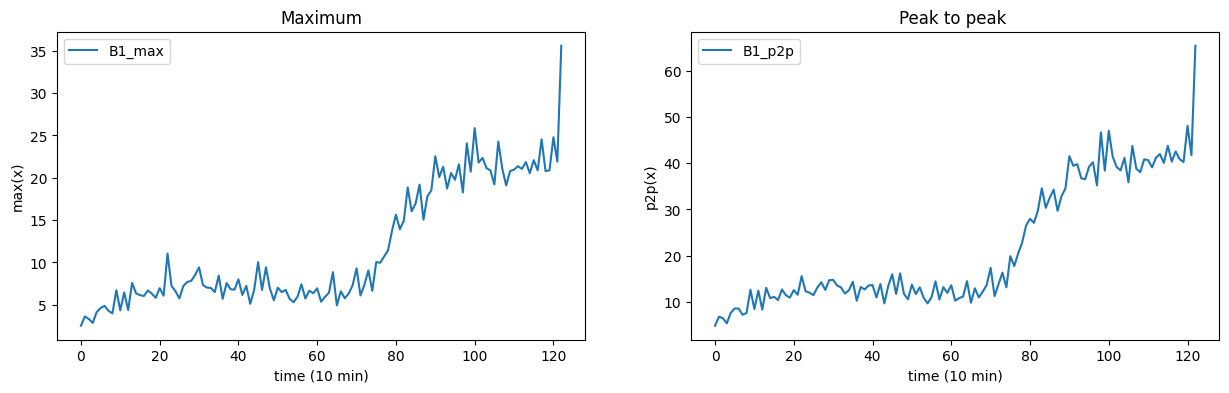

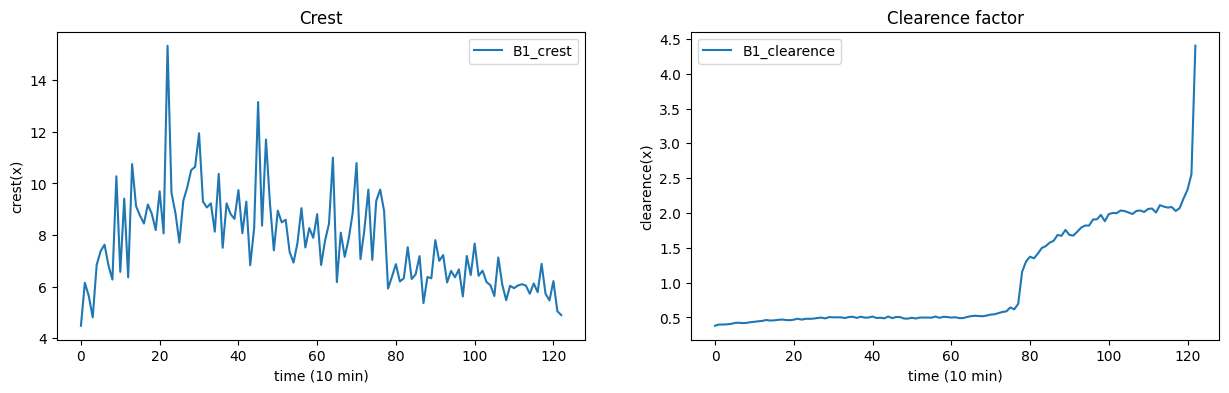

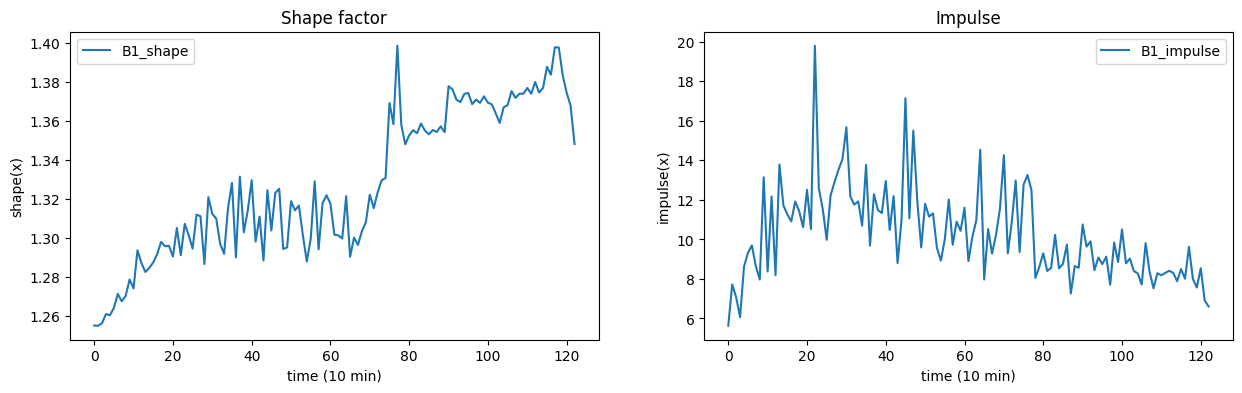

In [53]:
time_features_list = ["Absolute mean" ,"Standard deviation" ,"Skewness" ,"Kurtosis" ,"Entropy" ,"RMS" ,"Maximum" ,"Peak to peak " ,"Crest" ,"Clearence factor" ,"Shape factor" ,"Impulse"]

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1 ,ax2]

data_sample.iloc[:, 0].plot(figsize = (15,4), title= time_features_list[0] , legend = True, ax=axes[0])
axes[0].set(xlabel= "time (10 min)", ylabel= "mean(x)")
data_sample.iloc[:, 1].plot(figsize = (15,4), title= time_features_list[1] , legend = True, ax=axes[1])
axes[1].set(xlabel= "time (10 min)", ylabel= r"$\sigma$(x)")

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1 ,ax2]
        
data_sample.iloc[:, 2].plot(figsize = (15,4), title= time_features_list[2] , legend = True, ax=axes[0])
axes[0].set(xlabel= "time (10 min)", ylabel= "skew(x)")
data_sample.iloc[:, 3].plot(figsize = (15,4), title= time_features_list[3] , legend = True, ax=axes[1])
axes[1].set(xlabel= "time (10 min)", ylabel= "kurtosis(x)")

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1 ,ax2]
        
data_sample.iloc[:, 4].plot(figsize = (15,4), title=  time_features_list[4] , legend = True, ax=axes[0])
axes[0].set(xlabel= "time (10 min)", ylabel= "entropy(x)")
data_sample.iloc[:, 5].plot(figsize = (15,4), title= time_features_list[5] , legend = True, ax=axes[1])
axes[1].set(xlabel= "time (10 min)", ylabel= "rms(x)")

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1 ,ax2]
        
data_sample.iloc[:, 6].plot(figsize = (15,4), title= time_features_list[6] , legend = True, ax=axes[0])
axes[0].set(xlabel= "time (10 min)", ylabel= "max(x)")
data_sample.iloc[:, 7].plot(figsize = (15,4), title= time_features_list[7] , legend = True, ax=axes[1])
axes[1].set(xlabel= "time (10 min)", ylabel= "p2p(x)")

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1 ,ax2]
        
data_sample.iloc[:, 8].plot(figsize = (15,4), title= time_features_list[8] , legend = True, ax=axes[0])
axes[0].set(xlabel= "time (10 min)", ylabel= "crest(x)")
data_sample.iloc[:, 9].plot(figsize = (15,4), title= time_features_list[9] , legend = True, ax=axes[1])
axes[1].set(xlabel= "time (10 min)", ylabel= "clearence(x)")

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axes = [ax1 ,ax2]
        
data_sample.iloc[:, 10].plot(figsize = (15,4), title= time_features_list[10] , legend = True, ax=axes[0])
axes[0].set(xlabel= "time (10 min)", ylabel= "shape(x)")
data_sample.iloc[:, 11].plot(figsize = (15,4), title= time_features_list[11] , legend = True, ax=axes[1])
axes[1].set(xlabel= "time (10 min)", ylabel= "impulse(x)")
        

In [129]:
# set1_hil= dataset.iloc[:,1]
# duration = 1
# fs = len(dataset)
# samples = int(fs*duration)
# t = np.arange(samples) / fs

In [24]:
# analytic_signal = hilbert(set1_hil)
# amplitude_envelope = np.abs(analytic_signal)
# instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# instantaneous_frequency = (np.diff(instantaneous_phase) /
#                            (2.0*np.pi) * fs)

20479


In [66]:
dataset = pd.read_csv("./data/XJTU-SY/35Hz12kN/Bearing1_1/1.csv")
dataset_bad= pd.read_csv("./data/XJTU-SY/35Hz12kN/Bearing1_1/123.csv")
print (len(dataset))

32768


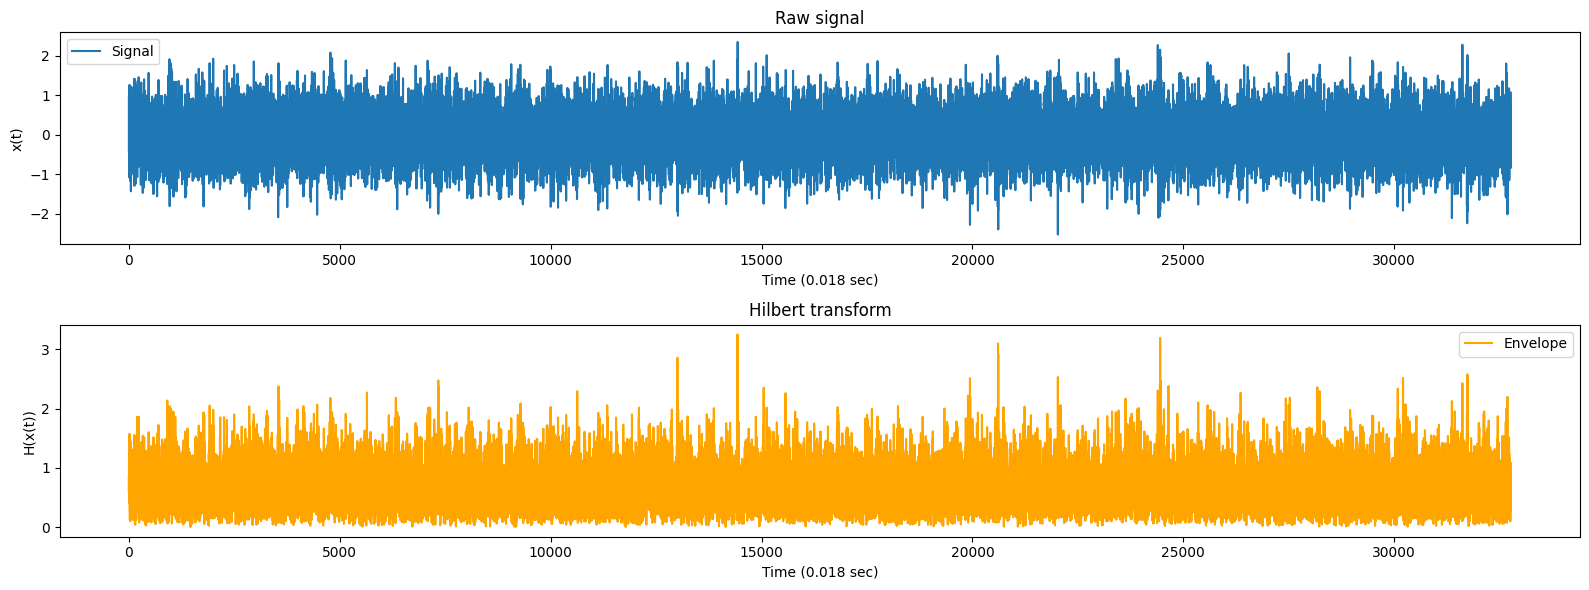

In [70]:
set1_pure= dataset.iloc[:,0]
h_signal_1 = np.abs(hilbert(set1_pure))
set2_pure= dataset.iloc[:,1]
h_signal_2 = np.abs(hilbert(set2_pure))


fig, (ax0, ax1) = plt.subplots(figsize=(16, 6), nrows=2)
ax0.plot(set1_pure, label='Signal')
ax0.set_title("Raw signal")
ax0.set_xlabel("Time (0.018 sec)")
ax0.set_ylabel("x(t)")
ax0.legend()
ax1.plot(h_signal_1, label='Envelope', color= 'orange')
ax1.set_title("Hilbert transform")
ax1.set_xlabel("Time (0.018 sec)")
ax1.set_ylabel("H(x(t))")
ax1.legend()
fig.tight_layout()

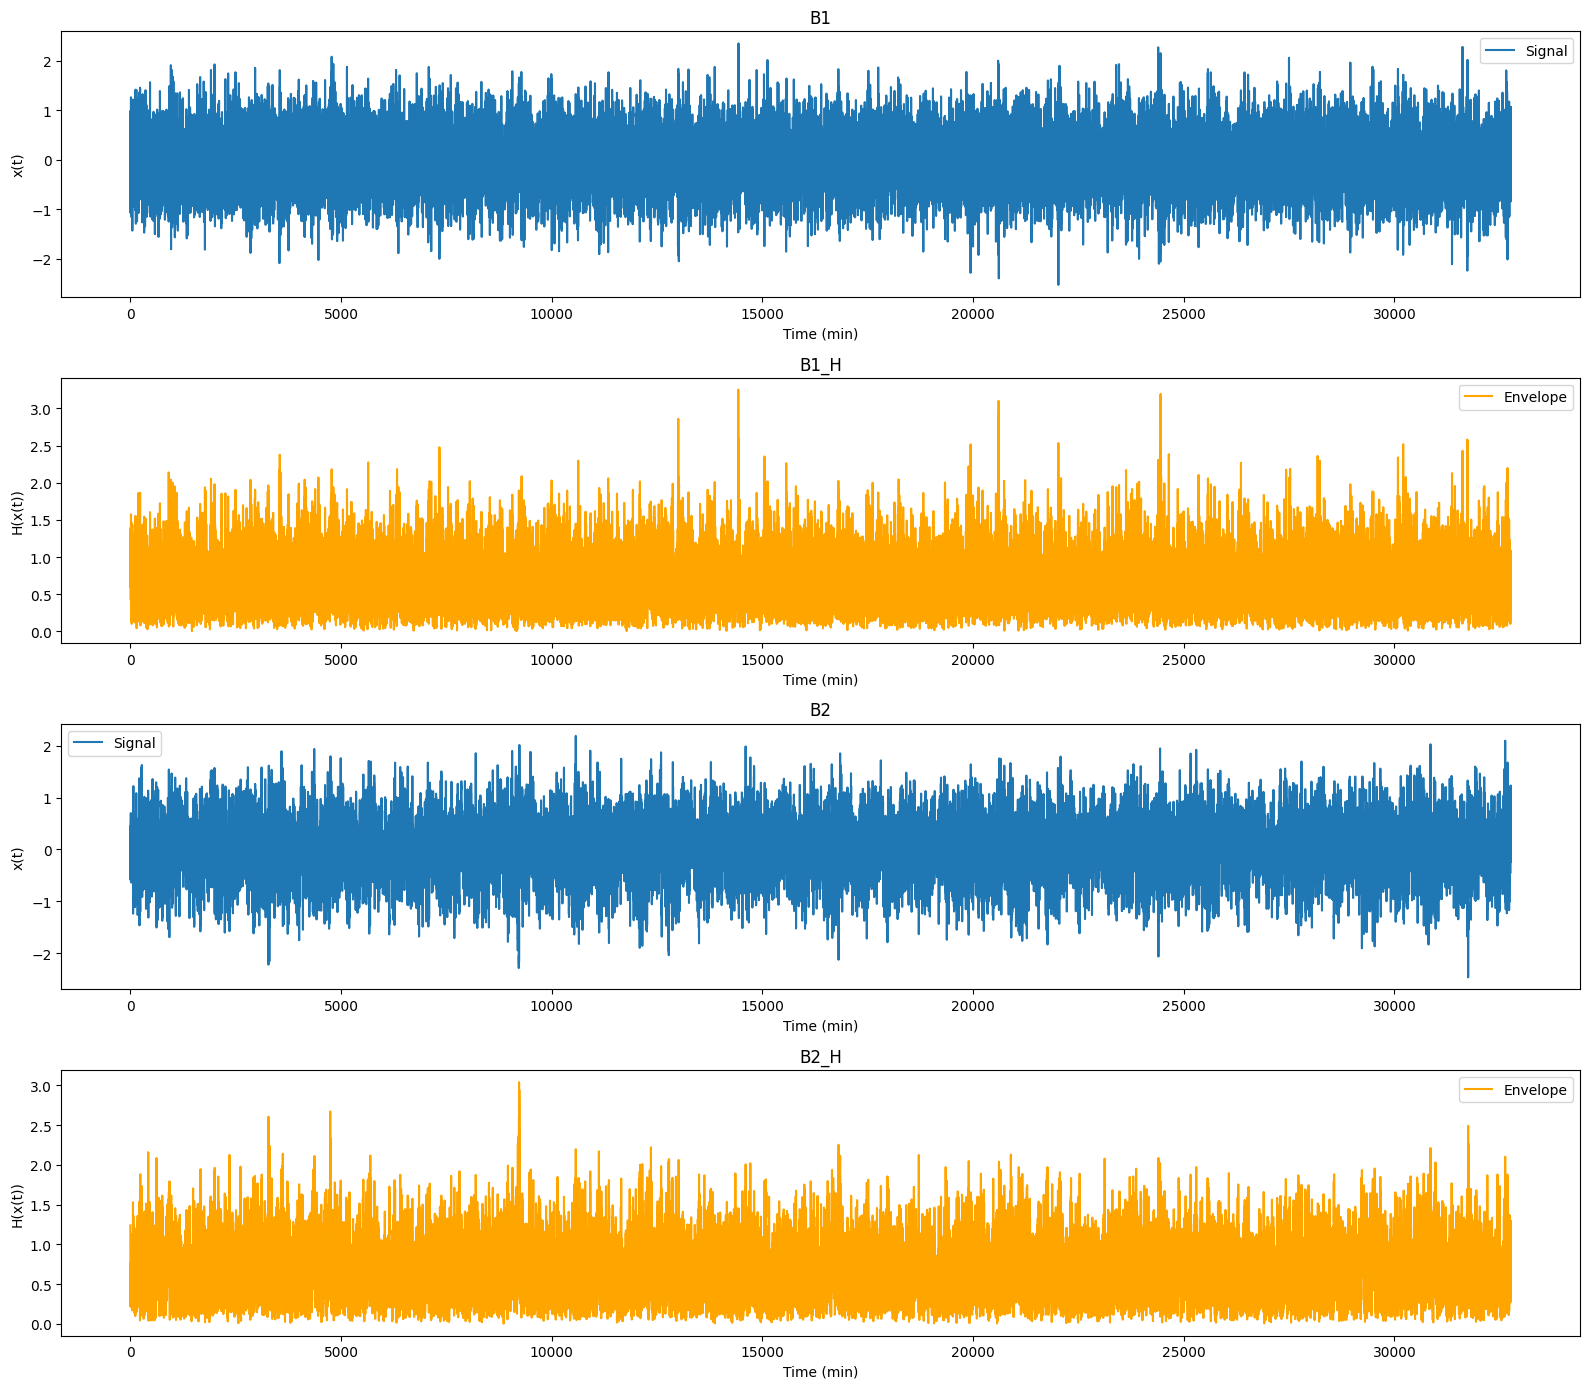

In [58]:
set1_pure= dataset.iloc[:,0]
h_signal_1 = np.abs(hilbert(set1_pure))
set2_pure= dataset.iloc[:,1]
h_signal_2 = np.abs(hilbert(set2_pure))


fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(16, 14), nrows=4)
ax0.plot(set1_pure, label='Signal')
ax0.set_title("B1")
ax0.set_xlabel("Time (min)")
ax0.set_ylabel("x(t)")
ax0.legend()
ax1.plot(h_signal_1, label='Envelope', color= 'orange')
ax1.set_title("B1_H")
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("H(x(t))")
ax1.legend()

ax2.plot(set2_pure, label='Signal')
ax2.set_title("B2")
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("x(t)")
ax2.legend()
ax3.plot(h_signal_2, label='Envelope', color= 'orange')
ax3.set_title("B2_H")
ax3.set_xlabel("Time (min)")
ax3.set_ylabel("H(x(t))")
ax3.legend()

fig.tight_layout()

In [68]:
#sine information
set1_fft_r= np.fft.fft(h_signal_1).real
set2_fft_r= np.fft.fft(h_signal_2).real


#cosine information
set1_fft_i= np.fft.fft(h_signal_1).imag
set2_fft_i= np.fft.fft(h_signal_2).imag


#magnitude
set1_fft= np.abs(np.fft.fft(h_signal_1) /len (h_signal_1))
set2_fft= np.abs(np.fft.fft(h_signal_2) /len (h_signal_2))


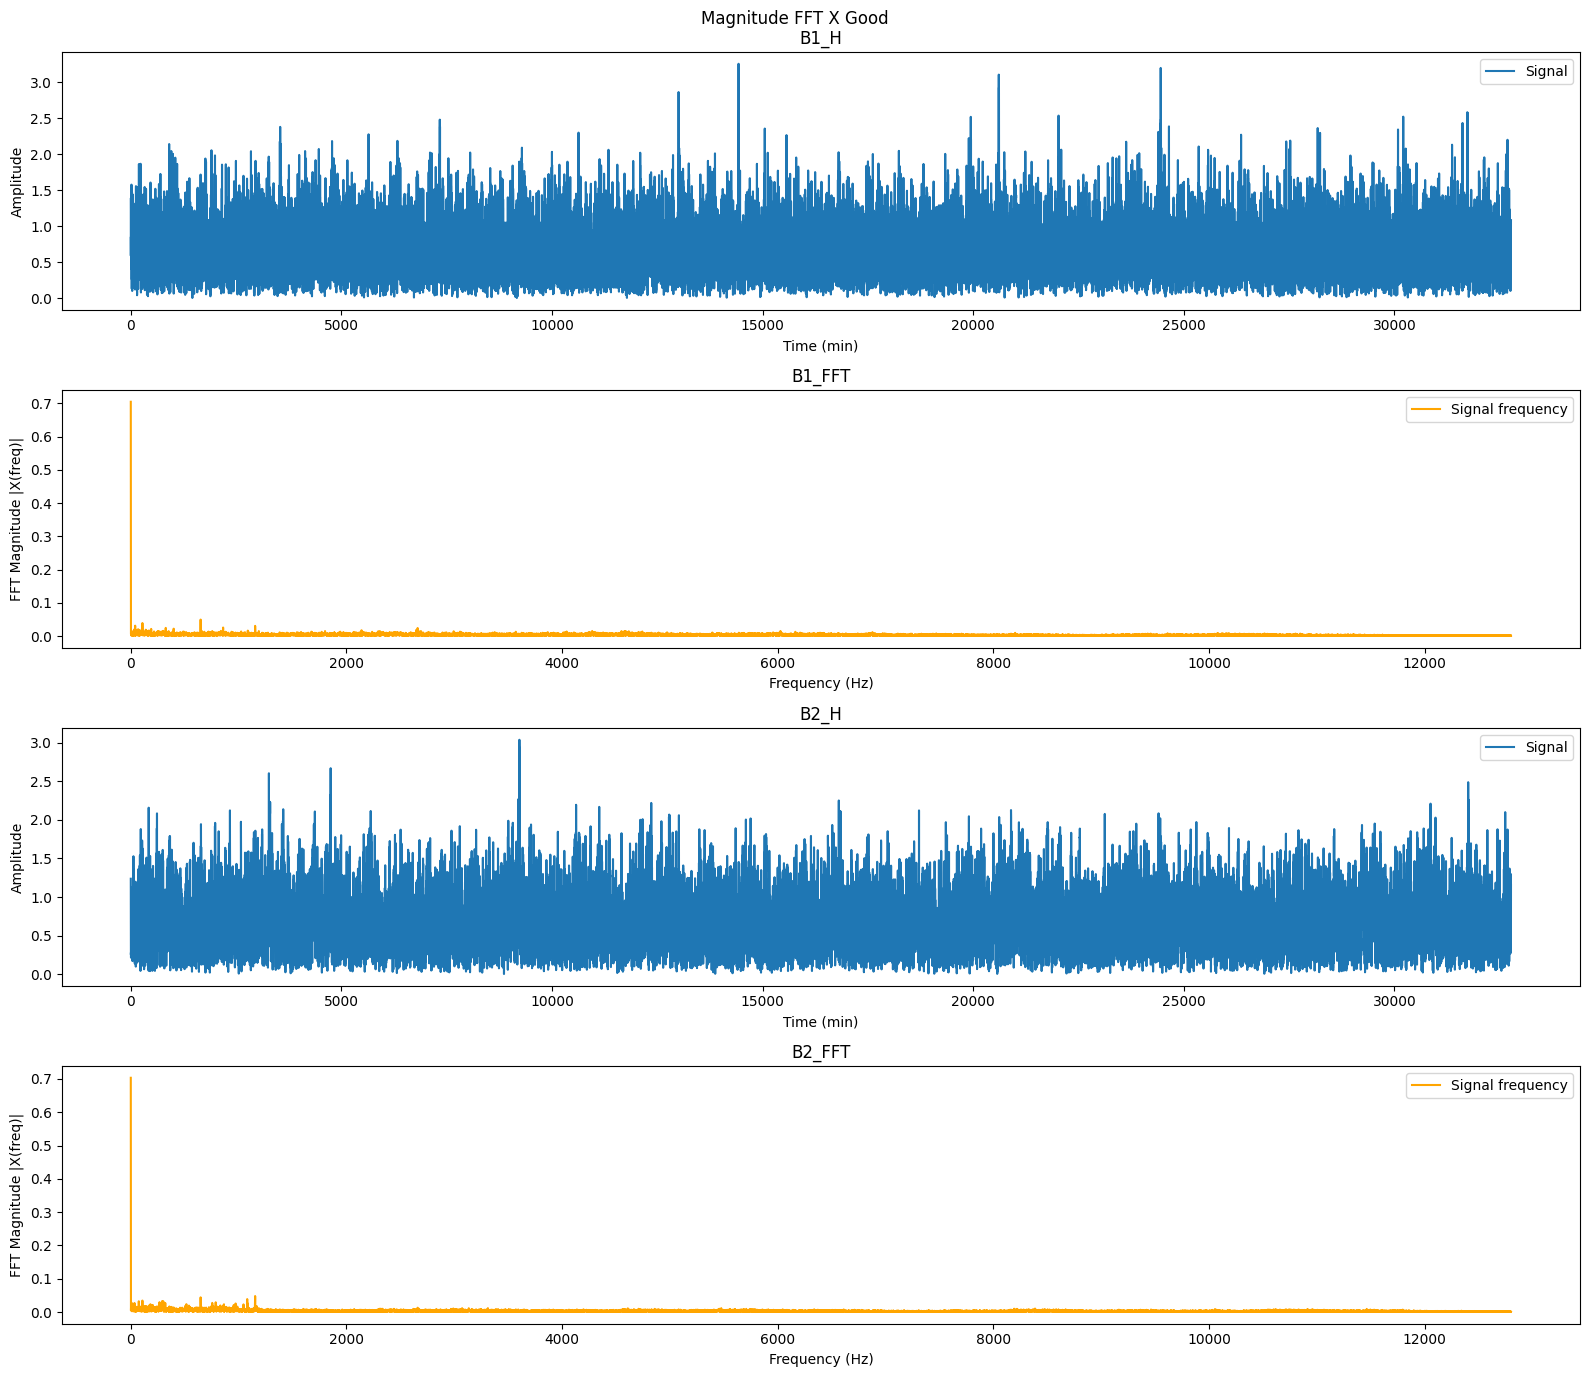

In [69]:
N = len(set1_fft)

#From the specs of XJTU-SY dataset
Fsamp = 25600

Ts = 1/Fsamp

# timestep = 10
# freq = np.fft.fftfreq(N, d=timestep)

t= np.linspace(0, (N-1)*Ts, N)
Fs= Fsamp/ N
f= np.linspace(0, (N-1)*Fs, N)

f_plot= f[0:int(N/2+1)]
set1_fft_mag= 2 * set1_fft [0:int(N/2+1)]
set1_fft_mag[0]= set1_fft_mag[0] / 2
set2_fft_mag= 2 * set2_fft [0:int(N/2+1)]
set2_fft_mag[0]= set2_fft_mag[0] / 2


fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(16, 14), nrows=4)
ax0.plot(h_signal_1, label='Signal')
ax0.set_title("B1_H")
ax0.set_xlabel("Time (min)")
ax0.set_ylabel("Amplitude")
ax0.legend()
ax1.plot(f_plot, set1_fft_mag, label='Signal frequency', color= 'orange')
ax1.set_title("B1_FFT")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("FFT Magnitude |X(freq)|")
ax1.legend()

ax2.plot(h_signal_2, label='Signal')
ax2.set_title("B2_H")
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Amplitude")
ax2.legend()
ax3.plot(f_plot, set2_fft_mag, label='Signal frequency', color= 'orange')
ax3.set_title("B2_FFT")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel("FFT Magnitude |X(freq)|")
ax3.legend()

fig.suptitle('Magnitude FFT X Good')
fig.tight_layout()

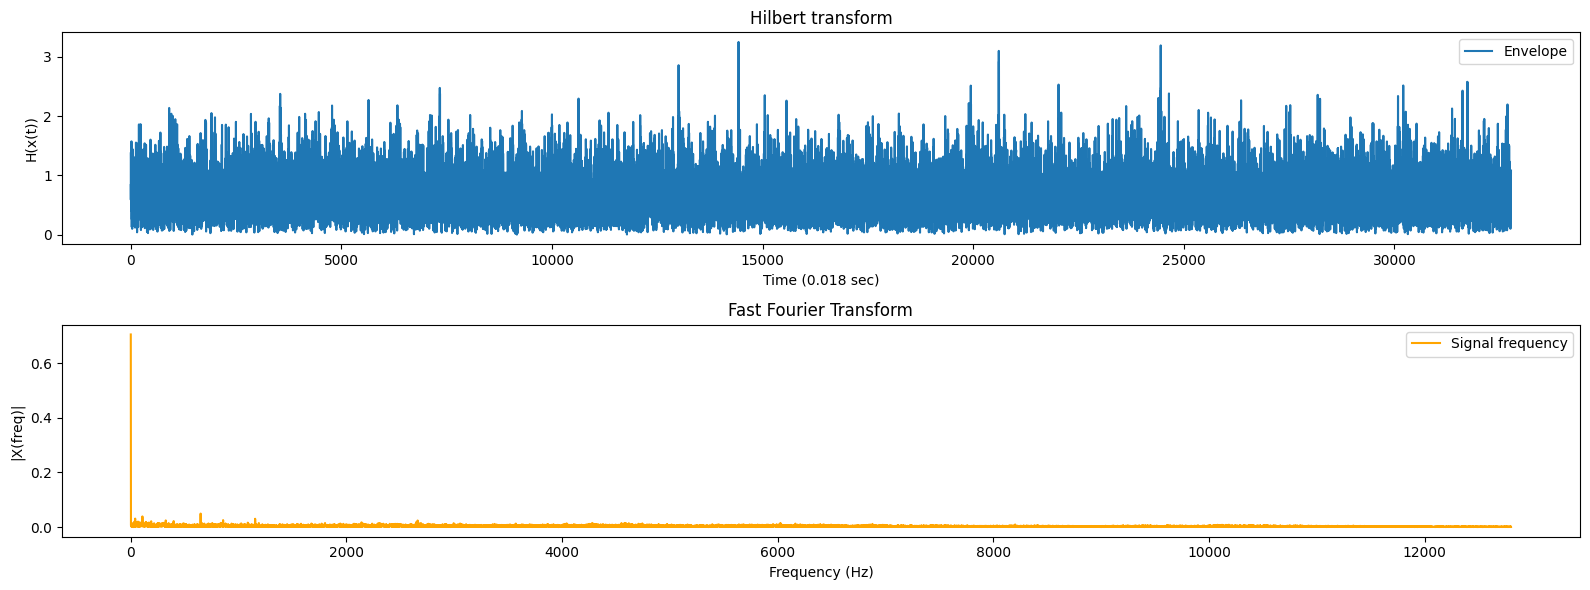

In [72]:
fig, (ax0, ax1) = plt.subplots(figsize=(16, 6), nrows=2)
ax0.plot(h_signal_1, label='Envelope')
ax0.set_title("Hilbert transform")
ax0.set_xlabel("Time (0.018 sec)")
ax0.set_ylabel("H(x(t))")
ax0.legend()
ax1.plot(f_plot, set1_fft_mag, label='Signal frequency', color= 'orange')
ax1.set_title("Fast Fourier Transform")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("|X(freq)|")
ax1.legend()
fig.tight_layout()

In [160]:
set1_pure= dataset_bad.iloc[:,0]
h_signal_1 = np.abs(hilbert(set1_pure))
set2_pure= dataset_bad.iloc[:,1]
h_signal_2 = np.abs(hilbert(set2_pure))

set1_fft= np.abs(np.fft.fft(h_signal_1) /len (h_signal_1))
set2_fft= np.abs(np.fft.fft(h_signal_2) /len (h_signal_2))

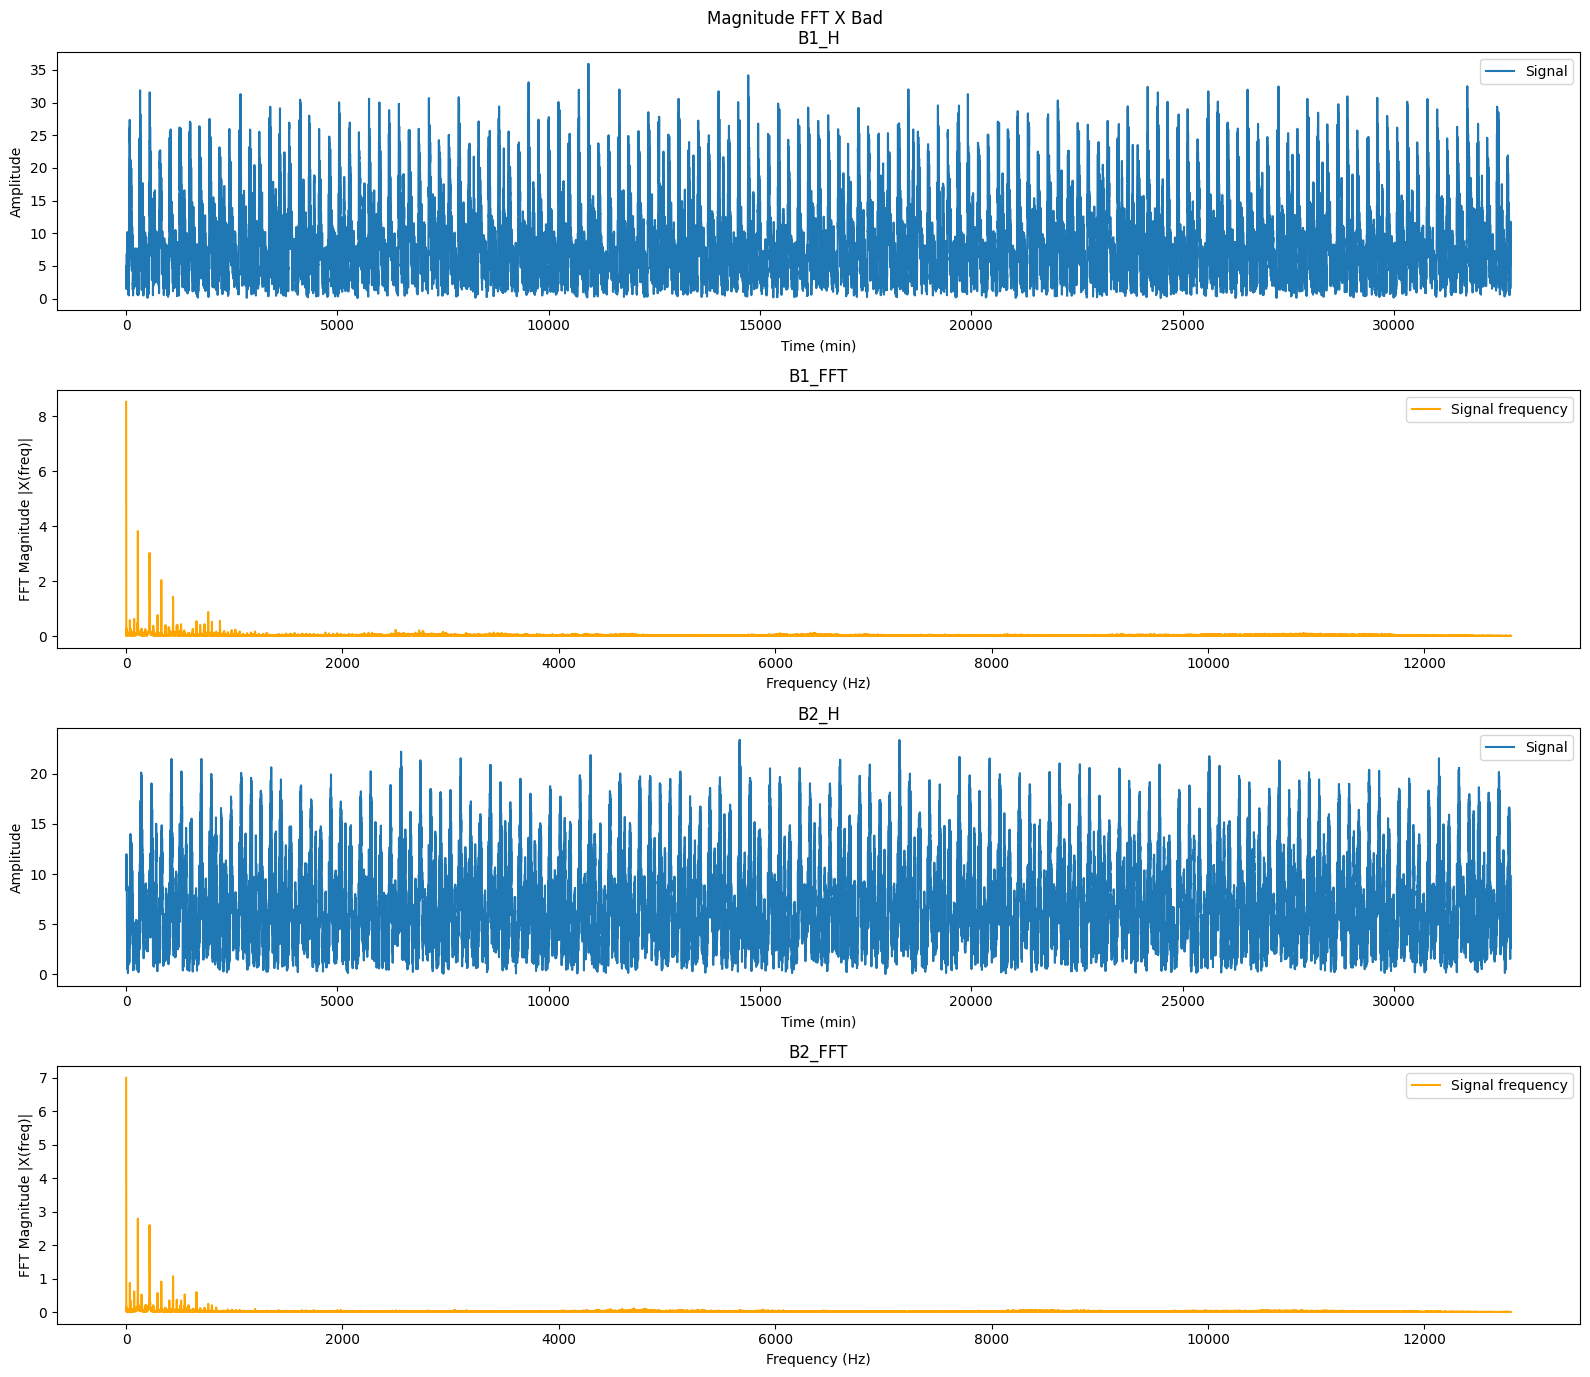

In [161]:
N = len(set1_fft)

#From the specs of XJTU-SY dataset
Fsamp = 25600

Ts = 1/Fsamp

# timestep = 10
# freq = np.fft.fftfreq(N, d=timestep)

t= np.linspace(0, (N-1)*Ts, N)
Fs= Fsamp/ N
f= np.linspace(0, (N-1)*Fs, N)

f_plot= f[0:int(N/2+1)]
set1_fft_mag= 2 * set1_fft [0:int(N/2+1)]
set1_fft_mag[0]= set1_fft_mag[0] / 2
set2_fft_mag= 2 * set2_fft [0:int(N/2+1)]
set2_fft_mag[0]= set2_fft_mag[0] / 2


fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(16, 14), nrows=4)
ax0.plot(h_signal_1, label='Signal')
ax0.set_title("B1_H")
ax0.set_xlabel("Time (min)")
ax0.set_ylabel("Amplitude")
ax0.legend()
ax1.plot(f_plot, set1_fft_mag, label='Signal frequency', color= 'orange')
ax1.set_title("B1_FFT")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("FFT Magnitude |X(freq)|")
ax1.legend()

ax2.plot(h_signal_2, label='Signal')
ax2.set_title("B2_H")
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Amplitude")
ax2.legend()
ax3.plot(f_plot, set2_fft_mag, label='Signal frequency', color= 'orange')
ax3.set_title("B2_FFT")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel("FFT Magnitude |X(freq)|")
ax3.legend()

fig.suptitle('Magnitude FFT X Bad')
fig.tight_layout()

# Unsupervised

In [7]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
import tensorflow as tf
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv1D,MaxPooling1D,UpSampling1D,Conv1DTranspose,BatchNormalization,Lambda
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
label_dict = {
 0: 'Low',
 1: 'Medium',
 2: 'High',
}

In [146]:
batch_size = 64
epochs = 200
inChannel = 1
x = len(set1_fft)

train_data = set1_fft.reshape(-1, 1)
test_data = set2_fft.reshape(-1, 1)

train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2)

input_sig = Input(shape = (x, inChannel))
print (input_sig)
num_classes = 3

KerasTensor(type_spec=TensorSpec(shape=(None, 20479, 1), dtype=tf.float32, name='input_21'), name='input_21', description="created by layer 'input_21'")


In [132]:
def classifier_func(x):
    return x+x*K.one_hot(K.argmax(x, axis=1), num_classes= num_classes)

In [147]:
def encoder(input_sig, num_classes):

    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    #print(tf.shape(input_sig))
    conv1 = Conv1D(32, (3), activation='relu', padding='same',input_shape=(20479, 1))(input_sig) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv1D(32, (3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(pool_size=(2), padding= 'same')(conv1) #14 x 14 x 32
    conv2 = Conv1D(64, (3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(64, (3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(pool_size= (2), padding='same')(conv2) #7 x 7 x 64
    conv3 = Conv1D(128, (3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv1D(128, (3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv1D(256, (3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv1D(256, (3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    den = Dense(128, activation='relu')(conv4)
    out = Dense(num_classes, activation='softmax')(den)
    return out

def decoder(out):    
    #decoder
    conv5 = Conv1D(128, (3), activation='relu', padding='same')(out) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv1D(128, (3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv1D(64, (3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv1D(64, (3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling1D((2))(conv6) #14 x 14 x 64
    conv7 = Conv1D(32, (3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv1D(32, (3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling1D((2))(conv7) # 28 x 28 x 32
    decoded = Conv1D(1, (3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [148]:
autoencoder = Model(input_sig, decoder(encoder(input_sig, num_classes)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [149]:
autoencoder.summary()
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 20479, 1)]        0         
                                                                 
 conv1d_499 (Conv1D)         (None, 20479, 32)         128       
                                                                 
 batch_normalization_468 (Ba  (None, 20479, 32)        128       
 tchNormalization)                                               
                                                                 
 conv1d_500 (Conv1D)         (None, 20479, 32)         3104      
                                                                 
 batch_normalization_469 (Ba  (None, 20479, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_78 (MaxPoolin  (None, 10240, 32)        0  

In [150]:
autoencoder.save_weights('models_autoencoder/autoencoder')

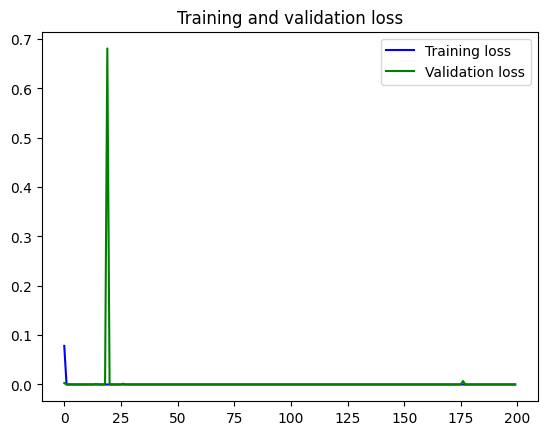

In [151]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, label='Training loss', color= "blue")
plt.plot(epochs, val_loss, label='Validation loss', color= "green")
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# # Change the labels from categorical to one-hot encoding
# train_Y_one_hot = to_categorical(train_labels)
# test_Y_one_hot = to_categorical(test_labels)

# # Display the change for category label using one-hot encoding
# print('Original label:', train_labels[0])
# print('After conversion to one-hot:', train_Y_one_hot[0])

In [110]:
# train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_data,test_size=0.2,random_state=13)

In [111]:
# def fc(enco):
#     flat = Flatten()(enco)
#     den = Dense(128, activation='relu')(flat)
#     out = Dense(num_classes, activation='softmax')(den)
#     return out

In [152]:
encode = encoder(input_sig, num_classes)
full_model = Model(input_sig,encode)
full_model.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 20479, 1)]        0         
                                                                 
 conv1d_514 (Conv1D)         (None, 20479, 32)         128       
                                                                 
 batch_normalization_482 (Ba  (None, 20479, 32)        128       
 tchNormalization)                                               
                                                                 
 conv1d_515 (Conv1D)         (None, 20479, 32)         3104      
                                                                 
 batch_normalization_483 (Ba  (None, 20479, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_80 (MaxPoolin  (None, 10240, 32)        0  

In [155]:
encode = full_model.predict(train_X)

print(label_dict)
    
neuron_class = np.zeros((num_classes))
for i in range(num_classes):
    neuron_class[i] = np.argmax(label_dict[i], axis=0)

print(neuron_class)

encode = full_model.predict(valid_X)

print (encode)

predicted = np.argmax(encode, axis=1)
for i, sample in enumerate(predicted):
    predicted[i] = neuron_class[predicted[i]]
print(neuron_class)

512/512 [==============================] - 2s 4ms/step
{0: 'Low', 1: 'Medium', 2: 'High'}
[0. 0. 0.]
128/128 [==============================] - 1s 4ms/step
[[[0.33333334 0.33333337 0.33333334]]

 [[0.33333334 0.33333337 0.33333334]]

 [[0.3333333  0.33333334 0.3333333 ]]

 ...

 [[0.33333334 0.33333337 0.33333334]]

 [[0.33333334 0.33333337 0.33333334]]

 [[0.3333333  0.33333334 0.3333333 ]]]
[0. 0. 0.]


# Supervised statistic

In [73]:
import scipy.stats as st
import statsmodels.stats.weightstats as stat

#freq column 12:17 for B1 and 32:37
B1_mean,B1_std,B1_skew,B1_kurtosis,B1_entropy,B1_rms,B1_max,B1_p2p,B1_crest,B1_clearence,B1_shape,B1_impulse,B1_freq_band_1,B1_freq_band_2,B1_freq_band_3,B1_freq_band_4,B1_freq_band_5,B1_Event,B1_Survival_time,B2_mean,B2_std,B2_skew,B2_kurtosis,B2_entropy,B2_rms,B2_max,B2_p2p,B2_crest,B2_clearence,B2_shape,B2_impulse,B2_freq_band_1,B2_freq_band_2,B2_freq_band_3,B2_freq_band_4,B2_freq_band_5,B2_Event,B2_Survival_time

In [47]:
dataset_path = "./data/XJTU-SY/csv/"
set_analytic= pd.DataFrame()
set_covariates= pd.DataFrame()
set_boot= pd.DataFrame()

for filename in os.listdir(dataset_path):

    i= 0

    if re.search('^Bearing.*timefeature', filename):
        datafile = pd.read_csv(os.path.join(dataset_path, filename))
        set_analytic_aux= datafile.iloc[:, 12: 17]
        set_cov_aux= datafile.iloc[:, 0: 12]
        set_analytic= pd.concat([set_analytic, set_analytic_aux], axis= 1)
        set_covariates= pd.concat([set_covariates, set_cov_aux], axis= 1)
        set_cov_aux= datafile.iloc[:, 17: 19]     
        set_covariates= pd.concat([set_covariates, set_cov_aux], axis= 1)   

        set_analytic_aux= datafile.iloc[:, 31: 36]
        set_cov_aux= datafile.iloc[:, 19: 31]
        set_analytic= pd.concat([set_analytic, set_analytic_aux], axis= 1)
        set_covariates= pd.concat([set_covariates, set_cov_aux], axis= 1)
        set_cov_aux= datafile.iloc[:, 36: 38]     
        set_covariates= pd.concat([set_covariates, set_cov_aux], axis= 1)

    elif re.search('^Bearing.*bootstrap', filename):
        col_label = re.findall("_\d", filename)[0][1]      
        datafile = pd.read_csv(os.path.join(dataset_path, filename), index_col=False)
        datafile.rename(columns = {'Bootstrap values': col_label}, inplace = True)
        set_boot = pd.concat([set_boot, datafile], axis= 1)       

# check_nan = [set_analytic.isnull().values.any(), set_covariates.isnull().values.any()]
# print(check_nan)

set_analytic.to_csv(dataset_path + 'analytic.csv', index= False)
set_covariates.to_csv(dataset_path + 'covariates.csv', index= False)
set_boot.to_csv(dataset_path + 'boot.csv', index= False)

In [112]:
dataset_path = "./data/XJTU-SY/csv/"
set_analytic= pd.read_csv(dataset_path + 'analytic.csv') 
print (len(set_analytic))

set1_good= set_analytic.iloc[0:20,:]

set1_middle1= set_analytic.iloc[20:40,:]

set1_middle2= set_analytic.iloc[40:60,:]

set1_bad= set_analytic.iloc[100:120,:]

check_nan = [set1_middle2.isnull().values.any(), set1_bad.isnull().values.any()]
print(check_nan)

165
[True, True]


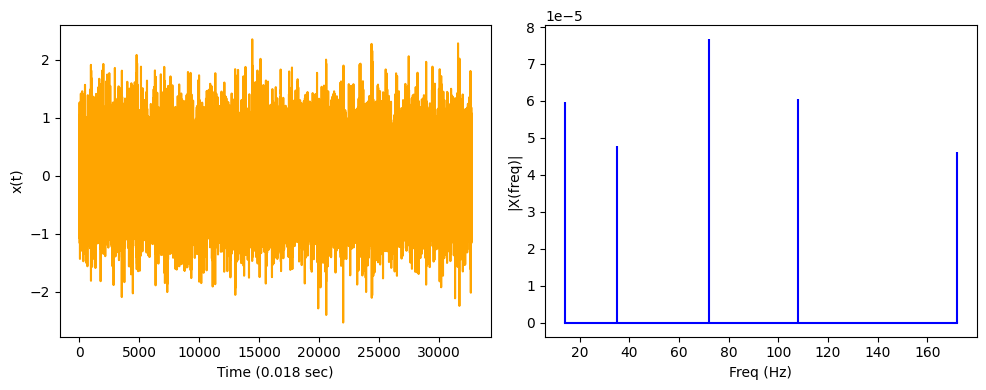

In [86]:
dataset_path = "./data/XJTU-SY/35Hz12kN/Bearing1_1/"
raw_data_g = pd.read_csv(dataset_path + '1.csv')

fft_x_g= set1_good.iloc[0:1,0:5].values
fft_x_g = np.squeeze(fft_x_g)

freq= [14, 35, 108, 72, 172]

ts = len(np.squeeze(raw_data_g.iloc[:,0:1].values))
t = np.arange(0,ts,1)
plt.figure(figsize = (10, 4))

plt.subplot(121)
plt.plot(t, np.squeeze(raw_data_g.iloc[:,0:1].values), 'orange')
plt.xlabel("Time (0.018 sec)")
plt.ylabel('x(t)')

#plt.ylim(0, 0.0005)

plt.subplot(122)
plt.stem(freq, fft_x_g, 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('|X(freq)|')

plt.tight_layout()
plt.show()

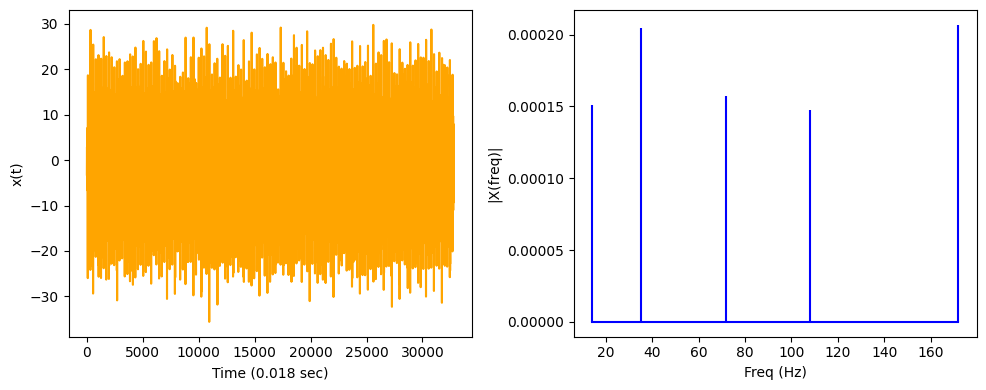

In [87]:
dataset_path = "./data/XJTU-SY/35Hz12kN/Bearing1_1/"
raw_data_g = pd.read_csv(dataset_path + '123.csv')

fft_x_g= set1_bad.iloc[0:1,0:5].values
fft_x_g = np.squeeze(fft_x_g)

freq= [14, 35, 108, 72, 172]

ts = len(np.squeeze(raw_data_g.iloc[:,0:1].values))
t = np.arange(0,ts,1)
plt.figure(figsize = (10, 4))

plt.subplot(121)
plt.plot(t, np.squeeze(raw_data_g.iloc[:,0:1].values), 'orange')
plt.xlabel("Time (0.018 sec)")
plt.ylabel('x(t)')

#plt.ylim(0, 0.0005)

plt.subplot(122)
plt.stem(freq, fft_x_g, 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('|X(freq)|')

#plt.suptitle('Bad bearing')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [smoothline] >Smoothing by interpolation..
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 9.92174e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 1.31302e+09] [loc=0.000 scale=0.000]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 1.31302e+09] [loc=-512.000 scale=512.000]
[distfit] >INFO> [dweibull  ] [0.03 sec] [RSS: 9.43618e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [t         ] [0.16 sec] [RSS: 9.76946e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [genextreme] [0.30 sec] [RSS: 1.47014e+09] [loc=0.000 scale=0.000]
[distfit] >INFO> [gamma     ] [0.31 sec] [RSS: 1.4262e+09] [loc=0.000 scale=0.000]
[distfit] >INFO> [lognorm   ] [0.13 sec] [RSS: 1.51284e+09] [loc=0.000 scale=0.000]
[distfit] >INFO> [beta      ] [0.43 sec] [RSS: 1.32061e+09]

(<Figure size 2500x1200 with 1 Axes>,
 <AxesSubplot:title={'center':'\ndweibull(c=1.08876, loc=5.56547e-05, scale=1.49591e-05)'}, xlabel='Number', ylabel='Tip value'>)

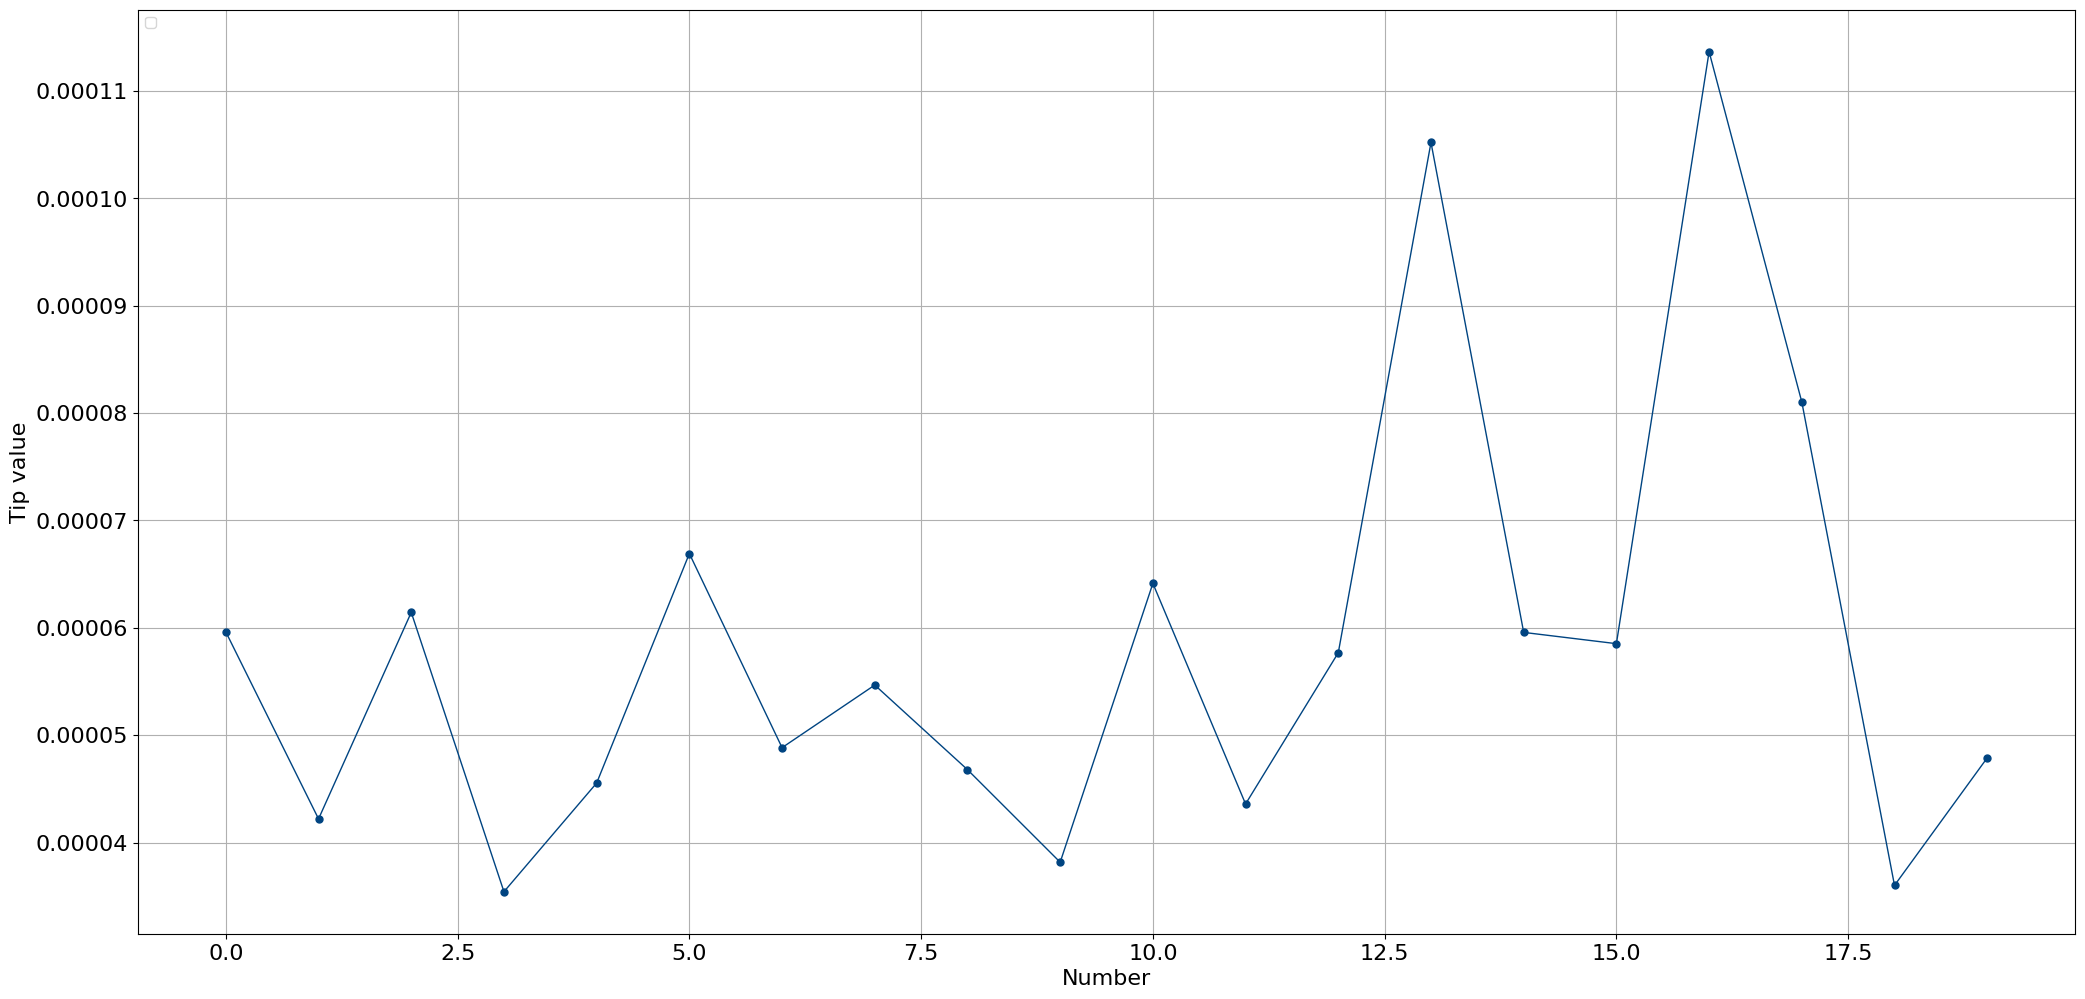

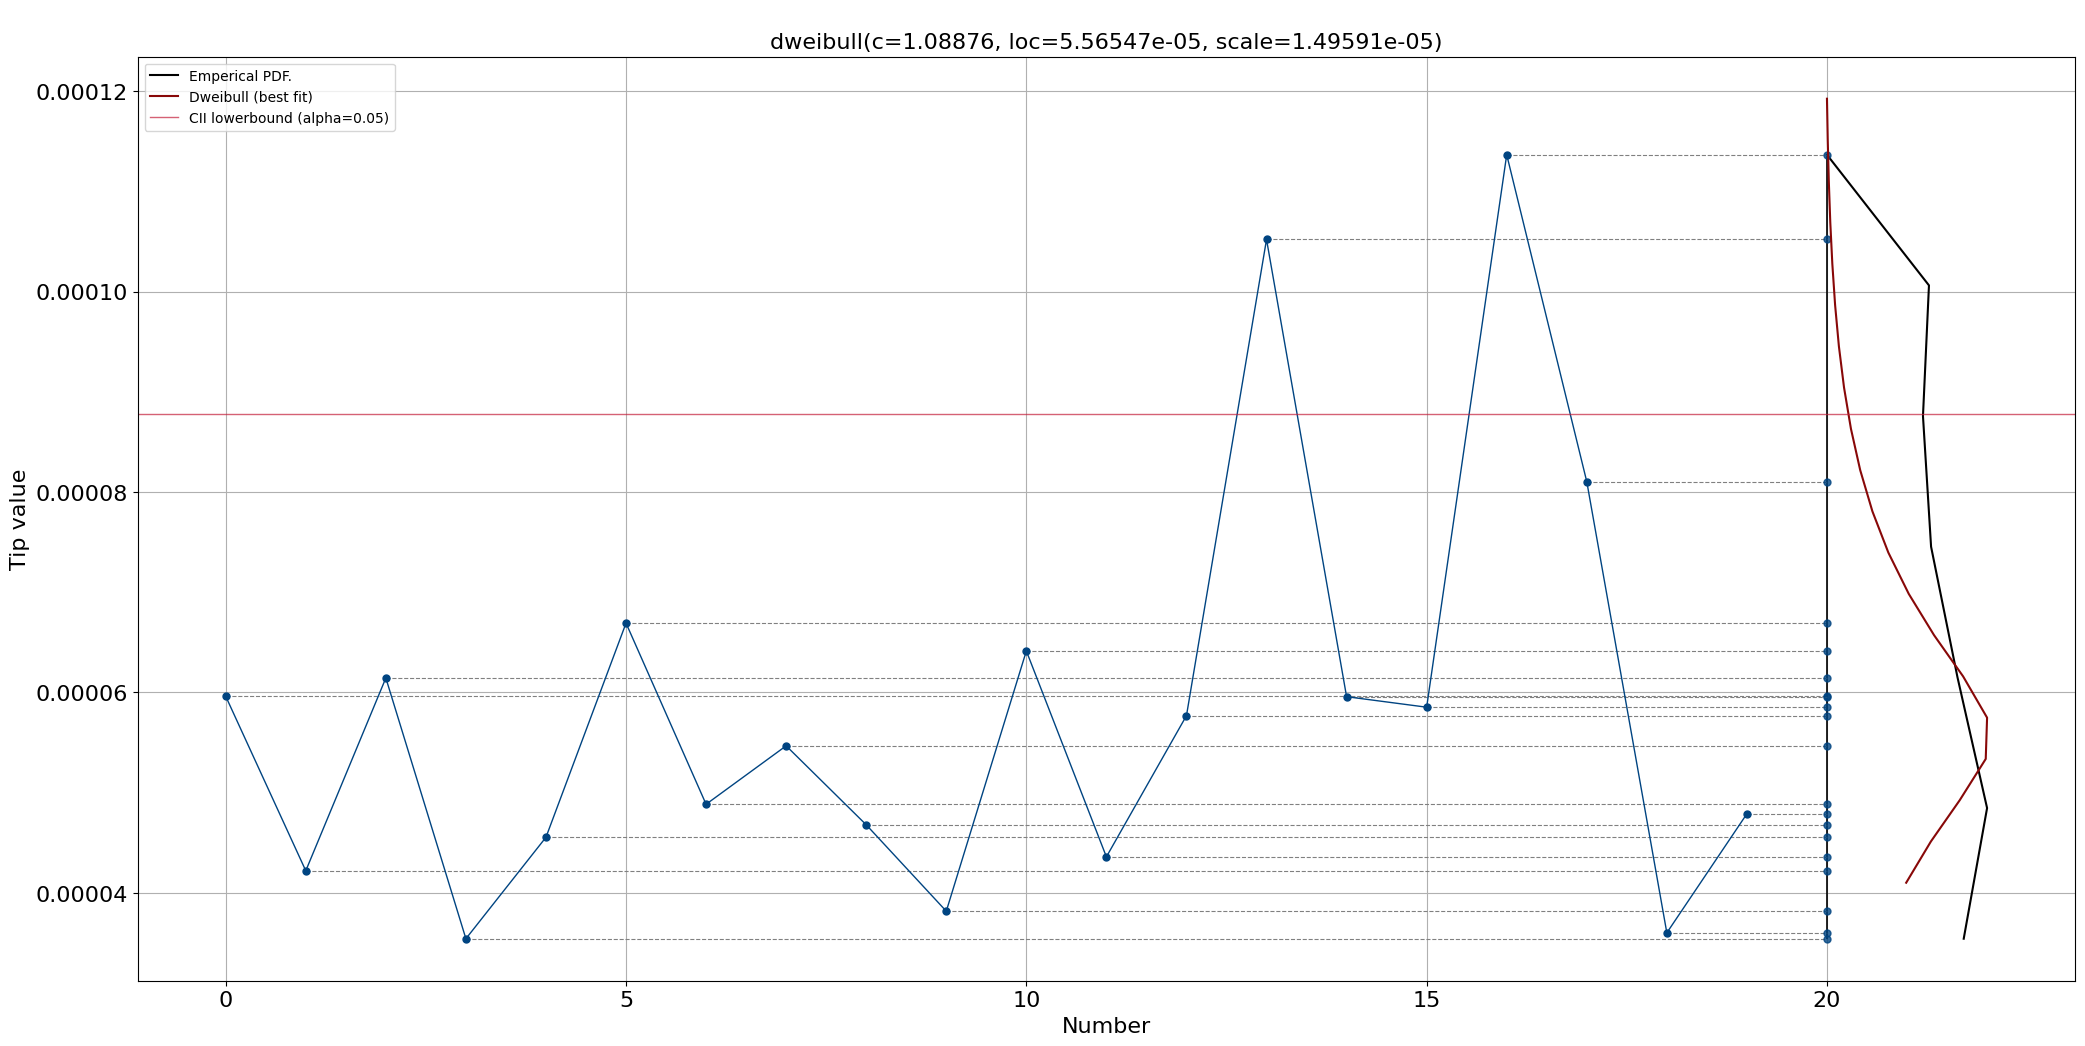

In [79]:
# Initialize
dfit = distfit(smooth=3, bound='up')
# Import
df = set1_good
# Make line plot without any fitting
dfit.lineplot(df["B1_freq_band_1"], xlabel='Number', ylabel='Tip value', grid=True, line_properties={'marker':'.'})

# Fit
dfit.fit_transform(df["B1_freq_band_1"])
# Create line plot but now with the distribution
dfit.lineplot(df["B1_freq_band_1"], xlabel='Number', ylabel='Tip value', grid=True, line_properties={'marker':'.'}, projection=True)

[distfit] >INFO> Ploting Summary.


(<Figure size 2000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Dweibull (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

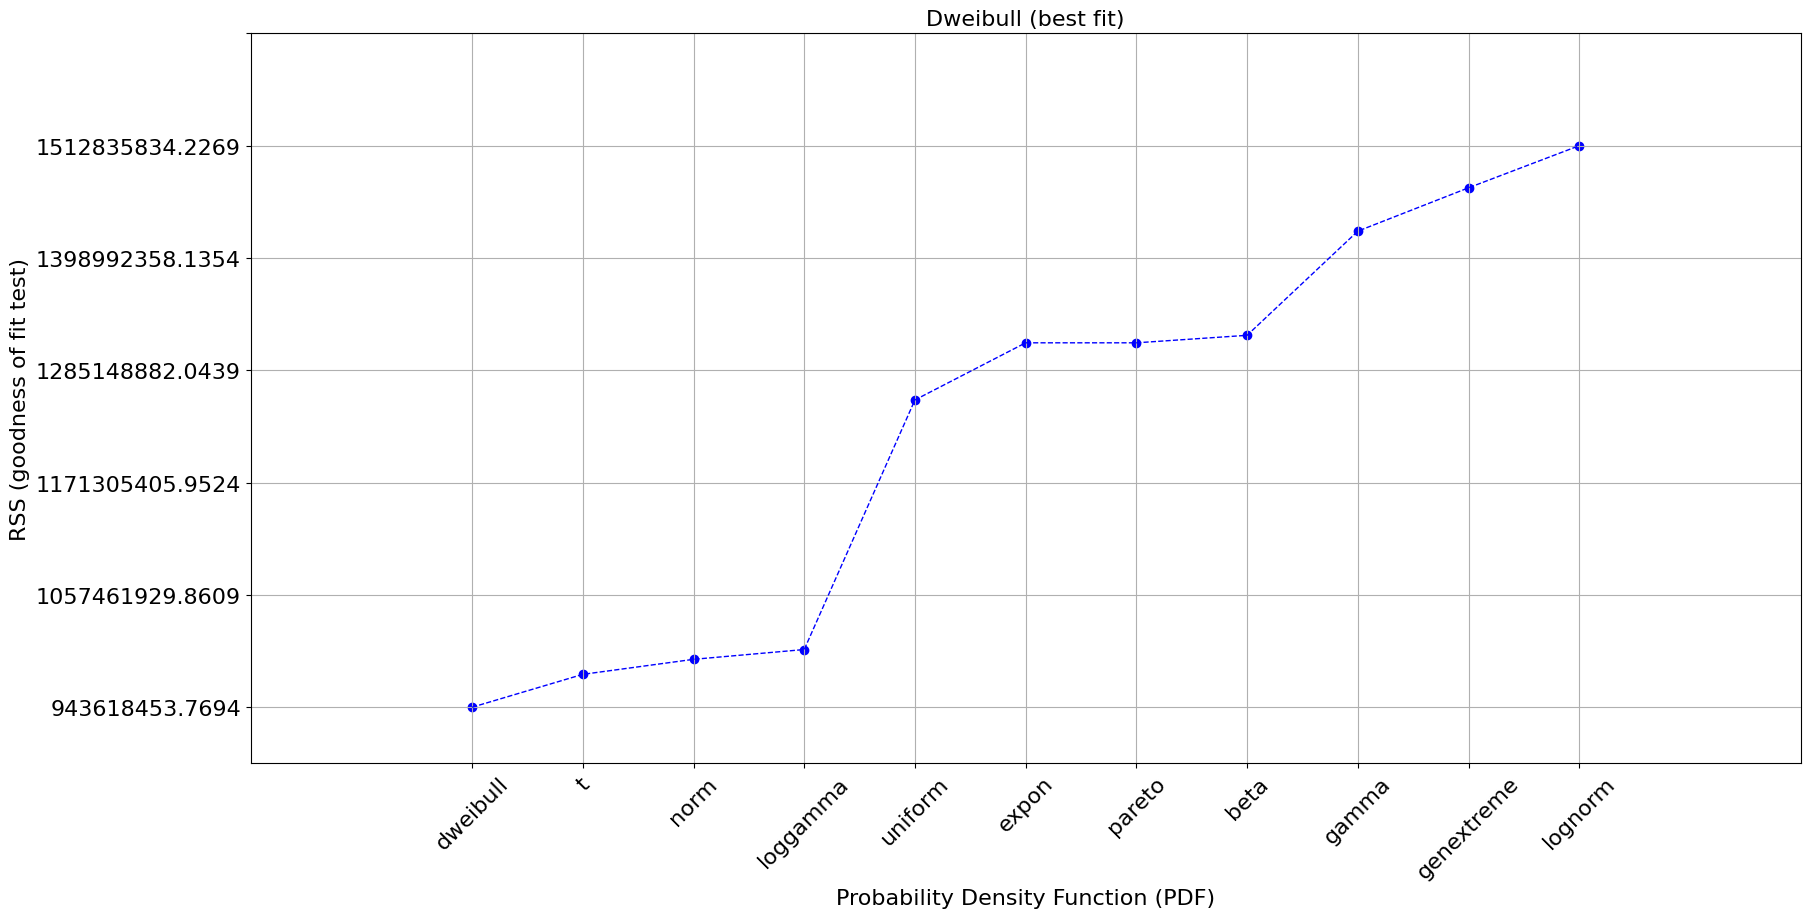

In [80]:
dfit.plot_summary()

In [23]:
# stat.ttest_ind(x1, x2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0)
t_stat = stat.ttest_ind(set1_good["B1_x_freq_band_1"].values, set1_good["B1_x_freq_band_1"].values)
print (t_stat)
t_stat = stat.ttest_ind(set1_good["B1_x_freq_band_1"].values, set1_middle1["B1_x_freq_band_1"].values)
print (t_stat)
t_stat = stat.ttest_ind(set1_good["B1_x_freq_band_1"].values, set1_middle2["B1_x_freq_band_1"].values)
print (t_stat)
t_stat = stat.ttest_ind(set1_good["B1_x_freq_band_1"].values, set1_bad["B1_x_freq_band_1"].values)
print (t_stat)

(0.0, 1.0, 70.0)
(0.008872068286098803, 0.9929464433371961, 70.0)
(-9.77877663898837, 1.0043374369551076e-14, 70.0)
(-12.233599196172678, 4.736586342305706e-19, 70.0)


In [18]:
# stat.ztest(x1, x2=None, value=0, alternative='two-sided', usevar='pooled', ddof=1.0) 0.0003291
z_stat = stat.ztest(set1_good["B1_x_freq_band_1"], x2=None, value= 5.68985, alternative='two-sided')
print (z_stat)

(-8026574.479903986, 0.0)


In [86]:
D2 = entropy(set1_good["B1_x_freq_band_1"].values, set1_bad["B1_x_freq_band_1"].values)
print (D2)
D1 = entropy(set1_good["B1_x_freq_band_1"].values, set1_middle2["B1_x_freq_band_1"].values)
print (D1)
D3 = entropy(set1_good["B1_x_freq_band_1"].values, set1_good["B1_x_freq_band_1"].values)
print (D3)

0.018558354072605268
0.014233924800472461
0.0


In [92]:
#bad= np.zeros((set1_bad["B1_x_freq_band_1"].shape), dtype= float)
bad = set1_bad["B1_x_freq_band_1"].values
bad[:]= set1_good["B1_x_freq_band_1"].values +200
chi= st.chisquare(set1_good["B1_x_freq_band_1"].values, (np.sum(set1_good["B1_x_freq_band_1"].values)/ np.sum(bad) * bad))
print (chi)

Power_divergenceResult(statistic=0.0003451305899528688, pvalue=1.0)


In [36]:
mean1, std1 = set1_good.mean(), set1_good.std()
mean2, std2 = set1_bad.mean(), set1_bad.std()
test_statistic_good = (np.mean(set1_good) - mean1) / (std1 / np.sqrt(len(set1_good)))
test_statistic_bad = (np.mean(set1_bad) - mean1) / (std1 / np.sqrt(len(set1_bad)))
#Select the distribution in "gamma"
p_value_good = st.gamma.sf(abs(test_statistic_good), len(set1_good)-1)
p_value_bad = st.gamma.sf(abs(test_statistic_bad), len(set1_bad)-1)
print (np.std(set1_good.values))
print (np.std(set1_bad.values))

4.350198296114099e-05
7.366414757809348e-05


In [240]:
def evaluator_dist(x, window):

    index_s = 0
    dist_resume= [x [0 : window]]

    for index_s in range (window, len(x), window):
        index_e= index_s + window
        if index_e <= len(x) and not x [index_s : index_e].isnull().values.any():
            temp_window1 = x [0 : window]
        else:
            break
        temp_window2 = x [index_s : index_e]
        dist_resume.append(temp_window2)

    return dist_resume

def evaluator_KL(x, window):

    lenght= int((len(x) - x.iloc[:,0:1].isna().sum().values[0]) /window)
    len_col= len(x.columns)
    res = np.zeros((len_col,lenght - 1), dtype= float) #2156/36
    i = 0
    j = 0
    index_s = 0

    for x_label, __ in x.items():
        for index_s in range (window, len(x), window):
            index_e= index_s + window
            if index_e <= len(x) and not x [index_s : index_e].isnull().values.any():
                temp_window1 = x [0 : window]
            else:
                break
            temp_window2 = x [index_s : index_e]
            res [j][i] = entropy(temp_window1[x_label].values, temp_window2[x_label].values)
            i += 1
        i = 0
        j += 1

    return res

def evaluator_Ttest(x, window):
 
    lenght= int((len(x) - x.iloc[:,0:1].isna().sum().values[0]) /window)
    len_col= len(x.columns)
    res = np.zeros((len_col,lenght - 1), dtype= float) #2156/36
    i = 0
    j = 0
    index_s = 0
    for x_label, __ in x.items():
        for index_s in range (window, len(x), window):
            index_e= index_s + window
            if index_e <= len(x) and not x [index_s : index_e].isnull().values.any():
                temp_window1 = x [0 : window]
            else:
                break
            temp_window2 = x [index_s : index_e]

            res [j][i] = stat.ttest_ind(temp_window1[x_label].values, temp_window2[x_label].values)[1]
            i += 1
        i = 0
        j += 1

    return res

def evaluator_Chi(x, window):

    lenght= int((len(x) - x.iloc[:,0:1].isna().sum().values[0]) /window)
    len_col= len(x.columns)
    res = np.zeros((len_col,lenght - 1), dtype= float) #2156/36
    i = 0
    j = 0
    index_s = 0
    for x_label, __ in x.items():
        for index_s in range (window, len(x), window):
            index_e= index_s + window
            if index_e <= len(x) and not x [index_s : index_e].isnull().values.any():
                temp_window1 = x [0 : window]
            else:
                break
            temp_window2 = x [index_s : index_e]
            res [j][i] = st.chisquare(temp_window1[x_label].values, np.sum(temp_window1[x_label].values)/ np.sum(temp_window2[x_label].values) * temp_window2[x_label].values)[0]
            i += 1
        i = 0
        j += 1

    return res

def evaluator_SD(x, window):

    lenght= int((len(x) - x.iloc[:,0:1].isna().sum().values[0]) /window)
    len_col= len(x.columns)
    res = np.zeros((len_col,lenght - 1), dtype= float) #2156/36
    i = 0
    j = 0
    index_s = 0
    for x_label, __ in x.items():
        for index_s in range (window, len(x), window):
            index_e= index_s + window
            if index_e > len(x) or x [index_s : index_e].isnull().values.any():
                break
            temp_window = x [index_s : index_e]

            res [j][i] = np.std(temp_window[x_label].values)
            i += 1
        i = 0
        j += 1

    return res

In [154]:
def evaluator_breakpoint(kl, sd, t, chi):
    i= 0
    j= 0
    w= 0
    m= 0
    q= 0
    bins = 5
    data= 3 + 1
    percentage_error= 10
    thresholds_kl = np.zeros((bins, data), dtype= float)
    thresholds_sd = np.zeros((bins, data), dtype= float)
    thresholds_t = np.zeros((bins, data), dtype= float)
    thresholds_chi = np.zeros((bins, data), dtype= float)


    for bin in kl:

        break_in= int(len(bin)* 40 /100)
        for step in bin:

            if i <= break_in:
                if bin[i]> thresholds_kl [j][0] or i== 0:
                    thresholds_kl [j][0]= bin[i]
                    thresholds_kl [j][1]= bin[i] + (bin[i]/100 * percentage_error)
                    thresholds_kl [j][3]= len (bin)
                w= i+1

                if i> 0 and bin[i]>= thresholds_kl [j][0]:
                    thresholds_kl [j][2]= 0                    

                for step_2 in bin[i+1:]:
                    if step_2 > thresholds_kl [j][1]:
                        m= bin[w]-bin[w-1]
                        q= bin[w-1]
                        # thresholds_kl [j][2], =  np.where(np.isclose(bin, step_2))
                        thresholds_kl [j][2] =  (thresholds_kl [j][1]/m) - (q/m) + (w -1)
                        break
                    w += 1
            # elif bin[i]> bin[i-1] - (bin[i-1]/100 * 4):

            #     if bin[i]> thresholds_kl [j][0]: 
            #         thresholds_kl [j][0]= bin[i]
            #         thresholds_kl [j][1]= bin[i] + (bin[i]/100 * 4)
            #         thresholds_kl [j][2]= 0
                
            #     w= i+1
            #     for step_2 in bin[i+1:]:
            #         if step_2 > thresholds_kl [j][1]:
            #             m= bin[w]-bin[w-1]
            #             q= bin[w-1]
            #             thresholds_kl [j][2] =  (thresholds_kl [j][1]/m) - (q/m) + (w -1)
            #             # thresholds_kl [j][2], = np.where(np.isclose(bin, step_2))
            #             break
            #         w += 1
            else:
                break

            i+= 1
        i= 0
        j+= 1

    i= 0
    j= 0

    for bin in sd:

        break_in= int(len(bin)* 40 /100)
        for step in bin:

            if  i <= break_in:
                if bin[i]> thresholds_sd [j][0] or i== 0:
                    thresholds_sd [j][0]= bin[i]
                    thresholds_sd [j][1]= bin[i] + (bin[i]/100 * percentage_error)
                    thresholds_sd [j][3]= len (bin)
                w= i+1

                if i> 0 and bin[i]>= thresholds_sd [j][0]:
                    thresholds_sd [j][2]= 0     

                for step_2 in bin[i+1:]:
                    if step_2 > thresholds_sd [j][1]:
                        m= bin[w]-bin[w-1]
                        q= bin[w-1]
                        # thresholds_kl [j][2], =  np.where(np.isclose(bin, step_2))
                        thresholds_sd [j][2] =  (thresholds_sd [j][1]/m) - (q/m) + (w -1)
                        break
                    w += 1
            # elif bin[i]> bin[i-1] - (bin[i-1]/100 * 4):

            #     if bin[i]> thresholds_sd [j][0] or i== 0:
            #         thresholds_sd [j][0]= bin[i]
            #         thresholds_sd [j][1]= bin[i] + (bin[i]/100 * 4)
            #         thresholds_sd [j][2]= 0

            #     w= i+1
            #     for step_2 in bin[i+1:]:
            #         if step_2 > thresholds_sd [j][1]:
            #             m= bin[w]-bin[w-1]
            #             q= bin[w-1]
            #             thresholds_sd [j][2] =  (thresholds_sd [j][1]/m) - (q/m) + (w -1)
            #             # thresholds_kl [j][2], = np.where(np.isclose(bin, step_2))
            #             break
            #         w += 1
            else:
                break

            i+= 1
        i= 0
        j+= 1

    i= 0
    j= 0
    count= 0
    t_threshold= - 1e-20 
    ground_level= 0
    max_count = 3

    for bin in t:
        break_in= int(len(bin)* 80 /100)
        thresholds_t [j][max_count]= len (bin)        
        for step in bin:
            if i == 0 and i <= break_in:
                i+= 1
                continue

            if count== data - 1:
                break

            ground_level= min(bin) + (min(bin) /100 * percentage_error)

            x= list(range (0, len(bin), 1))
            y= bin
            dydx= np.diff(y)/np.diff(x)

            w= 1
            for val in dydx:
                if val < t_threshold and bin[i] < ground_level and count< max_count and w> 1:
                    thresholds_t [j][count]= w
                    count+= 1
                w += 1

            i+= 1
        count= 0    
        i= 0
        j+= 1

    i= 0
    j= 0
    count= 0
    t_threshold= - 1e-20 
    ground_level= 0

    for bin in chi:
        
        thresholds_chi [j][max_count]= len (bin)
        for step in bin:
            if i == 0:
                i+= 1
                continue

            if count== data - 1:
                break

            ground_level= min(bin) + (min(bin) /100 * percentage_error)

            x= list(range (0, len(bin), 1))
            y= bin
            dydx= np.diff(y)/np.diff(x)

            w= 1
            for val in dydx:
                if val < t_threshold and bin[i] < ground_level and count< max_count and w> 1:
                    thresholds_chi [j][count]= w
                    count+= 1
                w += 1

            i+= 1
        count= 0    
        i= 0
        j+= 1

    return thresholds_kl, thresholds_sd, thresholds_t, thresholds_chi

In [388]:
window= 10
total_bearings= 40
average_offset= 1
#break_in_offset= int(400/window) - 1
break_in_offset= 0
#minutes= window *10
minutes= window
scale_multiplier= 18
eval_KL= []
eval_t= []
eval_SD= []
eval_chi= []
event_kl= []
event_sd= []
event_t= []
event_chi= []
dist_resume= []         

for b_num in range (1, 41, 1):

    set= set_analytic[["B{}_freq_band_1".format(b_num), "B{}_freq_band_2".format(b_num), "B{}_freq_band_3".format(b_num), "B{}_freq_band_4".format(b_num), "B{}_freq_band_5".format(b_num)]]
    if (b_num== 1):   
        dist_resume= evaluator_dist(set.iloc[:,0], window)
    eval_KL.append(evaluator_KL(set, window))
    eval_SD.append(evaluator_SD(set, window))
    eval_t.append(evaluator_Ttest(set, window))
    eval_chi.append(evaluator_Chi(set, window))

i= 0
for set_KL in eval_KL:
    temp_kl, temp_sd, temp_t, temp_chi= evaluator_breakpoint(set_KL, eval_SD[i], eval_t[i], eval_chi[i])
    event_kl.append(temp_kl)
    event_sd.append(temp_sd)
    event_t.append(temp_t)
    event_chi.append(temp_chi)
    i += 1

In [222]:
group_labels= []
for i in range (1, len(dist_resume) +1, 1):
    if i< 3:
        group_labels.append('Observation t({}) to t({}) (min)'.format((i-1)*10, i*10))
    else:
        group_labels.append('Observation t({}) to t({}) (min)'.format((i+7)*10, (i+8)*10))        
# Create distplot with custom bin_size
fig = ff.create_distplot(dist_resume, group_labels, bin_size=0.00001)
fig.show()

In [224]:
import seaborn as sns

In [338]:
group_labels= []

for i in range (1, len(dist_resume) +1, 1):
    if i< 4:
        group_labels.append('Observations t({}) to t({}) (min)'.format((i-1)*10, i*10))
    else:
        group_labels.append('Observations t({}) to t({}) (min)'.format((i+7)*10, (i+7)*10))


dataframe_resume= pd.DataFrame(data = None)
for i in range (1, len(dist_resume) +1, 1):
    if i< 4:
        group_labels.append('Observation t({}) to t({}) (min)'.format((i-1)*10, i*10))
        dataframe= dist_resume[i-1].to_frame(name= 'Observations t({}) to t({}) (min)'.format((i-1)*10, (i)*10))
        dataframe.reset_index(inplace= True, drop= True)
        dataframe_resume= pd.concat([dataframe_resume, dataframe], axis=1)
    else:
        group_labels.append('Observation t({}) to t({}) (min)'.format((i+5)*10, (i+6)*10))
        dataframe= dist_resume[i-1].to_frame('Observations t({}) to t({}) (min)'.format((i+5)*10, (i+6)*10))
        dataframe.reset_index(inplace= True, drop= True)
        dataframe_resume= pd.concat([dataframe_resume, dataframe], axis=1)

   Observations t(0) to t(10) (min)  Observations t(10) to t(20) (min)  \
0                          0.000060                           0.000064   
1                          0.000042                           0.000044   
2                          0.000061                           0.000058   
3                          0.000035                           0.000105   
4                          0.000046                           0.000060   
5                          0.000067                           0.000059   
6                          0.000049                           0.000114   
7                          0.000055                           0.000081   
8                          0.000047                           0.000036   
9                          0.000038                           0.000048   

   Observations t(20) to t(30) (min)  Observations t(90) to t(100) (min)  \
0                           0.000058                            0.000184   
1                           0.000

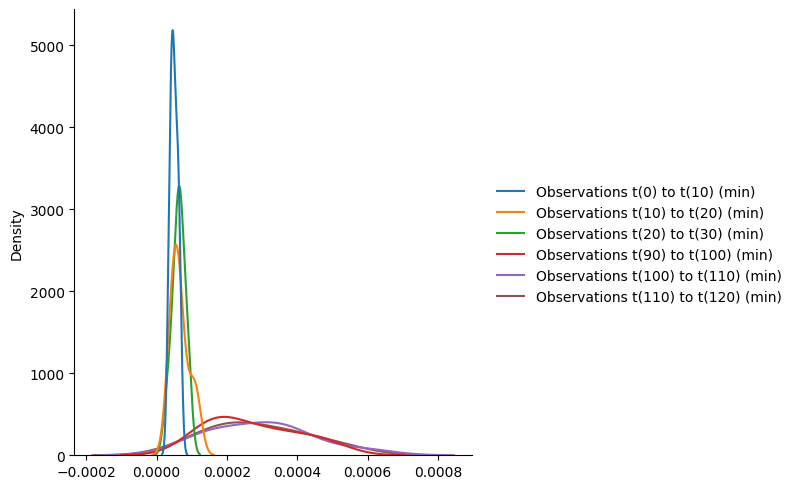

In [339]:
sns.displot(data= dataframe_resume, kind="kde")

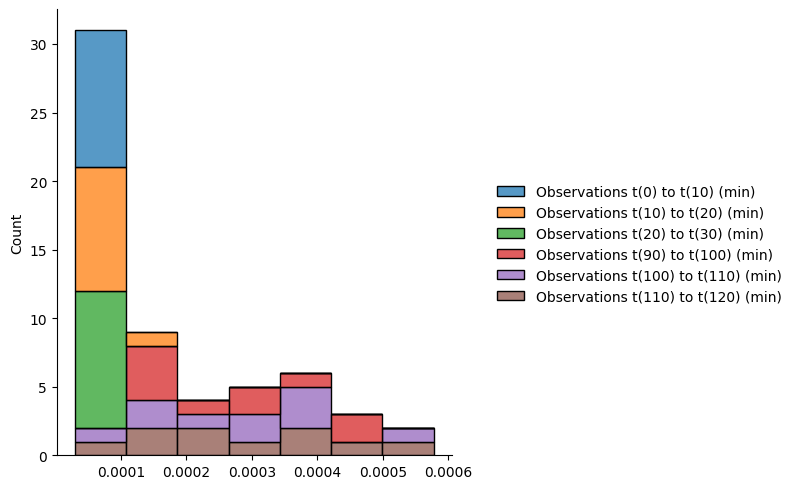

In [340]:
sns.displot(data= dataframe_resume, multiple="stack")

In [398]:
dataframe_resume_first= pd.DataFrame(data = None)
dataframe_resume_later= pd.DataFrame(data = None)

upper_limit = 3 + 1
low_limit= 8 + 1

for i in range (1, upper_limit, 1):
        group_labels.append('Observation t({}) to t({}) (min)'.format((i-1)*10, i*10))
        dataframe= dist_resume[i-1].to_frame(name= 'Observations t({}) to t({}) (min)'.format((i-1)*10, (i)*10))
        dataframe.reset_index(inplace= True, drop= True)
        dataframe_resume_first= pd.concat([dataframe_resume_first, dataframe], axis=1)

for i in range (len(dist_resume), low_limit, -1):
        group_labels.append('Observation t({}) to t({}) (min)'.format((i-1)*10, i*10))
        dataframe= dist_resume[i-1].to_frame(name= 'Observations t({}) to t({}) (min)'.format((i-1)*10, (i)*10))
        dataframe.reset_index(inplace= True, drop= True)
        dataframe_resume_later= pd.concat([dataframe_resume_later, dataframe], axis=1)

        

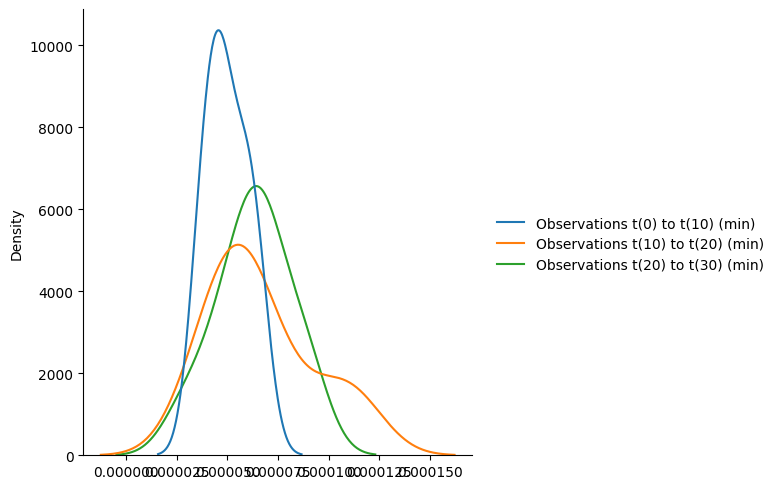

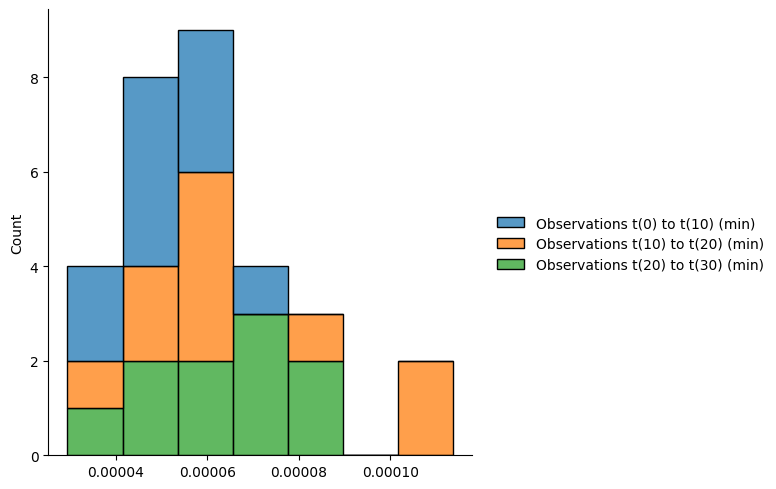

In [394]:
sns.displot(data= dataframe_resume_first, kind="kde")
sns.displot(data= dataframe_resume_first, multiple="stack")

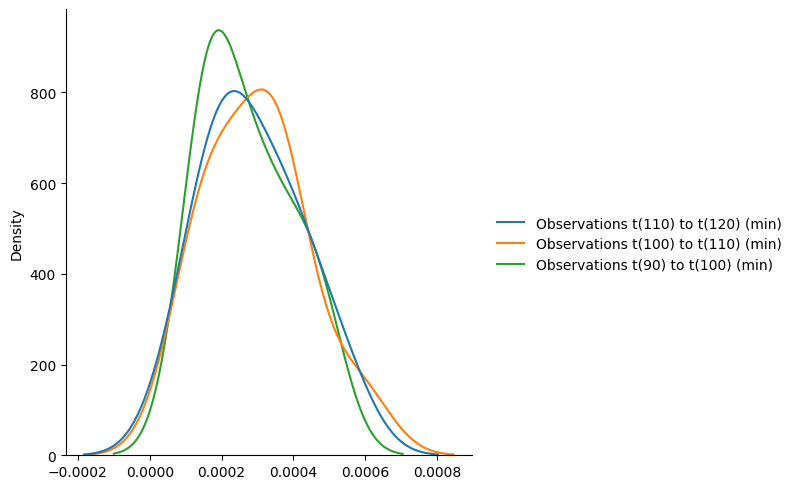

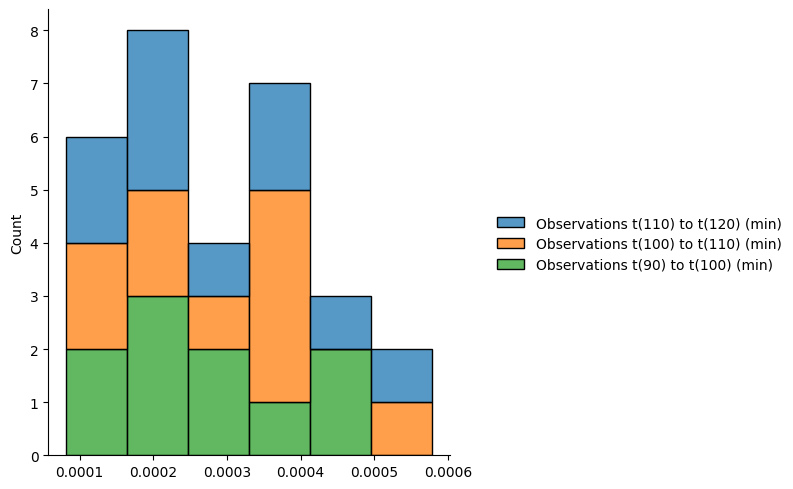

In [399]:
sns.displot(data= dataframe_resume_later, kind="kde")
sns.displot(data= dataframe_resume_later, multiple="stack")

In [150]:
print (len (event_kl))
print (len (event_kl[0]))
print (len (event_kl[0][0]))
print (event_kl[0][0][0])
#print (event_kl)

print (len (eval_t))
print (len (eval_t[0]))
print (len (eval_t[38][0]))
print (eval_t[38][0][0])
print(len(set_analytic))

40
5
4
0.10034386362279694
40
5
4
0.3809093773720861
165


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


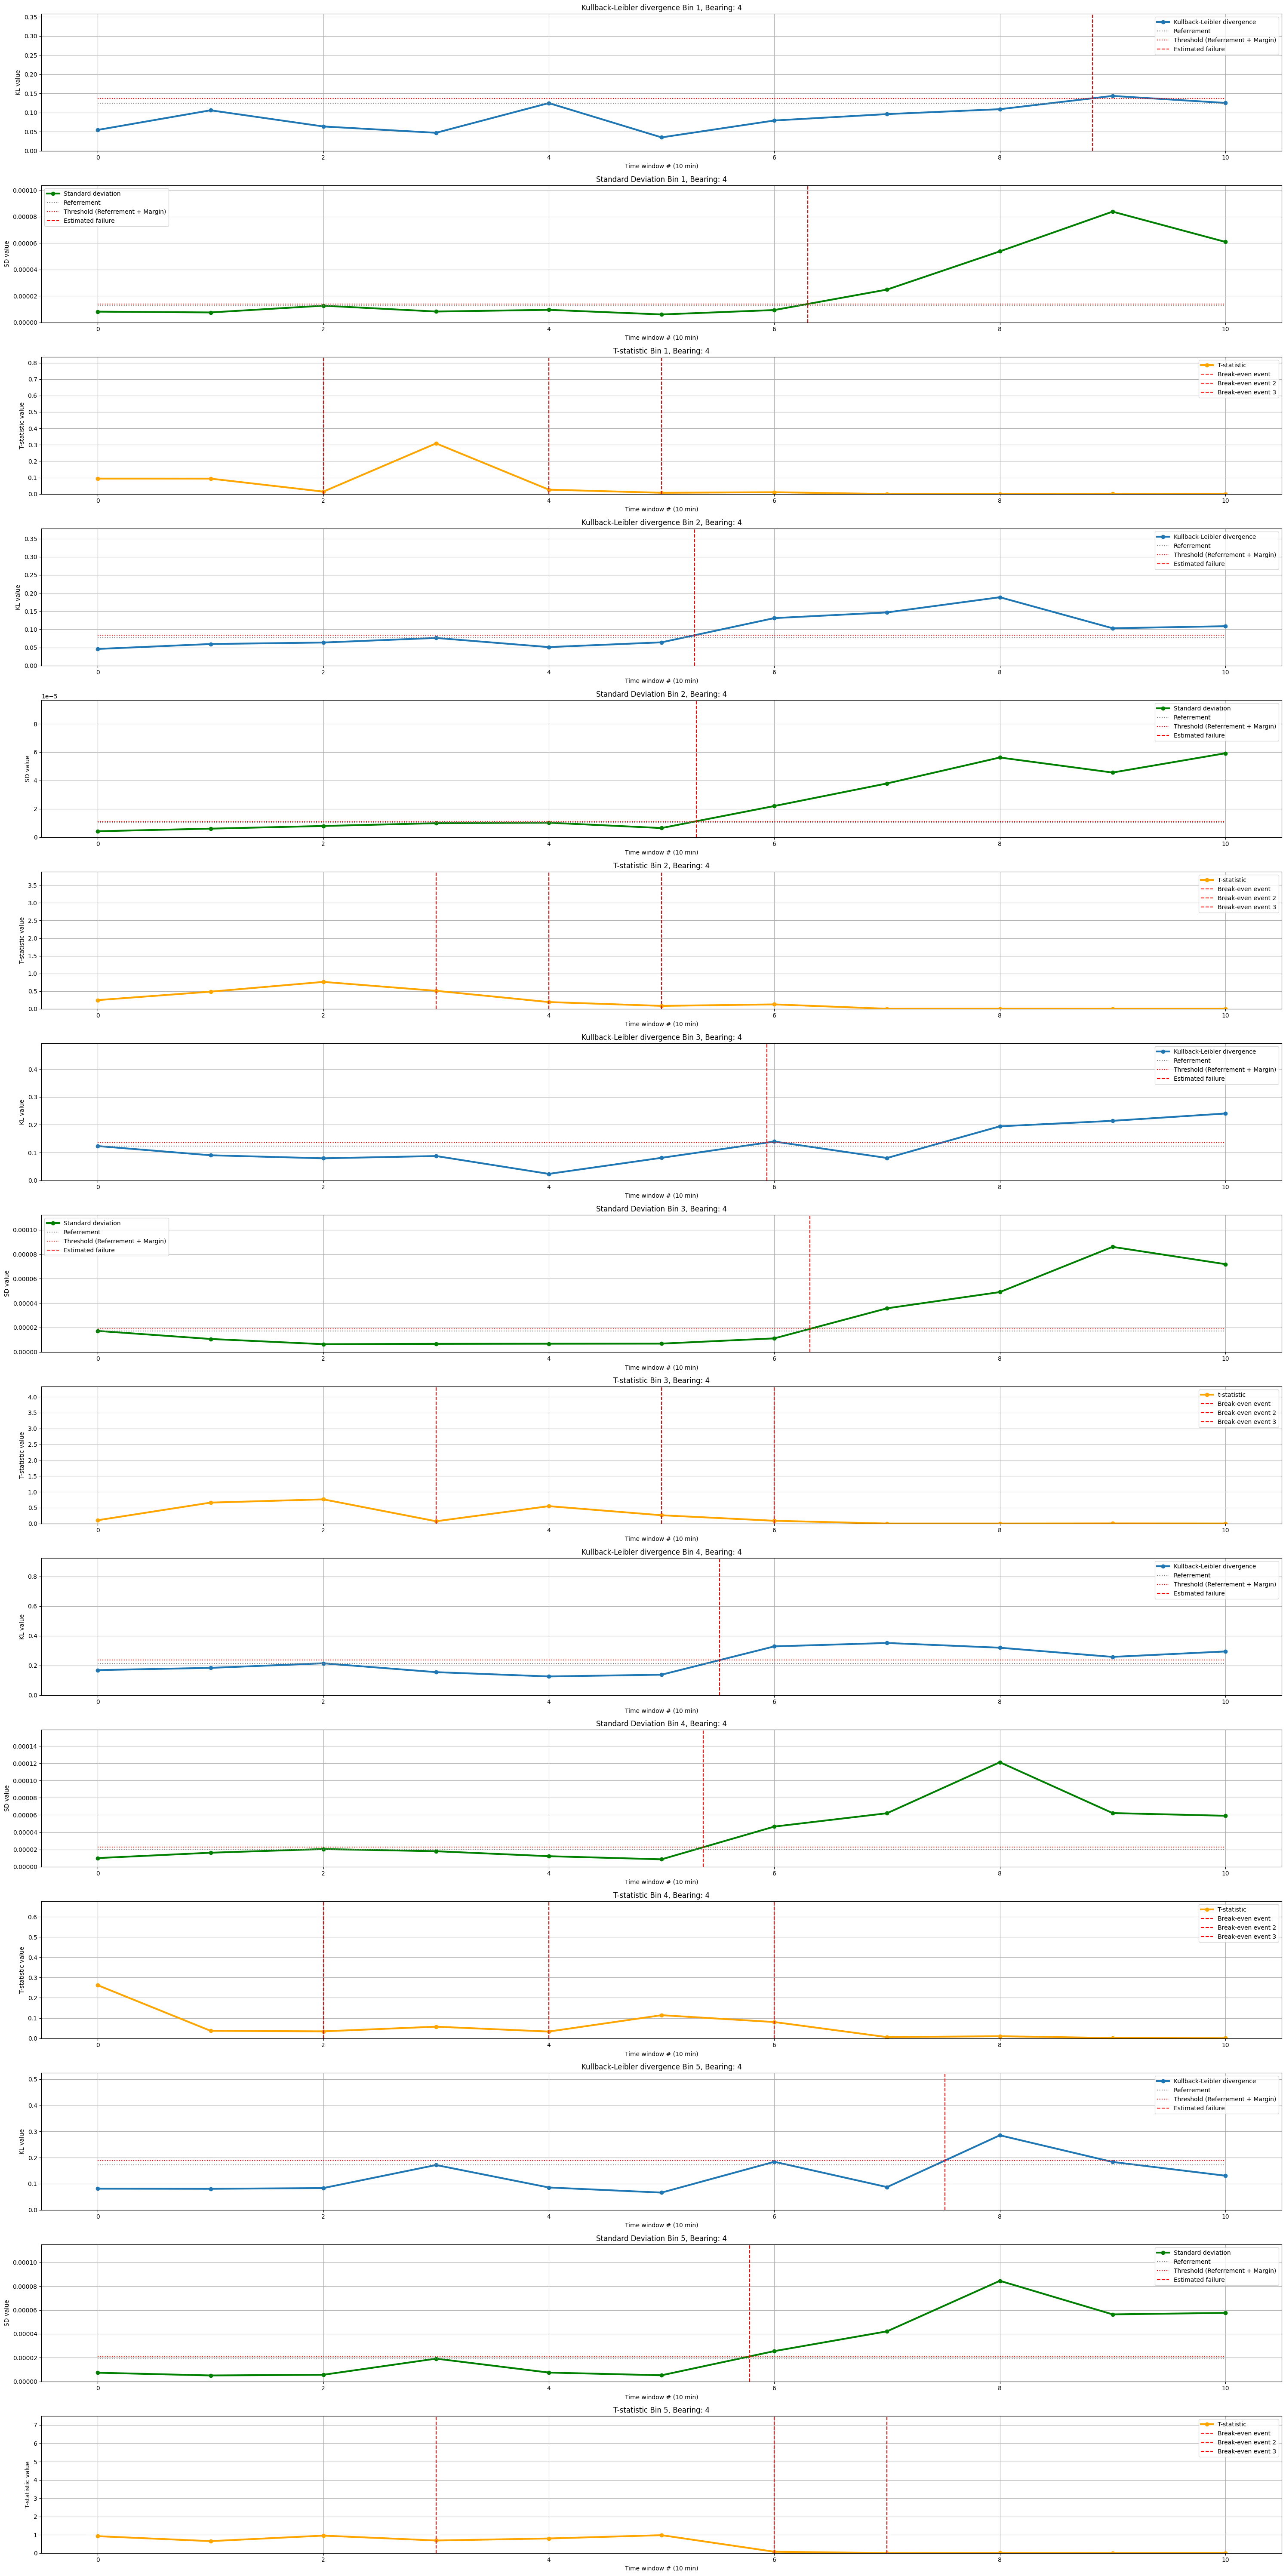

In [336]:
#general plotting

i = 0
b_num = 1

for bearing in eval_KL:
    max_x= len(bearing[0]) - 1
    max_y= 10

    if i< 3:
        i += 1
        b_num += 1
        continue

    fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14) = plt.subplots(figsize=(30, 60), nrows=15)
    ax0.plot(bearing[0][break_in_offset:], label='Kullback-Leibler divergence', marker='o', linewidth=3)
    ax0.set_title("Kullback-Leibler divergence Bin 1, Bearing: {}".format(b_num))
    ax0.set_xlabel("Time window # ({} min)".format(minutes))
    ax0.set_ylabel("KL value")
    ax0.hlines(event_kl[i][0][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax0.hlines(event_kl[i][0][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_kl[i][0][2]> 0):
        ax0.vlines(event_kl[i][0][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax0.legend()
    ax1.plot(eval_SD[i][0][break_in_offset:], label='Standard deviation', color= 'green', marker='o', linewidth=3)
    ax1.set_title("Standard Deviation Bin 1, Bearing: {}".format(b_num))
    ax1.set_xlabel("Time window # ({} min)".format(minutes))
    ax1.set_ylabel("SD value")
    ax1.hlines(event_sd[i][0][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax1.hlines(event_sd[i][0][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_sd[i][0][2]> 0):
        ax1.vlines(event_sd[i][0][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax1.legend()
    ax2.plot(eval_t[i][0][break_in_offset:], label='T-statistic', color= 'orange', marker='o', linewidth=3)
    ax2.set_title("T-statistic Bin 1, Bearing: {}".format(b_num))
    ax2.set_xlabel("Time window # ({} min)".format(minutes))
    ax2.set_ylabel("T-statistic value")
    if (event_t[i][0][0]> 0):
        ax2.vlines(event_t[i][0][0], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event")
        if (event_t[i][0][1]> 0):
            ax2.vlines(event_t[i][0][1], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 2")
            if (event_t[i][0][2]> 0):
                ax2.vlines(event_t[i][0][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 3")
    ax2.legend()

    ax3.plot(bearing[1][break_in_offset:], label='Kullback-Leibler divergence', marker='o', linewidth=3)
    ax3.set_title("Kullback-Leibler divergence Bin 2, Bearing: {}".format(b_num))
    ax3.set_xlabel("Time window # ({} min)".format(minutes))
    ax3.set_ylabel("KL value")
    ax3.hlines(event_kl[i][1][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax3.hlines(event_kl[i][1][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_kl[i][1][2]> 0):
        ax3.vlines(event_kl[i][1][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax3.legend()
    ax4.plot(eval_SD[i][1][break_in_offset:], label='Standard deviation', color= 'green', marker='o', linewidth=3)
    ax4.set_title("Standard Deviation Bin 2, Bearing: {}".format(b_num))
    ax4.set_xlabel("Time window # ({} min)".format(minutes))
    ax4.set_ylabel("SD value")
    ax4.hlines(event_sd[i][1][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax4.hlines(event_sd[i][1][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_sd[i][1][2]> 0):
        ax4.vlines(event_sd[i][1][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax4.legend()
    ax5.plot(eval_t[i][1][break_in_offset:], label='T-statistic', color= 'orange', marker='o', linewidth=3)
    ax5.set_title("T-statistic Bin 2, Bearing: {}".format(b_num))
    ax5.set_xlabel("Time window # ({} min)".format(minutes))
    ax5.set_ylabel("T-statistic value")
    if (event_t[i][1][0]> 0):
        ax5.vlines(event_t[i][1][0], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event")
        if (event_t[i][1][1]> 0):
            ax5.vlines(event_t[i][1][1], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 2")
            if (event_t[i][1][2]> 0):
                ax5.vlines(event_t[i][1][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 3")
    ax5.legend()


    ax6.plot(bearing[2][break_in_offset:], label='Kullback-Leibler divergence', marker='o', linewidth=3)
    ax6.set_title("Kullback-Leibler divergence Bin 3, Bearing: {}".format(b_num))
    ax6.set_xlabel("Time window # ({} min)".format(minutes))
    ax6.set_ylabel("KL value")
    ax6.hlines(event_kl[i][2][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax6.hlines(event_kl[i][2][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_kl[i][2][2]> 0):
        ax6.vlines(event_kl[i][2][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax6.legend()
    ax7.plot(eval_SD[i][2][break_in_offset:], label='Standard deviation', color= 'green', marker='o', linewidth=3)
    ax7.set_title("Standard Deviation Bin 3, Bearing: {}".format(b_num))
    ax7.set_xlabel("Time window # ({} min)".format(minutes))
    ax7.set_ylabel("SD value")
    ax7.hlines(event_sd[i][2][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax7.hlines(event_sd[i][2][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_sd[i][2][2]> 0):
        ax7.vlines(event_sd[i][2][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax7.legend()
    ax8.plot(eval_t[i][2][break_in_offset:], label='t-statistic', color= 'orange', marker='o', linewidth=3)
    ax8.set_title("T-statistic Bin 3, Bearing: {}".format(b_num))
    ax8.set_xlabel("Time window # ({} min)".format(minutes))
    ax8.set_ylabel("T-statistic value")
    if (event_t[i][2][0]> 0):
        ax8.vlines(event_t[i][2][0], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event")
        if (event_t[i][2][1]> 0):
            ax8.vlines(event_t[i][2][1], linestyles= "dashed", ymin= 0 , ymax= max_y, color="red", label= "Break-even event 2")
            if (event_t[i][2][2]> 0):
                ax8.vlines(event_t[i][2][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 3")
    ax8.legend()

    ax9.plot(bearing[3][break_in_offset:], label='Kullback-Leibler divergence', marker='o', linewidth=3)
    ax9.set_title("Kullback-Leibler divergence Bin 4, Bearing: {}".format(b_num))
    ax9.set_xlabel("Time window # ({} min)".format(minutes))
    ax9.set_ylabel("KL value")
    ax9.hlines(event_kl[i][3][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax9.hlines(event_kl[i][3][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_kl[i][3][2]> 0):
        ax9.vlines(event_kl[i][3][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax9.legend()
    ax10.plot(eval_SD[i][3][break_in_offset:], label='Standard deviation', color= 'green', marker='o', linewidth=3)
    ax10.set_title("Standard Deviation Bin 4, Bearing: {}".format(b_num))
    ax10.set_xlabel("Time window # ({} min)".format(minutes))
    ax10.set_ylabel("SD value")
    ax10.hlines(event_sd[i][3][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax10.hlines(event_sd[i][3][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_sd[i][3][2]> 0):
        ax10.vlines(event_sd[i][3][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax11.legend()
    ax11.plot(eval_t[i][3][break_in_offset:], label='T-statistic', color= 'orange', marker='o', linewidth=3)
    ax11.set_title("T-statistic Bin 4, Bearing: {}".format(b_num))
    ax11.set_xlabel("Time window # ({} min)".format(minutes))
    ax11.set_ylabel("T-statistic value")
    if (event_t[i][3][0]> 0):
        ax11.vlines(event_t[i][3][0], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event")
        if (event_t[i][3][1]> 0):
            ax11.vlines(event_t[i][3][1], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 2")
            if (event_t[i][3][2]> 0):
                ax11.vlines(event_t[i][3][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 3")
    ax11.legend()


    ax12.plot(bearing[4][break_in_offset:], label='Kullback-Leibler divergence', marker='o', linewidth=3)
    ax12.set_title("Kullback-Leibler divergence Bin 5, Bearing: {}".format(b_num))
    ax12.set_xlabel("Time window # ({} min)".format(minutes))
    ax12.set_ylabel("KL value")
    ax12.hlines(event_kl[i][4][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax12.hlines(event_kl[i][4][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_kl[i][4][2]> 0):
        ax12.vlines(event_kl[i][4][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax12.legend()
    ax13.plot(eval_SD[i][4][break_in_offset:], label='Standard deviation', color= 'green', marker='o', linewidth=3)
    ax13.set_title("Standard Deviation Bin 5, Bearing: {}".format(b_num))
    ax13.set_xlabel("Time window # ({} min)".format(minutes))
    ax13.set_ylabel("SD value")
    ax13.hlines(event_sd[i][4][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax13.hlines(event_sd[i][4][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_sd[i][4][2]> 0):
        ax13.vlines(event_sd[i][4][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax13.legend()
    ax14.plot(eval_t[i][4][break_in_offset:], label='T-statistic', color= 'orange', marker='o', linewidth=3)
    ax14.set_title("T-statistic Bin 5, Bearing: {}".format(b_num))
    ax14.set_xlabel("Time window # ({} min)".format(minutes))
    ax14.set_ylabel("T-statistic value")
    if (event_t[i][4][0]> 0):
        ax14.vlines(event_t[i][4][0], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event")
        if (event_t[i][4][1]> 0):
            ax14.vlines(event_t[i][4][1], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 2")
            if (event_t[i][4][2]> 0):
                ax14.vlines(event_t[i][4][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 3")
    ax14.legend()

    # ax15.plot(eval_chi_test_x[3][break_in_offset:], label='t-statistic', color= 'orange', marker='o', linewidth=3)
    # ax15.set_title("T-statistic Bin 5")
    # ax15.set_xlabel("Time window # ({} data-points)".format(minutes))
    # ax15.set_ylabel("T-statistic value")
    # if (event_t_x[3][0]> 0):
    #     ax15.vlines(event_t_x[3][0], linestyles= "dashed", ymin= 0 , ymax= 1, color= "red", label= "Break-even event")
    #     if (event_chi_x[3][1]> 0):
    #         ax15.vlines(event_chi_x[3][1], linestyles= "dashed", ymin= 0 , ymax= 1, color= "red", label= "Break-even event 2")
    #         if (event_chi_x[3][2]> 0):
    #             ax15.vlines(event_chi_x[3][2], linestyles= "dashed", ymin= 0 , ymax= 1, color= "red", label= "Break-even event 3")
    # ax15.legend()

    ax0.set_ylim([0, np.average(bearing[0])* 4])
    ax1.set_ylim([0, np.average(eval_SD[i][0])* 4])
    ax2.set_ylim([0, np.average(eval_t[i][0][average_offset:])*scale_multiplier])

    ax3.set_ylim([0, np.average(bearing[1])* 4])
    ax4.set_ylim([0, np.average(eval_SD[i][1])* 4])
    ax5.set_ylim([0, np.average(eval_t[i][1][average_offset:])*scale_multiplier])

    ax6.set_ylim([0, np.average(bearing[2])* 4])
    ax7.set_ylim([0, np.average(eval_SD[i][2])* 4])
    ax8.set_ylim([0, np.average(eval_t[i][2][average_offset:])*scale_multiplier])

    ax9.set_ylim([0, np.average(bearing[3])* 4])
    ax10.set_ylim([0, np.average(eval_SD[i][3])* 4])
    ax11.set_ylim([0, np.average(eval_t[i][3][average_offset:])*scale_multiplier])

    ax12.set_ylim([0, np.average(bearing[4])* 4])
    ax13.set_ylim([0, np.average(eval_SD[i][4])* 4])
    ax14.set_ylim([0, np.average(eval_t[i][4][average_offset:])*scale_multiplier])
    #ax15.set_ylim([0, np.average(eval_chi_test_x[3][average_offset:])* 2])

    ax0.grid()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()
    ax7.grid()
    ax8.grid()
    ax9.grid()
    ax10.grid()
    ax11.grid()
    ax12.grid()
    ax13.grid()
    ax14.grid()
    #ax15.grid()

    title= dataset_path = "./data/XJTU-SY/figs/bearing_" + str(b_num) + ".png"
    fig.tight_layout()
    fig.savefig(title, dpi= 200, format= "png")
    i += 1
    b_num += 1
    break

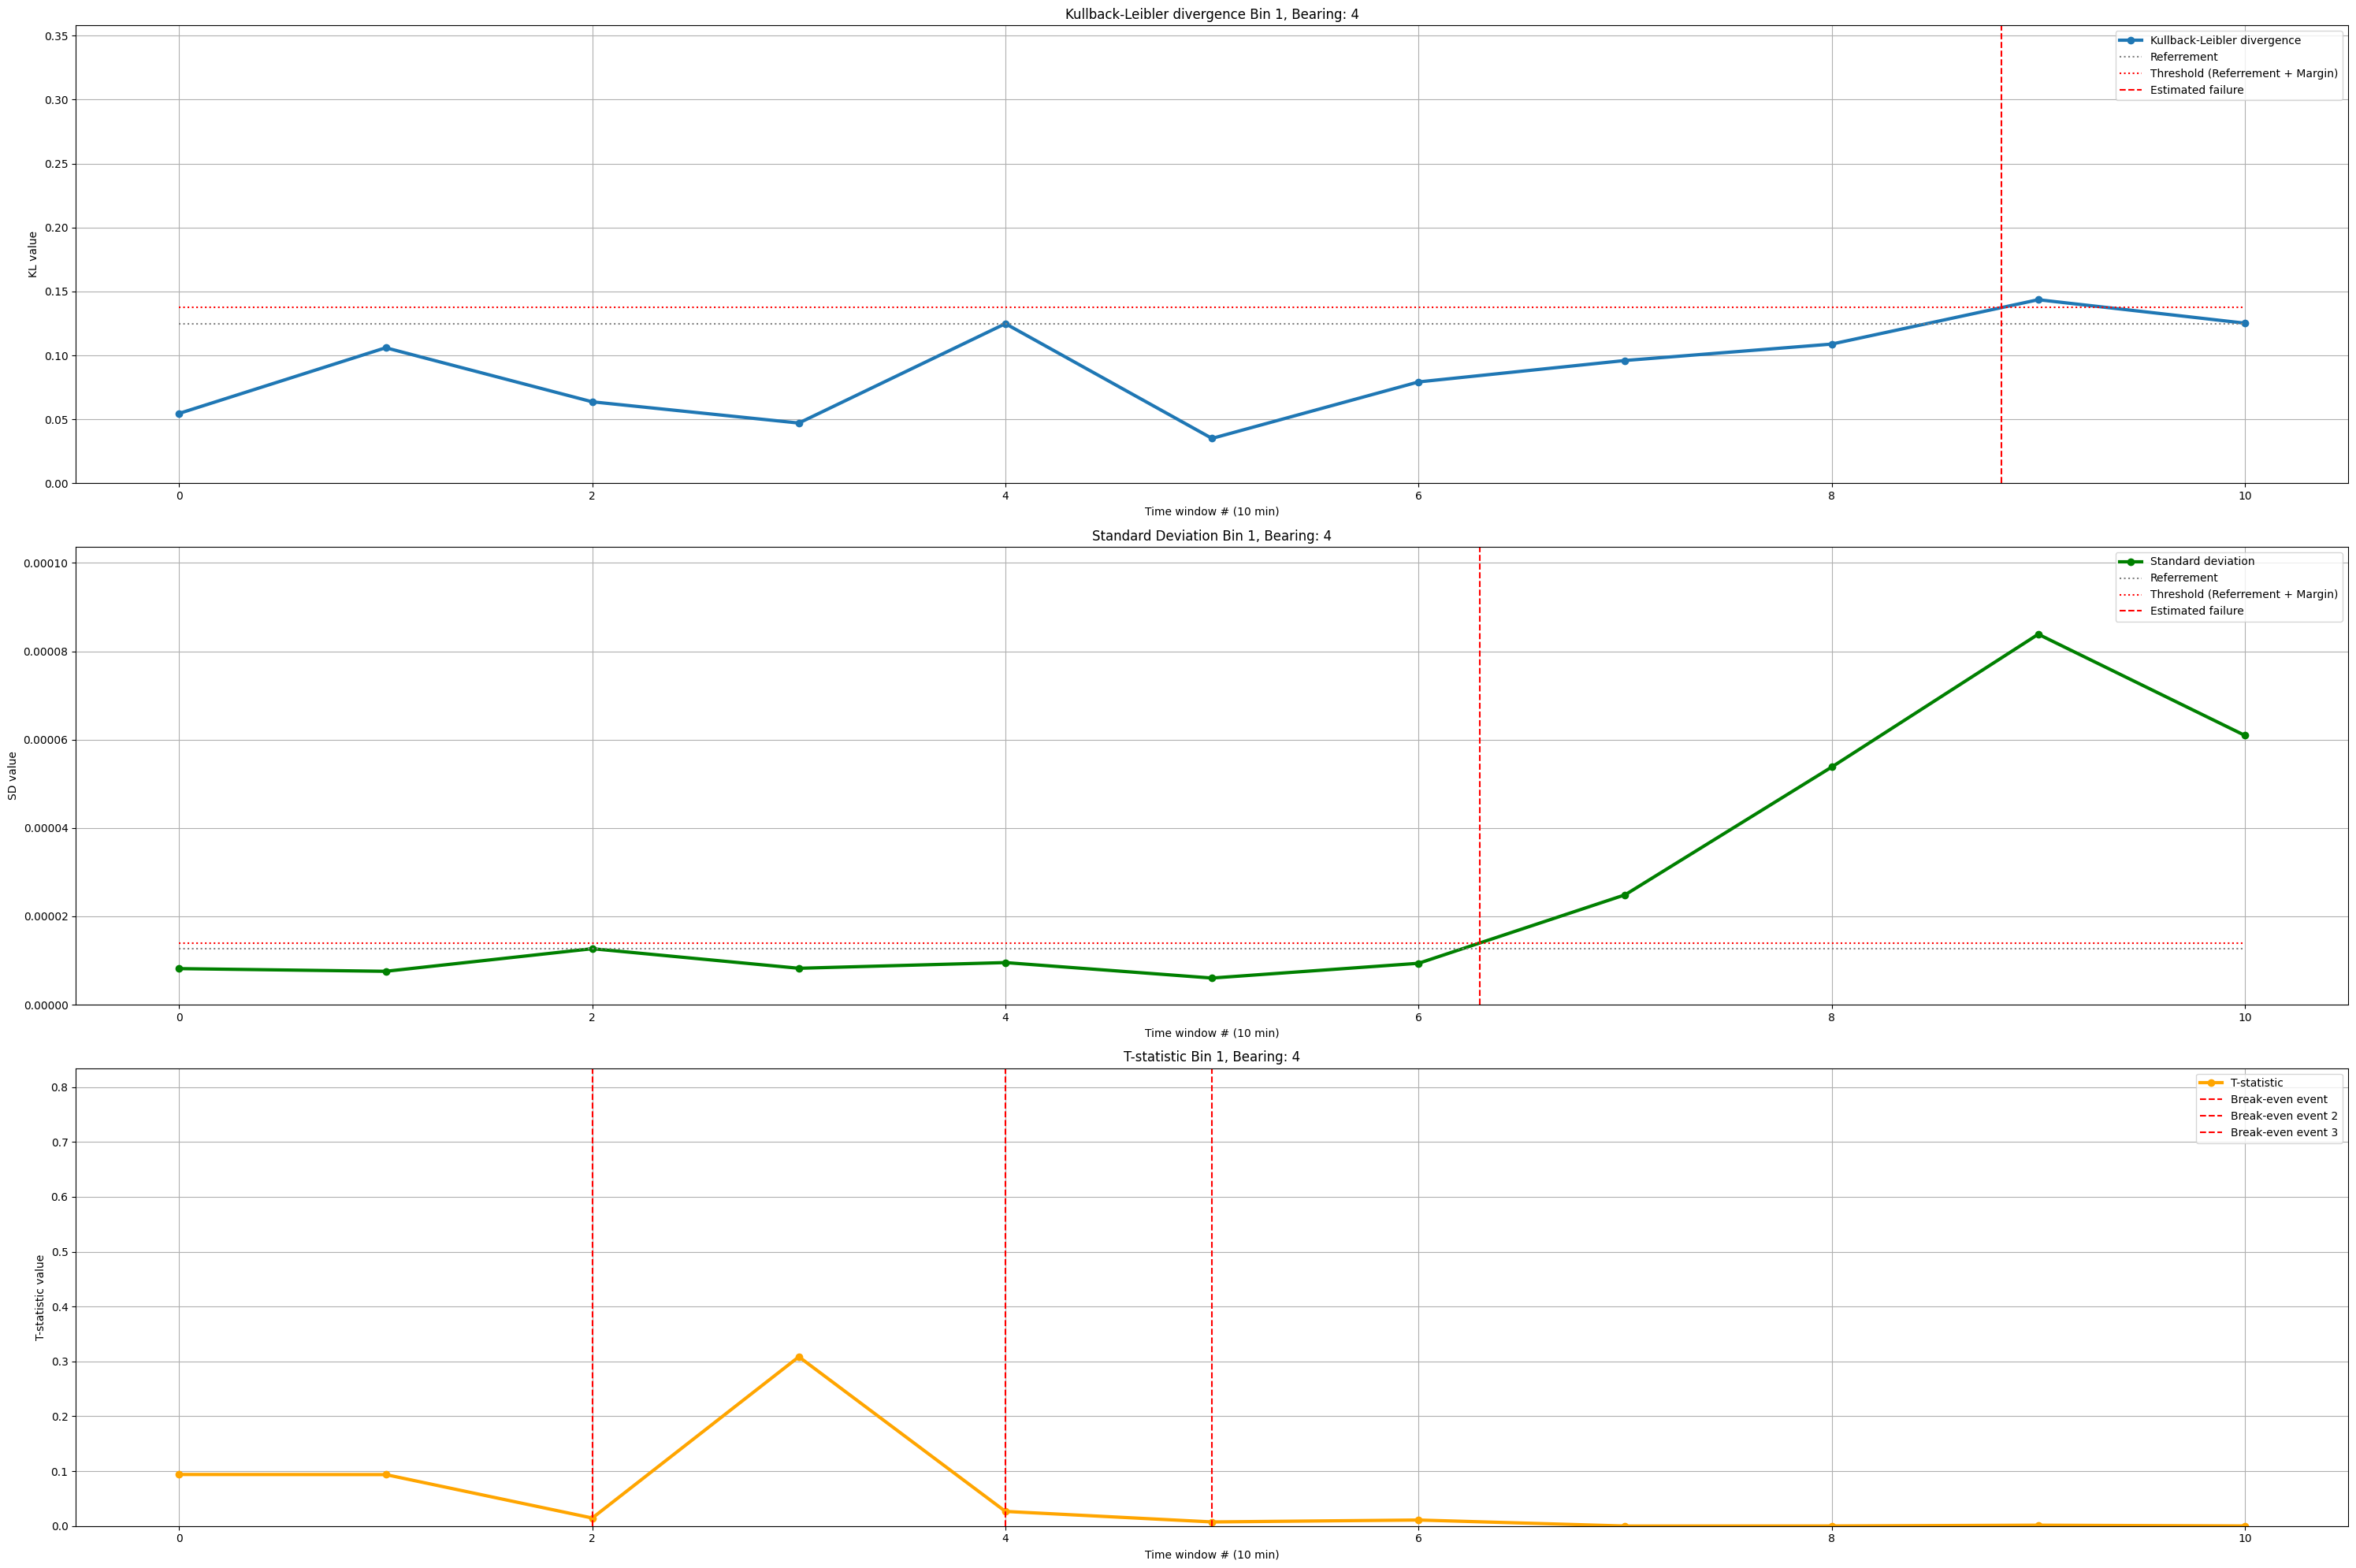

In [337]:
i = 0
b_num = 1

for bearing in eval_KL:
#26
    if i< 3:
        i += 1
        b_num += 1
        continue
    
    max_x= len(bearing[0]) - 1
    max_y= 10

    fig, (ax0, ax1, ax2) = plt.subplots(figsize=(30, 20), nrows=3)
    ax0.plot(bearing[0][break_in_offset:], label='Kullback-Leibler divergence', marker='o', linewidth=3)
    ax0.set_title("Kullback-Leibler divergence Bin 1, Bearing: {}".format(b_num))
    ax0.set_xlabel("Time window # ({} min)".format(minutes))
    ax0.set_ylabel("KL value")
    ax0.hlines(event_kl[i][0][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax0.hlines(event_kl[i][0][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_kl[i][0][2]> 0):
        ax0.vlines(event_kl[i][0][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax0.legend()
    ax1.plot(eval_SD[i][0][break_in_offset:], label='Standard deviation', color= 'green', marker='o', linewidth=3)
    ax1.set_title("Standard Deviation Bin 1, Bearing: {}".format(b_num))
    ax1.set_xlabel("Time window # ({} min)".format(minutes))
    ax1.set_ylabel("SD value")
    ax1.hlines(event_sd[i][0][0], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "gray", label= "Referrement")
    ax1.hlines(event_sd[i][0][1], linestyles= "dotted", xmin= 0 , xmax= max_x, color= "red", label= "Threshold (Referrement + Margin)")
    if (event_sd[i][0][2]> 0):
        ax1.vlines(event_sd[i][0][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Estimated failure")
    ax1.legend()
    ax2.plot(eval_t[i][0][break_in_offset:], label='T-statistic', color= 'orange', marker='o', linewidth=3)
    ax2.set_title("T-statistic Bin 1, Bearing: {}".format(b_num))
    ax2.set_xlabel("Time window # ({} min)".format(minutes))
    ax2.set_ylabel("T-statistic value")
    if (event_t[i][0][0]> 0):
        ax2.vlines(event_t[i][0][0], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event")
        if (event_t[i][0][1]> 0):
            ax2.vlines(event_t[i][0][1], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 2")
            if (event_t[i][0][2]> 0):
                ax2.vlines(event_t[i][0][2], linestyles= "dashed", ymin= 0 , ymax= max_y, color= "red", label= "Break-even event 3")
    ax2.legend()

    ax0.set_ylim([0, np.average(bearing[0])* 4])
    ax1.set_ylim([0, np.average(eval_SD[i][0])* 4])
    ax2.set_ylim([0, np.average(eval_t[i][0][average_offset:])*scale_multiplier])


    ax0.grid()
    ax1.grid()
    ax2.grid()

    title= dataset_path = "./data/XJTU-SY/figs/bearing_bigsize" + str(b_num) + ".png"
    fig.tight_layout()
    fig.savefig(title, dpi= 200, format= "png")
    i += 1
    b_num += 1
    break

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 5.39244e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 3.72645e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 3.72645e+08] [loc=-512.000 scale=512.000]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 3.9488e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [t         ] [0.10 sec] [RSS: 3.85886e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [genextreme] [0.14 sec] [RSS: 4.75615e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [gamma     ] [0.20 sec] [RSS: 4.67621e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [lognorm   ] [0.09 sec] [RSS: 6.31255e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [beta      ] [0.15 sec] [RSS: 4.68665e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 8.97513e+08] [loc=0.000 scale=0.000]
[distfit] >INFO> [loggamma  ] [0.10 sec] [RSS: 5.56804e+08] [loc=-0.008 scale=0.001]
[distfit] >INFO> Comput

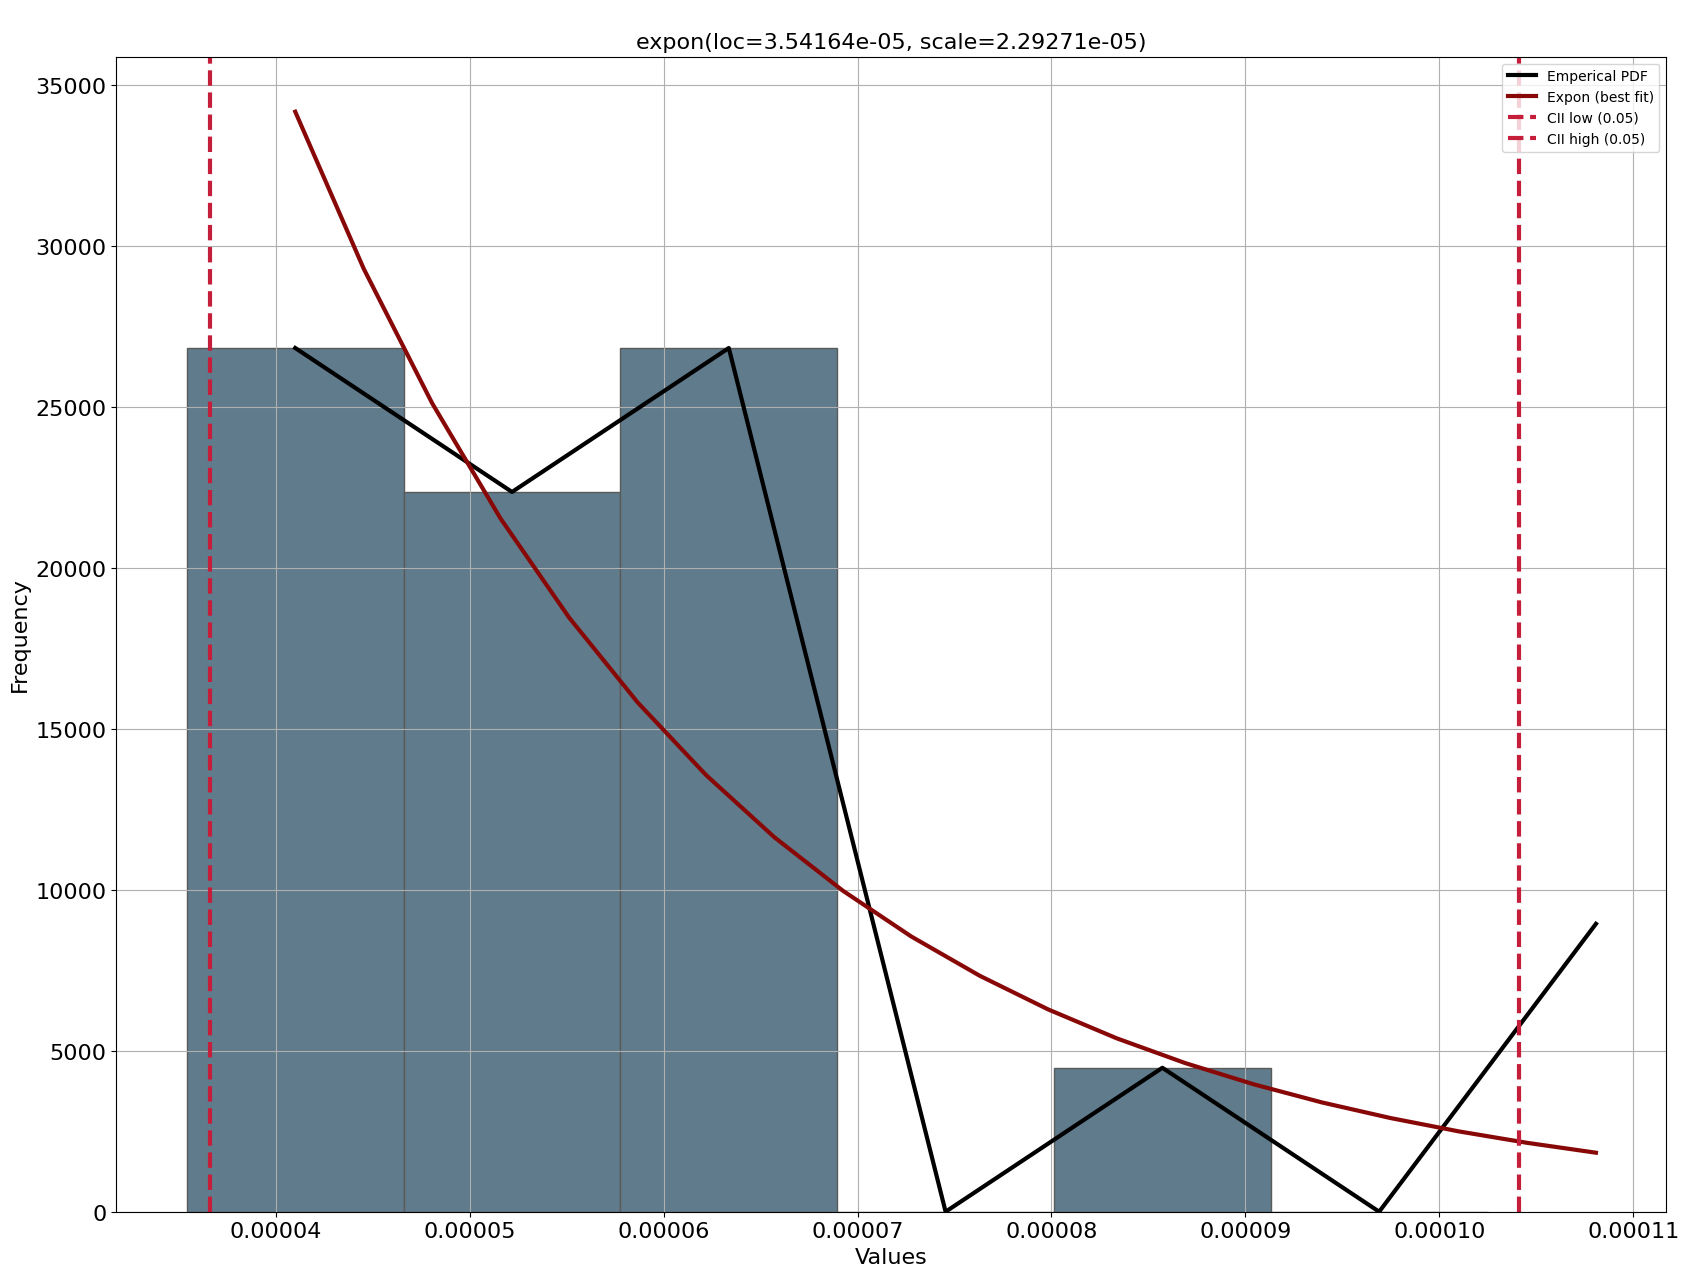

In [115]:
dfit = distfit(todf=True)
results = dfit.fit_transform(set1_good["B1_freq_band_1"].to_numpy())
im = dfit.plot()

[distfit] >INFO> Ploting Summary.


(<Figure size 2000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Expon (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

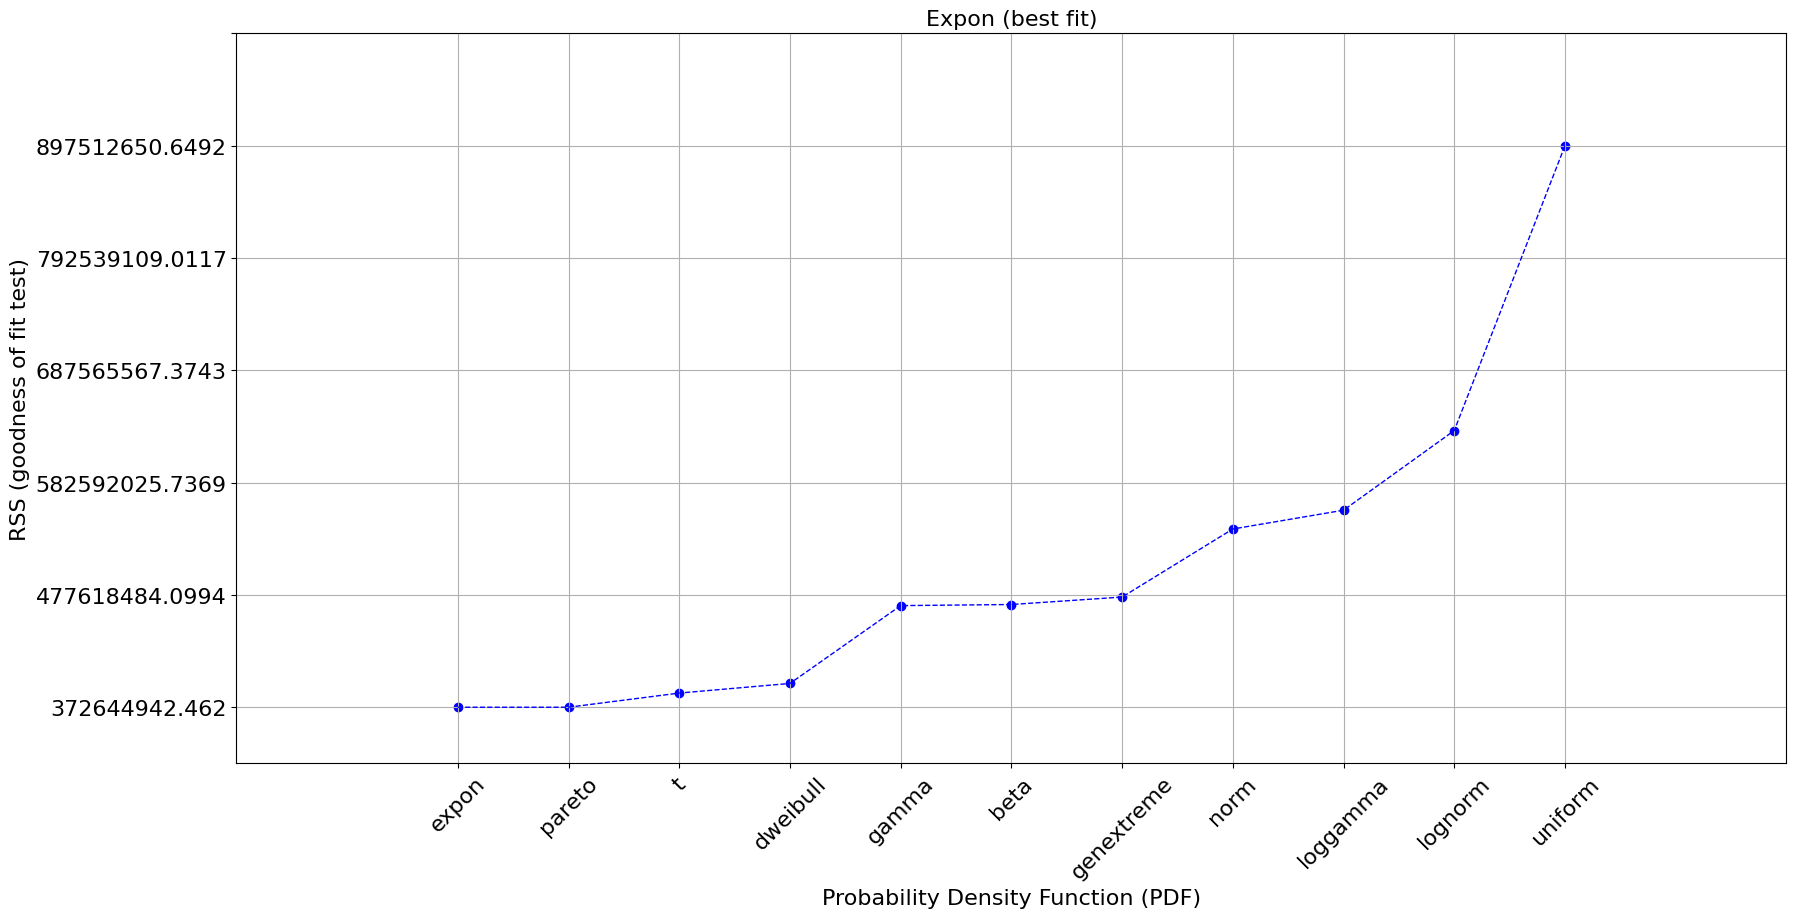

In [116]:
dfit.plot_summary()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 7.05979e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 9.06083e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 9.06083e+06] [loc=-32768.000 scale=32768.000]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 2.6702e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [t         ] [0.09 sec] [RSS: 9.89144e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [genextreme] [0.11 sec] [RSS: 8.35504e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [gamma     ] [0.05 sec] [RSS: 6.48395e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [lognorm   ] [0.09 sec] [RSS: 7.83711e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [beta      ] [0.13 sec] [RSS: 6.0449e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 7.07669e+06] [loc=0.000 scale=0.000]
[distfit] >INFO> [loggamma  ] [0.16 sec] [RSS: 6.93371e+06] [loc=-0.045 scale=0.006]
[distfit] >INFO> Com

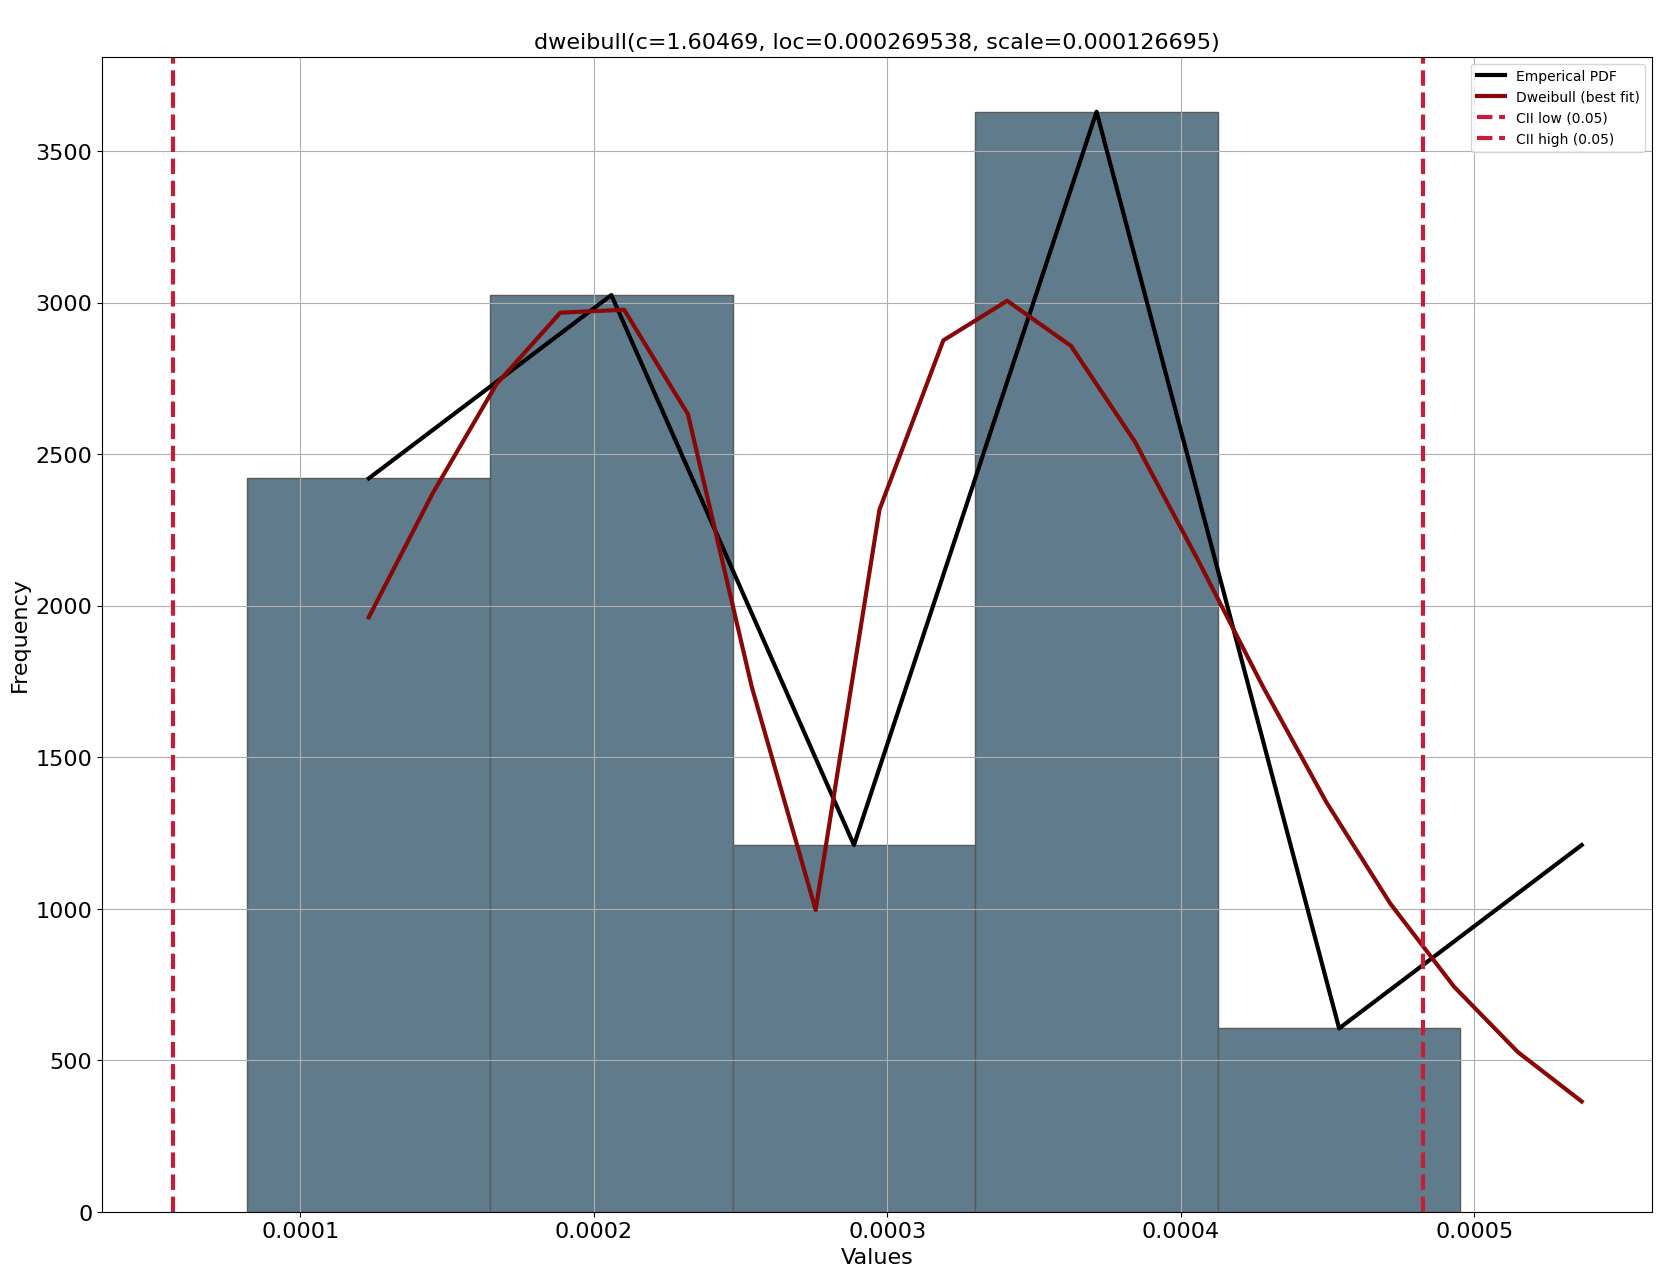

In [113]:
dfit = distfit(todf=True)
results = dfit.fit_transform(set1_bad["B1_freq_band_1"].to_numpy())
im = dfit.plot()

[distfit] >INFO> Ploting Summary.


(<Figure size 2000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Dweibull (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

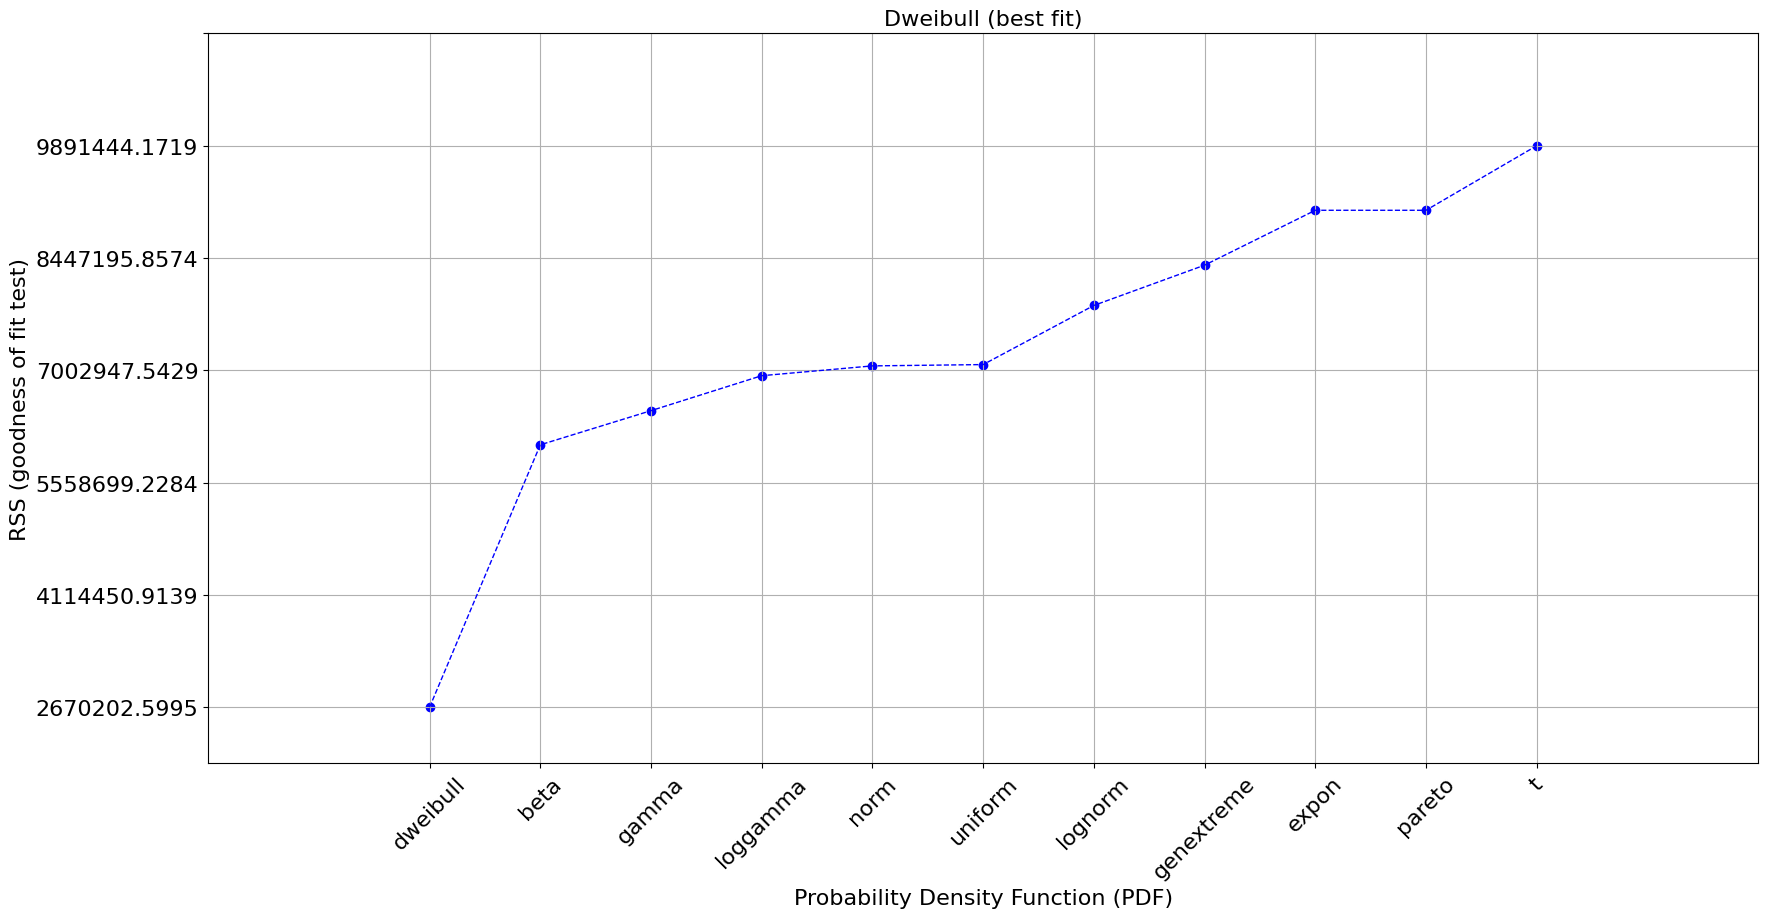

In [114]:
dfit.plot_summary()

# Event assestment

In [2]:
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.datasets import load_whas500
from sksurv.util import Surv
import pickle

In [3]:
dataset_path = "./data/XJTU-SY/csv/"
set_analytic= pd.read_csv(dataset_path + 'analytic.csv')
set_covariates= pd.read_csv(dataset_path + 'covariates.csv')
set_boot= pd.read_csv(dataset_path + 'boot.csv')

file_handler = open(dataset_path + "event_kl", 'rb')
# pickle.dump(event_kl, file_handler)
# file_handler.close()
event_kl = pickle.load(file_handler)
file_handler.close()


file_handler = open(dataset_path + "event_sd", 'rb')
# pickle.dump(event_sd, file_handler)
# file_handler.close()
event_sd = pickle.load(file_handler)
file_handler.close()

info_pack= {'KL': event_kl, 'SD': event_sd} #event_t
bootno = 2
bearings = 5


EOFError: Ran out of input

In [242]:
column= "40_Event"
if re.findall(r"Event\b", column):
    print (column)
rand= random.randint(-2, -1)
print (rand)
print (set_boot)

40_Event
-2
   1  2  3  4  5
0  3  4 -3  2  2
1 -4 -1  3  1  3
2 -1 -3 -4 -4 -1


In [23]:
def load_bearing_data(covariates, info_pack, bootno):

    row = pd.DataFrame()
    data_cov= pd.DataFrame()
    ref_value= {}
  
    for bear_num in range (1, total_bearings + 1, (bootno * 2) + 4):
        val= event_analyzer (bear_num, info_pack)
        ref_value.update({bear_num : val})
    
    for column in covariates:

        columnSeriesObj = covariates[column]
        bear_num = int(re.findall("\d?\d?\d", column)[0])
        temp_label_cov= ""
        columnSeriesObj= columnSeriesObj.dropna()
        
        if re.findall(r"mean\b", column):
            temp_label_cov = "mean"
        elif re.findall(r"std\b", column):
            temp_label_cov = "std"
        elif re.findall(r"skew\b", column):
            temp_label_cov = "skew"
        elif re.findall(r"kurtosis\b", column):
            temp_label_cov = "kurtosis"
        elif re.findall(r"entropy\b", column):
            temp_label_cov = "entropy"
        elif re.findall(r"rms\b", column):
            temp_label_cov = "rms"
        elif re.findall(r"max\b", column):
            temp_label_cov = "max"
        elif re.findall(r"p2p\b", column):
            temp_label_cov = "p2p"
        elif re.findall(r"crest\b", column):
            temp_label_cov = "crest"
        elif re.findall(r"clearence\b", column):
            temp_label_cov = "clearence"
        elif re.findall(r"shape\b", column):
            temp_label_cov = "shape"
        elif re.findall(r"impulse\b", column):
            temp_label_cov = "impulse"
        elif re.findall(r"Event\b", column):
            temp_label_cov = "Event"
            columnSeriesObj = ev_manager (bear_num, bootno, total_bearings)
        elif re.findall(r"Survival_time\b", column):
            temp_label_cov = "Survival_time"
            columnSeriesObj = sur_time_manager(bear_num, set_boot, ref_value)
        
        label= temp_label_cov
        
        if label == "Event" or label == "Survival_time":
            row [label]= pd.Series(columnSeriesObj).T  
        else:
            row [label]= pd.Series(np.mean(columnSeriesObj.values)).T

        if label == "Survival_time":
            data_cov = pd.concat([data_cov, row], ignore_index= True)

    data_sa = Surv.from_dataframe("Event", "Survival_time", data_cov)


    return data_cov.drop(["Event", "Survival_time"], axis=1), data_sa 

In [22]:
def ev_manager (num, bootno, tot):

    checker= True

    for check in range(7, tot + 1, (bootno * 2) + 4):
    
        if check == num or check == num - 1: 
            checker= False
            break
        else:
            checker= True
        
    if checker == False:
        return False
    else:
        return True 

In [21]:
def sur_time_manager (num, bootref, ref):

    for key, value in ref.items():
        if key == num or key + 1 == num:
            return value + random.randint(-2, 2)    
    
    bootno= len (bootref) - 1
    tot= ((bootno * 2) + 4) * 5
    num_ref= 3
    i= 0
    
    #Bootstrapping + addtitional randomizator
    for check in range(9, tot + (bootno * 2) + 5, (bootno * 2) + 4):    
        if not num >= check:
            if num== num_ref:
                return bootref.iat[0,i] + ref[check - 8] + random.randint(-2, -1)               
            elif num== num_ref + 1:
                return bootref.iat[0,i] + ref[check - 8] + random.randint(1, 2)     
            elif num== num_ref + 2:
                return bootref.iat[1,i] + ref[check - 8] + random.randint(-2, -1)               
            elif num== num_ref + 3:
                return bootref.iat[1,i] + ref[check - 8] + random.randint(1, 2)   
            elif num== num_ref + 4:
                return bootref.iat[2,i] + ref[check - 8] + random.randint(-2, -1)              
            elif num== num_ref + 5:
                return bootref.iat[2,i] + ref[check - 8] + random.randint(1, 2)   
            
        num_ref+= (bootno * 2) + 4
        i+= 1

    return -1 

In [20]:
def event_analyzer (bear_num, info_pack):
    
    lifetime_guarantee= 30
    data_kl= []
    data_sd= []

    for info in info_pack:
        for bear_info in info_pack [info][bear_num]:
            cross= bear_info [2] * 10  #10 as window
            tot_lenght= bear_info [3] * 10  #10 as window

            if info == "KL":
                if cross > (tot_lenght)/100 * lifetime_guarantee:
                    data_kl.append(cross)
            elif info == "SD":
                if cross > (tot_lenght)/100 * lifetime_guarantee:
                    data_sd.append(cross)

    if not data_kl:
        if data_sd:
            data_kl= data_sd
        else:
            raise Exception("Result impredictable")
    if not data_sd:
        if data_kl:
            data_sd= data_kl
        else:
            raise Exception("Result impredictable")

    res = [max (data_kl), max (data_sd)]
    res= round (statistics.mean (res), 1)

    return res

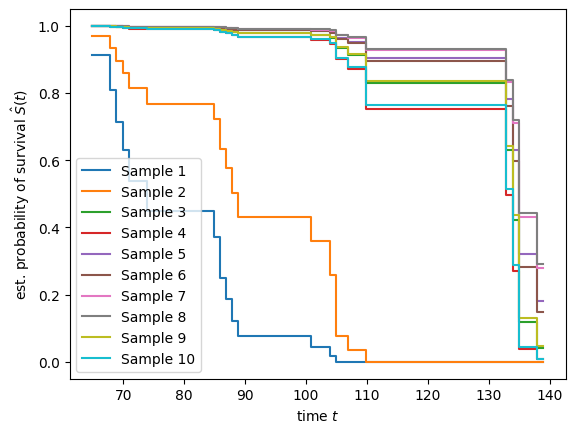

In [343]:
pred_surv = estimator.predict_survival_function(data_x_test)
time_points = np.arange(64.9, 139.4)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [344]:
estimator.score(data_x, data_y)

0.5803571428571429